In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 828)
(772408, 8)
validation
(101248, 828)
(101248, 8)
test
(98888, 828)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:41 - loss: 1.8944 - STD: 0.0542 - MAE: 0.2101

 4/78 [>.............................] - ETA: 1s - loss: 1.5291 - STD: 0.1501 - MAE: 0.1649  

 5/78 [>.............................] - ETA: 2s - loss: 1.5021 - STD: 0.1706 - MAE: 0.1563

 6/78 [=>............................] - ETA: 2s - loss: 1.4824 - STD: 0.1842 - MAE: 0.1506

 7/78 [=>............................] - ETA: 2s - loss: 1.4669 - STD: 0.1927 - MAE: 0.1471

 8/78 [==>...........................] - ETA: 3s - loss: 1.4528 - STD: 0.1970 - MAE: 0.1452

 9/78 [==>...........................] - ETA: 3s - loss: 1.4410 - STD: 0.1983 - MAE: 0.1446

10/78 [==>...........................] - ETA: 3s - loss: 1.4307 - STD: 0.1973 - MAE: 0.1449

11/78 [===>..........................] - ETA: 3s - loss: 1.4229 - STD: 0.1950 - MAE: 0.1457

12/78 [===>..........................] - ETA: 3s - loss: 1.4163 - STD: 0.1924 - MAE: 0.1467

13/78 [====>.........................] - ETA: 3s - loss: 1.4124 - STD: 0.1898 - MAE: 0.1477

14/78 [====>.........................] - ETA: 3s - loss: 1.4075 - STD: 0.1877 - MAE: 0.1484

15/78 [====>.........................] - ETA: 3s - loss: 1.4030 - STD: 0.1863 - MAE: 0.1489

16/78 [=====>........................] - ETA: 3s - loss: 1.3980 - STD: 0.1856 - MAE: 0.1490

17/78 [=====>........................] - ETA: 3s - loss: 1.3950 - STD: 0.1856 - MAE: 0.1490

18/78 [=====>........................] - ETA: 3s - loss: 1.3916 - STD: 0.1861 - MAE: 0.1488

19/78 [======>.......................] - ETA: 3s - loss: 1.3874 - STD: 0.1870 - MAE: 0.1484

20/78 [======>.......................] - ETA: 3s - loss: 1.3845 - STD: 0.1881 - MAE: 0.1479

21/78 [=======>......................] - ETA: 3s - loss: 1.3815 - STD: 0.1893 - MAE: 0.1474

22/78 [=======>......................] - ETA: 3s - loss: 1.3782 - STD: 0.1904 - MAE: 0.1468

23/78 [=======>......................] - ETA: 2s - loss: 1.3754 - STD: 0.1914 - MAE: 0.1464

24/78 [========>.....................] - ETA: 2s - loss: 1.3739 - STD: 0.1921 - MAE: 0.1461

25/78 [========>.....................] - ETA: 2s - loss: 1.3712 - STD: 0.1926 - MAE: 0.1459

26/78 [=========>....................] - ETA: 2s - loss: 1.3696 - STD: 0.1928 - MAE: 0.1457

27/78 [=========>....................] - ETA: 2s - loss: 1.3675 - STD: 0.1928 - MAE: 0.1457

28/78 [=========>....................] - ETA: 2s - loss: 1.3651 - STD: 0.1926 - MAE: 0.1457

29/78 [==========>...................] - ETA: 2s - loss: 1.3640 - STD: 0.1923 - MAE: 0.1458

30/78 [==========>...................] - ETA: 2s - loss: 1.3623 - STD: 0.1919 - MAE: 0.1459

31/78 [==========>...................] - ETA: 2s - loss: 1.3606 - STD: 0.1915 - MAE: 0.1460

32/78 [===========>..................] - ETA: 2s - loss: 1.3593 - STD: 0.1912 - MAE: 0.1462

33/78 [===========>..................] - ETA: 2s - loss: 1.3585 - STD: 0.1910 - MAE: 0.1462

34/78 [============>.................] - ETA: 2s - loss: 1.3572 - STD: 0.1909 - MAE: 0.1463

35/78 [============>.................] - ETA: 2s - loss: 1.3562 - STD: 0.1908 - MAE: 0.1463

36/78 [============>.................] - ETA: 2s - loss: 1.3547 - STD: 0.1909 - MAE: 0.1462

37/78 [=============>................] - ETA: 2s - loss: 1.3535 - STD: 0.1910 - MAE: 0.1461

38/78 [=============>................] - ETA: 2s - loss: 1.3527 - STD: 0.1912 - MAE: 0.1461

39/78 [==============>...............] - ETA: 2s - loss: 1.3508 - STD: 0.1913 - MAE: 0.1459

40/78 [==============>...............] - ETA: 2s - loss: 1.3493 - STD: 0.1915 - MAE: 0.1458

41/78 [==============>...............] - ETA: 2s - loss: 1.3492 - STD: 0.1917 - MAE: 0.1457

42/78 [===============>..............] - ETA: 2s - loss: 1.3486 - STD: 0.1919 - MAE: 0.1457

43/78 [===============>..............] - ETA: 1s - loss: 1.3478 - STD: 0.1920 - MAE: 0.1456

44/78 [===============>..............] - ETA: 1s - loss: 1.3471 - STD: 0.1920 - MAE: 0.1456

45/78 [================>.............] - ETA: 1s - loss: 1.3466 - STD: 0.1920 - MAE: 0.1456

46/78 [================>.............] - ETA: 1s - loss: 1.3464 - STD: 0.1919 - MAE: 0.1457

47/78 [=================>............] - ETA: 1s - loss: 1.3457 - STD: 0.1918 - MAE: 0.1457

48/78 [=================>............] - ETA: 1s - loss: 1.3449 - STD: 0.1917 - MAE: 0.1457

49/78 [=================>............] - ETA: 1s - loss: 1.3444 - STD: 0.1915 - MAE: 0.1458

50/78 [==================>...........] - ETA: 1s - loss: 1.3440 - STD: 0.1914 - MAE: 0.1458

51/78 [==================>...........] - ETA: 1s - loss: 1.3435 - STD: 0.1913 - MAE: 0.1459

52/78 [===================>..........] - ETA: 1s - loss: 1.3430 - STD: 0.1912 - MAE: 0.1459

53/78 [===================>..........] - ETA: 1s - loss: 1.3424 - STD: 0.1912 - MAE: 0.1459

54/78 [===================>..........] - ETA: 1s - loss: 1.3419 - STD: 0.1912 - MAE: 0.1459

55/78 [====================>.........] - ETA: 1s - loss: 1.3412 - STD: 0.1913 - MAE: 0.1458

56/78 [====================>.........] - ETA: 1s - loss: 1.3408 - STD: 0.1913 - MAE: 0.1458

57/78 [====================>.........] - ETA: 1s - loss: 1.3405 - STD: 0.1914 - MAE: 0.1458

58/78 [=====================>........] - ETA: 1s - loss: 1.3405 - STD: 0.1915 - MAE: 0.1458

59/78 [=====================>........] - ETA: 1s - loss: 1.3400 - STD: 0.1915 - MAE: 0.1457

60/78 [======================>.......] - ETA: 1s - loss: 1.3395 - STD: 0.1915 - MAE: 0.1457

61/78 [======================>.......] - ETA: 0s - loss: 1.3390 - STD: 0.1915 - MAE: 0.1457

62/78 [======================>.......] - ETA: 0s - loss: 1.3384 - STD: 0.1915 - MAE: 0.1457

63/78 [=======================>......] - ETA: 0s - loss: 1.3380 - STD: 0.1914 - MAE: 0.1457

64/78 [=======================>......] - ETA: 0s - loss: 1.3376 - STD: 0.1914 - MAE: 0.1458

65/78 [========================>.....] - ETA: 0s - loss: 1.3372 - STD: 0.1913 - MAE: 0.1458

66/78 [========================>.....] - ETA: 0s - loss: 1.3368 - STD: 0.1913 - MAE: 0.1458

67/78 [========================>.....] - ETA: 0s - loss: 1.3366 - STD: 0.1913 - MAE: 0.1458

68/78 [=========================>....] - ETA: 0s - loss: 1.3362 - STD: 0.1913 - MAE: 0.1458

69/78 [=========================>....] - ETA: 0s - loss: 1.3358 - STD: 0.1913 - MAE: 0.1457

70/78 [=========================>....] - ETA: 0s - loss: 1.3354 - STD: 0.1913 - MAE: 0.1457

71/78 [==========================>...] - ETA: 0s - loss: 1.3350 - STD: 0.1913 - MAE: 0.1457

72/78 [==========================>...] - ETA: 0s - loss: 1.3347 - STD: 0.1914 - MAE: 0.1457

73/78 [===========================>..] - ETA: 0s - loss: 1.3343 - STD: 0.1914 - MAE: 0.1457

74/78 [===========================>..] - ETA: 0s - loss: 1.3342 - STD: 0.1914 - MAE: 0.1457

78/78 [==============================] - ETA: 0s - loss: 1.3327 - STD: 0.1914 - MAE: 0.1456

78/78 [==============================] - 7s 71ms/step - loss: 1.3327 - STD: 0.1914 - MAE: 0.1456 - val_loss: 1.2572 - val_STD: 0.1913 - val_MAE: 0.1442


Epoch 2/10000


 1/78 [..............................] - ETA: 7s - loss: 1.2995 - STD: 0.1920 - MAE: 0.1442

 2/78 [..............................] - ETA: 4s - loss: 1.2900 - STD: 0.1924 - MAE: 0.1435

 3/78 [>.............................] - ETA: 4s - loss: 1.2842 - STD: 0.1929 - MAE: 0.1431

 4/78 [>.............................] - ETA: 4s - loss: 1.2883 - STD: 0.1934 - MAE: 0.1432

 5/78 [>.............................] - ETA: 4s - loss: 1.2917 - STD: 0.1936 - MAE: 0.1433

 6/78 [=>............................] - ETA: 4s - loss: 1.2949 - STD: 0.1935 - MAE: 0.1436

 7/78 [=>............................] - ETA: 4s - loss: 1.2962 - STD: 0.1930 - MAE: 0.1438

 8/78 [==>...........................] - ETA: 4s - loss: 1.2949 - STD: 0.1924 - MAE: 0.1440

 9/78 [==>...........................] - ETA: 3s - loss: 1.2951 - STD: 0.1919 - MAE: 0.1442

10/78 [==>...........................] - ETA: 3s - loss: 1.2935 - STD: 0.1914 - MAE: 0.1443

11/78 [===>..........................] - ETA: 3s - loss: 1.2927 - STD: 0.1912 - MAE: 0.1443

12/78 [===>..........................] - ETA: 3s - loss: 1.2901 - STD: 0.1913 - MAE: 0.1441

13/78 [====>.........................] - ETA: 3s - loss: 1.2882 - STD: 0.1916 - MAE: 0.1439

14/78 [====>.........................] - ETA: 3s - loss: 1.2862 - STD: 0.1920 - MAE: 0.1437

15/78 [====>.........................] - ETA: 3s - loss: 1.2848 - STD: 0.1921 - MAE: 0.1436

16/78 [=====>........................] - ETA: 3s - loss: 1.2831 - STD: 0.1921 - MAE: 0.1435

17/78 [=====>........................] - ETA: 3s - loss: 1.2819 - STD: 0.1921 - MAE: 0.1435

18/78 [=====>........................] - ETA: 3s - loss: 1.2812 - STD: 0.1922 - MAE: 0.1434

19/78 [======>.......................] - ETA: 3s - loss: 1.2801 - STD: 0.1923 - MAE: 0.1433

20/78 [======>.......................] - ETA: 3s - loss: 1.2796 - STD: 0.1926 - MAE: 0.1432

21/78 [=======>......................] - ETA: 3s - loss: 1.2779 - STD: 0.1928 - MAE: 0.1430

22/78 [=======>......................] - ETA: 3s - loss: 1.2761 - STD: 0.1931 - MAE: 0.1429

23/78 [=======>......................] - ETA: 3s - loss: 1.2748 - STD: 0.1932 - MAE: 0.1427

24/78 [========>.....................] - ETA: 3s - loss: 1.2738 - STD: 0.1934 - MAE: 0.1426

25/78 [========>.....................] - ETA: 3s - loss: 1.2737 - STD: 0.1936 - MAE: 0.1425

26/78 [=========>....................] - ETA: 2s - loss: 1.2724 - STD: 0.1938 - MAE: 0.1424

27/78 [=========>....................] - ETA: 2s - loss: 1.2713 - STD: 0.1939 - MAE: 0.1424

28/78 [=========>....................] - ETA: 2s - loss: 1.2699 - STD: 0.1941 - MAE: 0.1423

29/78 [==========>...................] - ETA: 2s - loss: 1.2688 - STD: 0.1943 - MAE: 0.1421

30/78 [==========>...................] - ETA: 2s - loss: 1.2672 - STD: 0.1945 - MAE: 0.1420

31/78 [==========>...................] - ETA: 2s - loss: 1.2663 - STD: 0.1947 - MAE: 0.1419

32/78 [===========>..................] - ETA: 2s - loss: 1.2652 - STD: 0.1948 - MAE: 0.1418

33/78 [===========>..................] - ETA: 2s - loss: 1.2647 - STD: 0.1948 - MAE: 0.1418

34/78 [============>.................] - ETA: 2s - loss: 1.2637 - STD: 0.1948 - MAE: 0.1418

35/78 [============>.................] - ETA: 2s - loss: 1.2627 - STD: 0.1949 - MAE: 0.1417

36/78 [============>.................] - ETA: 2s - loss: 1.2611 - STD: 0.1950 - MAE: 0.1416

37/78 [=============>................] - ETA: 2s - loss: 1.2598 - STD: 0.1952 - MAE: 0.1415

38/78 [=============>................] - ETA: 2s - loss: 1.2578 - STD: 0.1954 - MAE: 0.1413

39/78 [==============>...............] - ETA: 2s - loss: 1.2567 - STD: 0.1956 - MAE: 0.1412

40/78 [==============>...............] - ETA: 2s - loss: 1.2556 - STD: 0.1958 - MAE: 0.1411

41/78 [==============>...............] - ETA: 2s - loss: 1.2546 - STD: 0.1959 - MAE: 0.1410

42/78 [===============>..............] - ETA: 2s - loss: 1.2536 - STD: 0.1961 - MAE: 0.1409

43/78 [===============>..............] - ETA: 2s - loss: 1.2530 - STD: 0.1962 - MAE: 0.1409

44/78 [===============>..............] - ETA: 1s - loss: 1.2518 - STD: 0.1962 - MAE: 0.1408

45/78 [================>.............] - ETA: 1s - loss: 1.2508 - STD: 0.1962 - MAE: 0.1408

46/78 [================>.............] - ETA: 1s - loss: 1.2500 - STD: 0.1962 - MAE: 0.1408

47/78 [=================>............] - ETA: 1s - loss: 1.2488 - STD: 0.1961 - MAE: 0.1408

48/78 [=================>............] - ETA: 1s - loss: 1.2479 - STD: 0.1961 - MAE: 0.1408

49/78 [=================>............] - ETA: 1s - loss: 1.2465 - STD: 0.1963 - MAE: 0.1406

50/78 [==================>...........] - ETA: 1s - loss: 1.2456 - STD: 0.1964 - MAE: 0.1406

51/78 [==================>...........] - ETA: 1s - loss: 1.2446 - STD: 0.1965 - MAE: 0.1405

52/78 [===================>..........] - ETA: 1s - loss: 1.2439 - STD: 0.1967 - MAE: 0.1404

53/78 [===================>..........] - ETA: 1s - loss: 1.2427 - STD: 0.1969 - MAE: 0.1403

54/78 [===================>..........] - ETA: 1s - loss: 1.2416 - STD: 0.1969 - MAE: 0.1403

55/78 [====================>.........] - ETA: 1s - loss: 1.2406 - STD: 0.1969 - MAE: 0.1402

56/78 [====================>.........] - ETA: 1s - loss: 1.2397 - STD: 0.1969 - MAE: 0.1402

57/78 [====================>.........] - ETA: 1s - loss: 1.2389 - STD: 0.1970 - MAE: 0.1402

59/78 [=====================>........] - ETA: 1s - loss: 1.2377 - STD: 0.1969 - MAE: 0.1402

60/78 [======================>.......] - ETA: 1s - loss: 1.2369 - STD: 0.1970 - MAE: 0.1401

61/78 [======================>.......] - ETA: 0s - loss: 1.2357 - STD: 0.1971 - MAE: 0.1400

62/78 [======================>.......] - ETA: 0s - loss: 1.2348 - STD: 0.1972 - MAE: 0.1399

63/78 [=======================>......] - ETA: 0s - loss: 1.2339 - STD: 0.1973 - MAE: 0.1399

64/78 [=======================>......] - ETA: 0s - loss: 1.2327 - STD: 0.1974 - MAE: 0.1398

65/78 [========================>.....] - ETA: 0s - loss: 1.2315 - STD: 0.1975 - MAE: 0.1397

66/78 [========================>.....] - ETA: 0s - loss: 1.2309 - STD: 0.1975 - MAE: 0.1397

67/78 [========================>.....] - ETA: 0s - loss: 1.2300 - STD: 0.1975 - MAE: 0.1397

68/78 [=========================>....] - ETA: 0s - loss: 1.2290 - STD: 0.1976 - MAE: 0.1396

69/78 [=========================>....] - ETA: 0s - loss: 1.2278 - STD: 0.1976 - MAE: 0.1396

70/78 [=========================>....] - ETA: 0s - loss: 1.2269 - STD: 0.1977 - MAE: 0.1395

71/78 [==========================>...] - ETA: 0s - loss: 1.2261 - STD: 0.1978 - MAE: 0.1395

72/78 [==========================>...] - ETA: 0s - loss: 1.2251 - STD: 0.1978 - MAE: 0.1394

73/78 [===========================>..] - ETA: 0s - loss: 1.2242 - STD: 0.1979 - MAE: 0.1394

74/78 [===========================>..] - ETA: 0s - loss: 1.2233 - STD: 0.1979 - MAE: 0.1393

75/78 [===========================>..] - ETA: 0s - loss: 1.2226 - STD: 0.1979 - MAE: 0.1393

76/78 [============================>.] - ETA: 0s - loss: 1.2214 - STD: 0.1979 - MAE: 0.1393

77/78 [============================>.] - ETA: 0s - loss: 1.2202 - STD: 0.1980 - MAE: 0.1392

78/78 [==============================] - ETA: 0s - loss: 1.2191 - STD: 0.1981 - MAE: 0.1391

78/78 [==============================] - 5s 61ms/step - loss: 1.2191 - STD: 0.1981 - MAE: 0.1391 - val_loss: 1.0949 - val_STD: 0.1952 - val_MAE: 0.1353


Epoch 3/10000


 1/78 [..............................] - ETA: 3s - loss: 1.1736 - STD: 0.2059 - MAE: 0.1356

 2/78 [..............................] - ETA: 5s - loss: 1.1480 - STD: 0.2050 - MAE: 0.1350

 3/78 [>.............................] - ETA: 4s - loss: 1.1413 - STD: 0.2024 - MAE: 0.1356

 4/78 [>.............................] - ETA: 4s - loss: 1.1398 - STD: 0.2017 - MAE: 0.1356

 5/78 [>.............................] - ETA: 4s - loss: 1.1356 - STD: 0.2024 - MAE: 0.1351

 6/78 [=>............................] - ETA: 4s - loss: 1.1356 - STD: 0.2046 - MAE: 0.1341

 7/78 [=>............................] - ETA: 4s - loss: 1.1354 - STD: 0.2039 - MAE: 0.1343

 8/78 [==>...........................] - ETA: 4s - loss: 1.1326 - STD: 0.2036 - MAE: 0.1343

 9/78 [==>...........................] - ETA: 4s - loss: 1.1317 - STD: 0.2035 - MAE: 0.1343

10/78 [==>...........................] - ETA: 4s - loss: 1.1303 - STD: 0.2033 - MAE: 0.1343

11/78 [===>..........................] - ETA: 4s - loss: 1.1313 - STD: 0.2037 - MAE: 0.1342

12/78 [===>..........................] - ETA: 4s - loss: 1.1297 - STD: 0.2043 - MAE: 0.1338

13/78 [====>.........................] - ETA: 3s - loss: 1.1277 - STD: 0.2043 - MAE: 0.1337

14/78 [====>.........................] - ETA: 3s - loss: 1.1259 - STD: 0.2041 - MAE: 0.1337

15/78 [====>.........................] - ETA: 3s - loss: 1.1242 - STD: 0.2042 - MAE: 0.1336

16/78 [=====>........................] - ETA: 3s - loss: 1.1221 - STD: 0.2046 - MAE: 0.1333

17/78 [=====>........................] - ETA: 3s - loss: 1.1212 - STD: 0.2051 - MAE: 0.1331

18/78 [=====>........................] - ETA: 3s - loss: 1.1210 - STD: 0.2051 - MAE: 0.1331

19/78 [======>.......................] - ETA: 3s - loss: 1.1193 - STD: 0.2049 - MAE: 0.1331

20/78 [======>.......................] - ETA: 3s - loss: 1.1177 - STD: 0.2051 - MAE: 0.1329

21/78 [=======>......................] - ETA: 3s - loss: 1.1168 - STD: 0.2055 - MAE: 0.1327

22/78 [=======>......................] - ETA: 3s - loss: 1.1149 - STD: 0.2056 - MAE: 0.1325

23/78 [=======>......................] - ETA: 3s - loss: 1.1139 - STD: 0.2056 - MAE: 0.1325

24/78 [========>.....................] - ETA: 3s - loss: 1.1126 - STD: 0.2056 - MAE: 0.1324

25/78 [========>.....................] - ETA: 3s - loss: 1.1116 - STD: 0.2060 - MAE: 0.1322

26/78 [=========>....................] - ETA: 3s - loss: 1.1101 - STD: 0.2060 - MAE: 0.1322

27/78 [=========>....................] - ETA: 3s - loss: 1.1091 - STD: 0.2060 - MAE: 0.1321

28/78 [=========>....................] - ETA: 2s - loss: 1.1080 - STD: 0.2063 - MAE: 0.1320

29/78 [==========>...................] - ETA: 2s - loss: 1.1067 - STD: 0.2064 - MAE: 0.1319

30/78 [==========>...................] - ETA: 2s - loss: 1.1060 - STD: 0.2065 - MAE: 0.1318

31/78 [==========>...................] - ETA: 2s - loss: 1.1044 - STD: 0.2064 - MAE: 0.1318

32/78 [===========>..................] - ETA: 2s - loss: 1.1028 - STD: 0.2067 - MAE: 0.1315

33/78 [===========>..................] - ETA: 2s - loss: 1.1019 - STD: 0.2071 - MAE: 0.1314

34/78 [============>.................] - ETA: 2s - loss: 1.1011 - STD: 0.2070 - MAE: 0.1314

35/78 [============>.................] - ETA: 2s - loss: 1.0998 - STD: 0.2070 - MAE: 0.1313

36/78 [============>.................] - ETA: 2s - loss: 1.0990 - STD: 0.2074 - MAE: 0.1311

37/78 [=============>................] - ETA: 2s - loss: 1.0985 - STD: 0.2075 - MAE: 0.1311

38/78 [=============>................] - ETA: 2s - loss: 1.0977 - STD: 0.2072 - MAE: 0.1311

39/78 [==============>...............] - ETA: 2s - loss: 1.0968 - STD: 0.2074 - MAE: 0.1310

40/78 [==============>...............] - ETA: 2s - loss: 1.0962 - STD: 0.2077 - MAE: 0.1309

41/78 [==============>...............] - ETA: 2s - loss: 1.0950 - STD: 0.2077 - MAE: 0.1308

42/78 [===============>..............] - ETA: 2s - loss: 1.0938 - STD: 0.2077 - MAE: 0.1308

43/78 [===============>..............] - ETA: 2s - loss: 1.0931 - STD: 0.2079 - MAE: 0.1307

44/78 [===============>..............] - ETA: 1s - loss: 1.0923 - STD: 0.2083 - MAE: 0.1305

45/78 [================>.............] - ETA: 1s - loss: 1.0917 - STD: 0.2081 - MAE: 0.1305

46/78 [================>.............] - ETA: 1s - loss: 1.0908 - STD: 0.2079 - MAE: 0.1306

47/78 [=================>............] - ETA: 1s - loss: 1.0894 - STD: 0.2082 - MAE: 0.1304

48/78 [=================>............] - ETA: 1s - loss: 1.0882 - STD: 0.2086 - MAE: 0.1302

49/78 [=================>............] - ETA: 1s - loss: 1.0876 - STD: 0.2085 - MAE: 0.1302

50/78 [==================>...........] - ETA: 1s - loss: 1.0866 - STD: 0.2083 - MAE: 0.1302

51/78 [==================>...........] - ETA: 1s - loss: 1.0853 - STD: 0.2084 - MAE: 0.1301

52/78 [===================>..........] - ETA: 1s - loss: 1.0841 - STD: 0.2088 - MAE: 0.1299

53/78 [===================>..........] - ETA: 1s - loss: 1.0834 - STD: 0.2089 - MAE: 0.1299

54/78 [===================>..........] - ETA: 1s - loss: 1.0824 - STD: 0.2087 - MAE: 0.1299

55/78 [====================>.........] - ETA: 1s - loss: 1.0811 - STD: 0.2087 - MAE: 0.1298

56/78 [====================>.........] - ETA: 1s - loss: 1.0804 - STD: 0.2091 - MAE: 0.1297

57/78 [====================>.........] - ETA: 1s - loss: 1.0795 - STD: 0.2093 - MAE: 0.1295

58/78 [=====================>........] - ETA: 1s - loss: 1.0785 - STD: 0.2093 - MAE: 0.1295

59/78 [=====================>........] - ETA: 1s - loss: 1.0776 - STD: 0.2091 - MAE: 0.1295

60/78 [======================>.......] - ETA: 1s - loss: 1.0762 - STD: 0.2093 - MAE: 0.1294

61/78 [======================>.......] - ETA: 0s - loss: 1.0753 - STD: 0.2096 - MAE: 0.1293

62/78 [======================>.......] - ETA: 0s - loss: 1.0746 - STD: 0.2097 - MAE: 0.1292

63/78 [=======================>......] - ETA: 0s - loss: 1.0735 - STD: 0.2096 - MAE: 0.1292

64/78 [=======================>......] - ETA: 0s - loss: 1.0727 - STD: 0.2096 - MAE: 0.1291

65/78 [========================>.....] - ETA: 0s - loss: 1.0716 - STD: 0.2098 - MAE: 0.1290

66/78 [========================>.....] - ETA: 0s - loss: 1.0705 - STD: 0.2100 - MAE: 0.1289

67/78 [========================>.....] - ETA: 0s - loss: 1.0695 - STD: 0.2101 - MAE: 0.1288

68/78 [=========================>....] - ETA: 0s - loss: 1.0685 - STD: 0.2101 - MAE: 0.1288

69/78 [=========================>....] - ETA: 0s - loss: 1.0676 - STD: 0.2101 - MAE: 0.1287

70/78 [=========================>....] - ETA: 0s - loss: 1.0667 - STD: 0.2103 - MAE: 0.1286

71/78 [==========================>...] - ETA: 0s - loss: 1.0657 - STD: 0.2104 - MAE: 0.1285

72/78 [==========================>...] - ETA: 0s - loss: 1.0647 - STD: 0.2105 - MAE: 0.1285

73/78 [===========================>..] - ETA: 0s - loss: 1.0636 - STD: 0.2105 - MAE: 0.1284

74/78 [===========================>..] - ETA: 0s - loss: 1.0624 - STD: 0.2106 - MAE: 0.1283

75/78 [===========================>..] - ETA: 0s - loss: 1.0614 - STD: 0.2108 - MAE: 0.1282

76/78 [============================>.] - ETA: 0s - loss: 1.0604 - STD: 0.2109 - MAE: 0.1281

77/78 [============================>.] - ETA: 0s - loss: 1.0597 - STD: 0.2109 - MAE: 0.1281

78/78 [==============================] - ETA: 0s - loss: 1.0586 - STD: 0.2109 - MAE: 0.1280

78/78 [==============================] - 5s 62ms/step - loss: 1.0586 - STD: 0.2109 - MAE: 0.1280 - val_loss: 0.9367 - val_STD: 0.2067 - val_MAE: 0.1248


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9793 - STD: 0.2205 - MAE: 0.1208

 2/78 [..............................] - ETA: 5s - loss: 0.9856 - STD: 0.2232 - MAE: 0.1198

 3/78 [>.............................] - ETA: 4s - loss: 0.9802 - STD: 0.2222 - MAE: 0.1200

 4/78 [>.............................] - ETA: 4s - loss: 0.9814 - STD: 0.2198 - MAE: 0.1212

 5/78 [>.............................] - ETA: 4s - loss: 0.9807 - STD: 0.2188 - MAE: 0.1216

 6/78 [=>............................] - ETA: 4s - loss: 0.9799 - STD: 0.2189 - MAE: 0.1216

 7/78 [=>............................] - ETA: 4s - loss: 0.9774 - STD: 0.2198 - MAE: 0.1211

 8/78 [==>...........................] - ETA: 4s - loss: 0.9775 - STD: 0.2197 - MAE: 0.1211

 9/78 [==>...........................] - ETA: 4s - loss: 0.9765 - STD: 0.2191 - MAE: 0.1214

10/78 [==>...........................] - ETA: 4s - loss: 0.9739 - STD: 0.2189 - MAE: 0.1213

11/78 [===>..........................] - ETA: 4s - loss: 0.9728 - STD: 0.2194 - MAE: 0.1211

12/78 [===>..........................] - ETA: 4s - loss: 0.9719 - STD: 0.2197 - MAE: 0.1209

13/78 [====>.........................] - ETA: 3s - loss: 0.9715 - STD: 0.2195 - MAE: 0.1210

14/78 [====>.........................] - ETA: 3s - loss: 0.9702 - STD: 0.2191 - MAE: 0.1211

15/78 [====>.........................] - ETA: 3s - loss: 0.9694 - STD: 0.2194 - MAE: 0.1209

16/78 [=====>........................] - ETA: 3s - loss: 0.9693 - STD: 0.2199 - MAE: 0.1207

17/78 [=====>........................] - ETA: 3s - loss: 0.9682 - STD: 0.2198 - MAE: 0.1207

18/78 [=====>........................] - ETA: 3s - loss: 0.9676 - STD: 0.2194 - MAE: 0.1209

19/78 [======>.......................] - ETA: 3s - loss: 0.9674 - STD: 0.2196 - MAE: 0.1208

20/78 [======>.......................] - ETA: 3s - loss: 0.9670 - STD: 0.2199 - MAE: 0.1206

21/78 [=======>......................] - ETA: 3s - loss: 0.9670 - STD: 0.2200 - MAE: 0.1206

22/78 [=======>......................] - ETA: 3s - loss: 0.9665 - STD: 0.2199 - MAE: 0.1206

23/78 [=======>......................] - ETA: 3s - loss: 0.9659 - STD: 0.2199 - MAE: 0.1206

24/78 [========>.....................] - ETA: 3s - loss: 0.9658 - STD: 0.2200 - MAE: 0.1205

25/78 [========>.....................] - ETA: 3s - loss: 0.9658 - STD: 0.2202 - MAE: 0.1204

26/78 [=========>....................] - ETA: 3s - loss: 0.9646 - STD: 0.2202 - MAE: 0.1204

27/78 [=========>....................] - ETA: 3s - loss: 0.9639 - STD: 0.2202 - MAE: 0.1203

28/78 [=========>....................] - ETA: 2s - loss: 0.9634 - STD: 0.2204 - MAE: 0.1203

29/78 [==========>...................] - ETA: 2s - loss: 0.9630 - STD: 0.2204 - MAE: 0.1203

30/78 [==========>...................] - ETA: 2s - loss: 0.9623 - STD: 0.2204 - MAE: 0.1202

32/78 [===========>..................] - ETA: 2s - loss: 0.9620 - STD: 0.2204 - MAE: 0.1202

33/78 [===========>..................] - ETA: 2s - loss: 0.9607 - STD: 0.2205 - MAE: 0.1201

34/78 [============>.................] - ETA: 2s - loss: 0.9606 - STD: 0.2206 - MAE: 0.1201

35/78 [============>.................] - ETA: 2s - loss: 0.9598 - STD: 0.2206 - MAE: 0.1200

36/78 [============>.................] - ETA: 2s - loss: 0.9596 - STD: 0.2207 - MAE: 0.1200

37/78 [=============>................] - ETA: 2s - loss: 0.9596 - STD: 0.2207 - MAE: 0.1200

38/78 [=============>................] - ETA: 2s - loss: 0.9595 - STD: 0.2206 - MAE: 0.1201

39/78 [==============>...............] - ETA: 2s - loss: 0.9587 - STD: 0.2207 - MAE: 0.1200

40/78 [==============>...............] - ETA: 2s - loss: 0.9580 - STD: 0.2208 - MAE: 0.1199

41/78 [==============>...............] - ETA: 2s - loss: 0.9581 - STD: 0.2209 - MAE: 0.1199

42/78 [===============>..............] - ETA: 2s - loss: 0.9579 - STD: 0.2208 - MAE: 0.1199

43/78 [===============>..............] - ETA: 2s - loss: 0.9576 - STD: 0.2208 - MAE: 0.1199

44/78 [===============>..............] - ETA: 1s - loss: 0.9573 - STD: 0.2209 - MAE: 0.1198

45/78 [================>.............] - ETA: 1s - loss: 0.9569 - STD: 0.2210 - MAE: 0.1198

46/78 [================>.............] - ETA: 1s - loss: 0.9565 - STD: 0.2210 - MAE: 0.1198

47/78 [=================>............] - ETA: 1s - loss: 0.9561 - STD: 0.2210 - MAE: 0.1197

48/78 [=================>............] - ETA: 1s - loss: 0.9555 - STD: 0.2210 - MAE: 0.1197

49/78 [=================>............] - ETA: 1s - loss: 0.9548 - STD: 0.2212 - MAE: 0.1196

50/78 [==================>...........] - ETA: 1s - loss: 0.9546 - STD: 0.2212 - MAE: 0.1196

51/78 [==================>...........] - ETA: 1s - loss: 0.9544 - STD: 0.2212 - MAE: 0.1196

52/78 [===================>..........] - ETA: 1s - loss: 0.9539 - STD: 0.2211 - MAE: 0.1196

53/78 [===================>..........] - ETA: 1s - loss: 0.9537 - STD: 0.2212 - MAE: 0.1195

54/78 [===================>..........] - ETA: 1s - loss: 0.9531 - STD: 0.2213 - MAE: 0.1195

55/78 [====================>.........] - ETA: 1s - loss: 0.9527 - STD: 0.2213 - MAE: 0.1195

56/78 [====================>.........] - ETA: 1s - loss: 0.9523 - STD: 0.2213 - MAE: 0.1194

57/78 [====================>.........] - ETA: 1s - loss: 0.9518 - STD: 0.2213 - MAE: 0.1194

58/78 [=====================>........] - ETA: 1s - loss: 0.9516 - STD: 0.2214 - MAE: 0.1194

59/78 [=====================>........] - ETA: 1s - loss: 0.9512 - STD: 0.2215 - MAE: 0.1193

60/78 [======================>.......] - ETA: 1s - loss: 0.9508 - STD: 0.2215 - MAE: 0.1193

61/78 [======================>.......] - ETA: 0s - loss: 0.9502 - STD: 0.2215 - MAE: 0.1193

62/78 [======================>.......] - ETA: 0s - loss: 0.9498 - STD: 0.2215 - MAE: 0.1193

63/78 [=======================>......] - ETA: 0s - loss: 0.9493 - STD: 0.2216 - MAE: 0.1192

64/78 [=======================>......] - ETA: 0s - loss: 0.9488 - STD: 0.2217 - MAE: 0.1191

65/78 [========================>.....] - ETA: 0s - loss: 0.9488 - STD: 0.2216 - MAE: 0.1192

66/78 [========================>.....] - ETA: 0s - loss: 0.9482 - STD: 0.2217 - MAE: 0.1191

67/78 [========================>.....] - ETA: 0s - loss: 0.9479 - STD: 0.2218 - MAE: 0.1191

68/78 [=========================>....] - ETA: 0s - loss: 0.9473 - STD: 0.2219 - MAE: 0.1190

69/78 [=========================>....] - ETA: 0s - loss: 0.9471 - STD: 0.2219 - MAE: 0.1190

70/78 [=========================>....] - ETA: 0s - loss: 0.9466 - STD: 0.2219 - MAE: 0.1190

71/78 [==========================>...] - ETA: 0s - loss: 0.9465 - STD: 0.2220 - MAE: 0.1190

72/78 [==========================>...] - ETA: 0s - loss: 0.9462 - STD: 0.2220 - MAE: 0.1189

73/78 [===========================>..] - ETA: 0s - loss: 0.9460 - STD: 0.2221 - MAE: 0.1189

74/78 [===========================>..] - ETA: 0s - loss: 0.9458 - STD: 0.2220 - MAE: 0.1189

75/78 [===========================>..] - ETA: 0s - loss: 0.9456 - STD: 0.2220 - MAE: 0.1189

76/78 [============================>.] - ETA: 0s - loss: 0.9453 - STD: 0.2221 - MAE: 0.1188

77/78 [============================>.] - ETA: 0s - loss: 0.9449 - STD: 0.2222 - MAE: 0.1188

78/78 [==============================] - ETA: 0s - loss: 0.9445 - STD: 0.2221 - MAE: 0.1188

78/78 [==============================] - 5s 62ms/step - loss: 0.9445 - STD: 0.2221 - MAE: 0.1188 - val_loss: 0.9060 - val_STD: 0.2083 - val_MAE: 0.1233


Epoch 5/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9141 - STD: 0.2227 - MAE: 0.1175

 2/78 [..............................] - ETA: 4s - loss: 0.9168 - STD: 0.2260 - MAE: 0.1158

 3/78 [>.............................] - ETA: 4s - loss: 0.9229 - STD: 0.2264 - MAE: 0.1162

 4/78 [>.............................] - ETA: 4s - loss: 0.9227 - STD: 0.2239 - MAE: 0.1173

 6/78 [=>............................] - ETA: 3s - loss: 0.9257 - STD: 0.2257 - MAE: 0.1165

 7/78 [=>............................] - ETA: 3s - loss: 0.9230 - STD: 0.2256 - MAE: 0.1165

 8/78 [==>...........................] - ETA: 3s - loss: 0.9233 - STD: 0.2246 - MAE: 0.1170

 9/78 [==>...........................] - ETA: 3s - loss: 0.9237 - STD: 0.2246 - MAE: 0.1169

10/78 [==>...........................] - ETA: 3s - loss: 0.9244 - STD: 0.2257 - MAE: 0.1165

11/78 [===>..........................] - ETA: 3s - loss: 0.9258 - STD: 0.2253 - MAE: 0.1167

12/78 [===>..........................] - ETA: 3s - loss: 0.9243 - STD: 0.2249 - MAE: 0.1168

13/78 [====>.........................] - ETA: 3s - loss: 0.9244 - STD: 0.2251 - MAE: 0.1167

14/78 [====>.........................] - ETA: 3s - loss: 0.9252 - STD: 0.2252 - MAE: 0.1167

15/78 [====>.........................] - ETA: 3s - loss: 0.9252 - STD: 0.2250 - MAE: 0.1168

16/78 [=====>........................] - ETA: 3s - loss: 0.9237 - STD: 0.2250 - MAE: 0.1167

17/78 [=====>........................] - ETA: 3s - loss: 0.9242 - STD: 0.2251 - MAE: 0.1167

18/78 [=====>........................] - ETA: 3s - loss: 0.9233 - STD: 0.2254 - MAE: 0.1165

19/78 [======>.......................] - ETA: 3s - loss: 0.9222 - STD: 0.2253 - MAE: 0.1165

20/78 [======>.......................] - ETA: 3s - loss: 0.9223 - STD: 0.2253 - MAE: 0.1165

21/78 [=======>......................] - ETA: 3s - loss: 0.9213 - STD: 0.2255 - MAE: 0.1164

22/78 [=======>......................] - ETA: 3s - loss: 0.9217 - STD: 0.2254 - MAE: 0.1164

23/78 [=======>......................] - ETA: 3s - loss: 0.9206 - STD: 0.2252 - MAE: 0.1165

24/78 [========>.....................] - ETA: 3s - loss: 0.9206 - STD: 0.2254 - MAE: 0.1164

25/78 [========>.....................] - ETA: 3s - loss: 0.9204 - STD: 0.2255 - MAE: 0.1164

26/78 [=========>....................] - ETA: 3s - loss: 0.9207 - STD: 0.2253 - MAE: 0.1165

27/78 [=========>....................] - ETA: 2s - loss: 0.9209 - STD: 0.2251 - MAE: 0.1166

28/78 [=========>....................] - ETA: 2s - loss: 0.9209 - STD: 0.2252 - MAE: 0.1165

29/78 [==========>...................] - ETA: 2s - loss: 0.9208 - STD: 0.2253 - MAE: 0.1165

30/78 [==========>...................] - ETA: 2s - loss: 0.9205 - STD: 0.2253 - MAE: 0.1165

31/78 [==========>...................] - ETA: 2s - loss: 0.9201 - STD: 0.2252 - MAE: 0.1165

32/78 [===========>..................] - ETA: 2s - loss: 0.9199 - STD: 0.2251 - MAE: 0.1165

33/78 [===========>..................] - ETA: 2s - loss: 0.9196 - STD: 0.2253 - MAE: 0.1164

34/78 [============>.................] - ETA: 2s - loss: 0.9190 - STD: 0.2254 - MAE: 0.1164

35/78 [============>.................] - ETA: 2s - loss: 0.9184 - STD: 0.2253 - MAE: 0.1164

36/78 [============>.................] - ETA: 2s - loss: 0.9178 - STD: 0.2253 - MAE: 0.1164

37/78 [=============>................] - ETA: 2s - loss: 0.9172 - STD: 0.2254 - MAE: 0.1163

38/78 [=============>................] - ETA: 2s - loss: 0.9166 - STD: 0.2255 - MAE: 0.1162

39/78 [==============>...............] - ETA: 2s - loss: 0.9163 - STD: 0.2255 - MAE: 0.1162

40/78 [==============>...............] - ETA: 2s - loss: 0.9157 - STD: 0.2255 - MAE: 0.1162

41/78 [==============>...............] - ETA: 2s - loss: 0.9154 - STD: 0.2255 - MAE: 0.1162

42/78 [===============>..............] - ETA: 2s - loss: 0.9151 - STD: 0.2255 - MAE: 0.1161

43/78 [===============>..............] - ETA: 2s - loss: 0.9150 - STD: 0.2255 - MAE: 0.1161

44/78 [===============>..............] - ETA: 1s - loss: 0.9145 - STD: 0.2255 - MAE: 0.1161

45/78 [================>.............] - ETA: 1s - loss: 0.9144 - STD: 0.2256 - MAE: 0.1161

46/78 [================>.............] - ETA: 1s - loss: 0.9140 - STD: 0.2257 - MAE: 0.1160

47/78 [=================>............] - ETA: 1s - loss: 0.9135 - STD: 0.2256 - MAE: 0.1160

48/78 [=================>............] - ETA: 1s - loss: 0.9133 - STD: 0.2257 - MAE: 0.1160

49/78 [=================>............] - ETA: 1s - loss: 0.9128 - STD: 0.2258 - MAE: 0.1159

50/78 [==================>...........] - ETA: 1s - loss: 0.9127 - STD: 0.2257 - MAE: 0.1160

51/78 [==================>...........] - ETA: 1s - loss: 0.9128 - STD: 0.2257 - MAE: 0.1160

52/78 [===================>..........] - ETA: 1s - loss: 0.9124 - STD: 0.2258 - MAE: 0.1159

53/78 [===================>..........] - ETA: 1s - loss: 0.9120 - STD: 0.2258 - MAE: 0.1159

54/78 [===================>..........] - ETA: 1s - loss: 0.9117 - STD: 0.2258 - MAE: 0.1159

55/78 [====================>.........] - ETA: 1s - loss: 0.9112 - STD: 0.2259 - MAE: 0.1158

56/78 [====================>.........] - ETA: 1s - loss: 0.9112 - STD: 0.2259 - MAE: 0.1158

57/78 [====================>.........] - ETA: 1s - loss: 0.9112 - STD: 0.2259 - MAE: 0.1158

58/78 [=====================>........] - ETA: 1s - loss: 0.9109 - STD: 0.2260 - MAE: 0.1158

59/78 [=====================>........] - ETA: 1s - loss: 0.9107 - STD: 0.2260 - MAE: 0.1158

60/78 [======================>.......] - ETA: 1s - loss: 0.9106 - STD: 0.2259 - MAE: 0.1158

61/78 [======================>.......] - ETA: 1s - loss: 0.9104 - STD: 0.2259 - MAE: 0.1157

62/78 [======================>.......] - ETA: 0s - loss: 0.9103 - STD: 0.2260 - MAE: 0.1157

63/78 [=======================>......] - ETA: 0s - loss: 0.9103 - STD: 0.2259 - MAE: 0.1158

64/78 [=======================>......] - ETA: 0s - loss: 0.9101 - STD: 0.2259 - MAE: 0.1157

65/78 [========================>.....] - ETA: 0s - loss: 0.9099 - STD: 0.2260 - MAE: 0.1157

66/78 [========================>.....] - ETA: 0s - loss: 0.9098 - STD: 0.2260 - MAE: 0.1157

67/78 [========================>.....] - ETA: 0s - loss: 0.9096 - STD: 0.2260 - MAE: 0.1157

68/78 [=========================>....] - ETA: 0s - loss: 0.9093 - STD: 0.2261 - MAE: 0.1157

69/78 [=========================>....] - ETA: 0s - loss: 0.9090 - STD: 0.2261 - MAE: 0.1156

70/78 [=========================>....] - ETA: 0s - loss: 0.9089 - STD: 0.2261 - MAE: 0.1156

71/78 [==========================>...] - ETA: 0s - loss: 0.9087 - STD: 0.2261 - MAE: 0.1156

72/78 [==========================>...] - ETA: 0s - loss: 0.9088 - STD: 0.2261 - MAE: 0.1156

73/78 [===========================>..] - ETA: 0s - loss: 0.9086 - STD: 0.2260 - MAE: 0.1157

74/78 [===========================>..] - ETA: 0s - loss: 0.9086 - STD: 0.2261 - MAE: 0.1156

75/78 [===========================>..] - ETA: 0s - loss: 0.9086 - STD: 0.2262 - MAE: 0.1156

76/78 [============================>.] - ETA: 0s - loss: 0.9082 - STD: 0.2261 - MAE: 0.1156

77/78 [============================>.] - ETA: 0s - loss: 0.9080 - STD: 0.2261 - MAE: 0.1156

78/78 [==============================] - ETA: 0s - loss: 0.9079 - STD: 0.2262 - MAE: 0.1156

78/78 [==============================] - 5s 62ms/step - loss: 0.9079 - STD: 0.2262 - MAE: 0.1156 - val_loss: 0.8861 - val_STD: 0.2157 - val_MAE: 0.1195


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8979 - STD: 0.2275 - MAE: 0.1147

 2/78 [..............................] - ETA: 4s - loss: 0.8979 - STD: 0.2251 - MAE: 0.1157

 3/78 [>.............................] - ETA: 4s - loss: 0.8968 - STD: 0.2254 - MAE: 0.1156

 4/78 [>.............................] - ETA: 4s - loss: 0.8926 - STD: 0.2263 - MAE: 0.1149

 5/78 [>.............................] - ETA: 4s - loss: 0.8872 - STD: 0.2271 - MAE: 0.1142

 6/78 [=>............................] - ETA: 4s - loss: 0.8858 - STD: 0.2273 - MAE: 0.1141

 7/78 [=>............................] - ETA: 4s - loss: 0.8863 - STD: 0.2270 - MAE: 0.1143

 8/78 [==>...........................] - ETA: 4s - loss: 0.8854 - STD: 0.2269 - MAE: 0.1143

 9/78 [==>...........................] - ETA: 3s - loss: 0.8864 - STD: 0.2277 - MAE: 0.1140

10/78 [==>...........................] - ETA: 3s - loss: 0.8868 - STD: 0.2276 - MAE: 0.1141

11/78 [===>..........................] - ETA: 3s - loss: 0.8881 - STD: 0.2272 - MAE: 0.1143

12/78 [===>..........................] - ETA: 3s - loss: 0.8878 - STD: 0.2272 - MAE: 0.1143

13/78 [====>.........................] - ETA: 3s - loss: 0.8877 - STD: 0.2274 - MAE: 0.1143

14/78 [====>.........................] - ETA: 3s - loss: 0.8868 - STD: 0.2275 - MAE: 0.1141

15/78 [====>.........................] - ETA: 3s - loss: 0.8879 - STD: 0.2276 - MAE: 0.1142

16/78 [=====>........................] - ETA: 3s - loss: 0.8887 - STD: 0.2271 - MAE: 0.1144

17/78 [=====>........................] - ETA: 3s - loss: 0.8891 - STD: 0.2271 - MAE: 0.1145

18/78 [=====>........................] - ETA: 3s - loss: 0.8891 - STD: 0.2277 - MAE: 0.1142

19/78 [======>.......................] - ETA: 3s - loss: 0.8885 - STD: 0.2277 - MAE: 0.1141

20/78 [======>.......................] - ETA: 3s - loss: 0.8894 - STD: 0.2275 - MAE: 0.1143

21/78 [=======>......................] - ETA: 3s - loss: 0.8893 - STD: 0.2273 - MAE: 0.1144

22/78 [=======>......................] - ETA: 3s - loss: 0.8892 - STD: 0.2275 - MAE: 0.1142

23/78 [=======>......................] - ETA: 3s - loss: 0.8892 - STD: 0.2278 - MAE: 0.1141

24/78 [========>.....................] - ETA: 3s - loss: 0.8886 - STD: 0.2277 - MAE: 0.1141

25/78 [========>.....................] - ETA: 3s - loss: 0.8881 - STD: 0.2276 - MAE: 0.1142

26/78 [=========>....................] - ETA: 3s - loss: 0.8875 - STD: 0.2276 - MAE: 0.1141

27/78 [=========>....................] - ETA: 3s - loss: 0.8881 - STD: 0.2280 - MAE: 0.1140

28/78 [=========>....................] - ETA: 2s - loss: 0.8884 - STD: 0.2278 - MAE: 0.1141

29/78 [==========>...................] - ETA: 2s - loss: 0.8888 - STD: 0.2277 - MAE: 0.1141

30/78 [==========>...................] - ETA: 2s - loss: 0.8887 - STD: 0.2277 - MAE: 0.1142

31/78 [==========>...................] - ETA: 2s - loss: 0.8886 - STD: 0.2278 - MAE: 0.1141

32/78 [===========>..................] - ETA: 2s - loss: 0.8880 - STD: 0.2279 - MAE: 0.1140

33/78 [===========>..................] - ETA: 2s - loss: 0.8873 - STD: 0.2280 - MAE: 0.1140

34/78 [============>.................] - ETA: 2s - loss: 0.8870 - STD: 0.2278 - MAE: 0.1140

35/78 [============>.................] - ETA: 2s - loss: 0.8869 - STD: 0.2279 - MAE: 0.1139

36/78 [============>.................] - ETA: 2s - loss: 0.8874 - STD: 0.2281 - MAE: 0.1139

37/78 [=============>................] - ETA: 2s - loss: 0.8874 - STD: 0.2280 - MAE: 0.1140

38/78 [=============>................] - ETA: 2s - loss: 0.8875 - STD: 0.2278 - MAE: 0.1140

39/78 [==============>...............] - ETA: 2s - loss: 0.8879 - STD: 0.2281 - MAE: 0.1139

40/78 [==============>...............] - ETA: 2s - loss: 0.8878 - STD: 0.2280 - MAE: 0.1140

41/78 [==============>...............] - ETA: 2s - loss: 0.8873 - STD: 0.2279 - MAE: 0.1140

42/78 [===============>..............] - ETA: 2s - loss: 0.8874 - STD: 0.2281 - MAE: 0.1139

43/78 [===============>..............] - ETA: 2s - loss: 0.8872 - STD: 0.2281 - MAE: 0.1139

44/78 [===============>..............] - ETA: 2s - loss: 0.8868 - STD: 0.2281 - MAE: 0.1139

45/78 [================>.............] - ETA: 1s - loss: 0.8873 - STD: 0.2282 - MAE: 0.1139

46/78 [================>.............] - ETA: 1s - loss: 0.8872 - STD: 0.2281 - MAE: 0.1139

47/78 [=================>............] - ETA: 1s - loss: 0.8874 - STD: 0.2279 - MAE: 0.1140

48/78 [=================>............] - ETA: 1s - loss: 0.8876 - STD: 0.2281 - MAE: 0.1139

49/78 [=================>............] - ETA: 1s - loss: 0.8875 - STD: 0.2282 - MAE: 0.1139

50/78 [==================>...........] - ETA: 1s - loss: 0.8881 - STD: 0.2280 - MAE: 0.1140

51/78 [==================>...........] - ETA: 1s - loss: 0.8879 - STD: 0.2280 - MAE: 0.1140

52/78 [===================>..........] - ETA: 1s - loss: 0.8879 - STD: 0.2282 - MAE: 0.1139

53/78 [===================>..........] - ETA: 1s - loss: 0.8876 - STD: 0.2283 - MAE: 0.1139

54/78 [===================>..........] - ETA: 1s - loss: 0.8877 - STD: 0.2281 - MAE: 0.1139

55/78 [====================>.........] - ETA: 1s - loss: 0.8877 - STD: 0.2282 - MAE: 0.1139

56/78 [====================>.........] - ETA: 1s - loss: 0.8874 - STD: 0.2284 - MAE: 0.1138

57/78 [====================>.........] - ETA: 1s - loss: 0.8876 - STD: 0.2283 - MAE: 0.1139

58/78 [=====================>........] - ETA: 1s - loss: 0.8879 - STD: 0.2282 - MAE: 0.1139

59/78 [=====================>........] - ETA: 1s - loss: 0.8881 - STD: 0.2283 - MAE: 0.1139

60/78 [======================>.......] - ETA: 1s - loss: 0.8879 - STD: 0.2282 - MAE: 0.1139

61/78 [======================>.......] - ETA: 1s - loss: 0.8875 - STD: 0.2282 - MAE: 0.1139

62/78 [======================>.......] - ETA: 0s - loss: 0.8875 - STD: 0.2283 - MAE: 0.1139

63/78 [=======================>......] - ETA: 0s - loss: 0.8874 - STD: 0.2283 - MAE: 0.1139

64/78 [=======================>......] - ETA: 0s - loss: 0.8870 - STD: 0.2282 - MAE: 0.1139

65/78 [========================>.....] - ETA: 0s - loss: 0.8872 - STD: 0.2282 - MAE: 0.1139

66/78 [========================>.....] - ETA: 0s - loss: 0.8869 - STD: 0.2283 - MAE: 0.1138

67/78 [========================>.....] - ETA: 0s - loss: 0.8869 - STD: 0.2283 - MAE: 0.1138

68/78 [=========================>....] - ETA: 0s - loss: 0.8868 - STD: 0.2282 - MAE: 0.1139

69/78 [=========================>....] - ETA: 0s - loss: 0.8866 - STD: 0.2282 - MAE: 0.1139

70/78 [=========================>....] - ETA: 0s - loss: 0.8866 - STD: 0.2283 - MAE: 0.1138

71/78 [==========================>...] - ETA: 0s - loss: 0.8865 - STD: 0.2284 - MAE: 0.1138

72/78 [==========================>...] - ETA: 0s - loss: 0.8863 - STD: 0.2283 - MAE: 0.1138

73/78 [===========================>..] - ETA: 0s - loss: 0.8861 - STD: 0.2282 - MAE: 0.1138

74/78 [===========================>..] - ETA: 0s - loss: 0.8860 - STD: 0.2283 - MAE: 0.1138

75/78 [===========================>..] - ETA: 0s - loss: 0.8860 - STD: 0.2284 - MAE: 0.1138

76/78 [============================>.] - ETA: 0s - loss: 0.8860 - STD: 0.2284 - MAE: 0.1138

77/78 [============================>.] - ETA: 0s - loss: 0.8857 - STD: 0.2283 - MAE: 0.1138

78/78 [==============================] - 5s 62ms/step - loss: 0.8856 - STD: 0.2283 - MAE: 0.1138 - val_loss: 0.8659 - val_STD: 0.2230 - val_MAE: 0.1157


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8740 - STD: 0.2351 - MAE: 0.1102

 2/78 [..............................] - ETA: 4s - loss: 0.8809 - STD: 0.2315 - MAE: 0.1124

 4/78 [>.............................] - ETA: 3s - loss: 0.8774 - STD: 0.2300 - MAE: 0.1127

 5/78 [>.............................] - ETA: 3s - loss: 0.8809 - STD: 0.2305 - MAE: 0.1126

 6/78 [=>............................] - ETA: 3s - loss: 0.8790 - STD: 0.2297 - MAE: 0.1129

 7/78 [=>............................] - ETA: 3s - loss: 0.8779 - STD: 0.2296 - MAE: 0.1129

 8/78 [==>...........................] - ETA: 3s - loss: 0.8801 - STD: 0.2299 - MAE: 0.1129

 9/78 [==>...........................] - ETA: 3s - loss: 0.8789 - STD: 0.2293 - MAE: 0.1131

10/78 [==>...........................] - ETA: 3s - loss: 0.8778 - STD: 0.2290 - MAE: 0.1132

11/78 [===>..........................] - ETA: 3s - loss: 0.8777 - STD: 0.2293 - MAE: 0.1131

12/78 [===>..........................] - ETA: 3s - loss: 0.8751 - STD: 0.2295 - MAE: 0.1128

13/78 [====>.........................] - ETA: 3s - loss: 0.8757 - STD: 0.2294 - MAE: 0.1130

14/78 [====>.........................] - ETA: 3s - loss: 0.8745 - STD: 0.2292 - MAE: 0.1130

15/78 [====>.........................] - ETA: 3s - loss: 0.8729 - STD: 0.2293 - MAE: 0.1128

16/78 [=====>........................] - ETA: 3s - loss: 0.8733 - STD: 0.2298 - MAE: 0.1126

17/78 [=====>........................] - ETA: 3s - loss: 0.8734 - STD: 0.2296 - MAE: 0.1127

18/78 [=====>........................] - ETA: 3s - loss: 0.8728 - STD: 0.2292 - MAE: 0.1129

19/78 [======>.......................] - ETA: 3s - loss: 0.8727 - STD: 0.2293 - MAE: 0.1129

20/78 [======>.......................] - ETA: 3s - loss: 0.8729 - STD: 0.2295 - MAE: 0.1128

21/78 [=======>......................] - ETA: 3s - loss: 0.8726 - STD: 0.2294 - MAE: 0.1128

22/78 [=======>......................] - ETA: 3s - loss: 0.8731 - STD: 0.2293 - MAE: 0.1129

23/78 [=======>......................] - ETA: 3s - loss: 0.8725 - STD: 0.2291 - MAE: 0.1129

24/78 [========>.....................] - ETA: 3s - loss: 0.8728 - STD: 0.2292 - MAE: 0.1129

25/78 [========>.....................] - ETA: 3s - loss: 0.8731 - STD: 0.2297 - MAE: 0.1127

26/78 [=========>....................] - ETA: 2s - loss: 0.8724 - STD: 0.2296 - MAE: 0.1127

27/78 [=========>....................] - ETA: 2s - loss: 0.8731 - STD: 0.2292 - MAE: 0.1129

28/78 [=========>....................] - ETA: 2s - loss: 0.8730 - STD: 0.2292 - MAE: 0.1129

29/78 [==========>...................] - ETA: 2s - loss: 0.8726 - STD: 0.2295 - MAE: 0.1127

30/78 [==========>...................] - ETA: 2s - loss: 0.8729 - STD: 0.2297 - MAE: 0.1127

31/78 [==========>...................] - ETA: 2s - loss: 0.8727 - STD: 0.2297 - MAE: 0.1127

32/78 [===========>..................] - ETA: 2s - loss: 0.8730 - STD: 0.2295 - MAE: 0.1127

33/78 [===========>..................] - ETA: 2s - loss: 0.8722 - STD: 0.2295 - MAE: 0.1127

34/78 [============>.................] - ETA: 2s - loss: 0.8726 - STD: 0.2297 - MAE: 0.1126

35/78 [============>.................] - ETA: 2s - loss: 0.8725 - STD: 0.2298 - MAE: 0.1126

36/78 [============>.................] - ETA: 2s - loss: 0.8719 - STD: 0.2298 - MAE: 0.1126

37/78 [=============>................] - ETA: 2s - loss: 0.8723 - STD: 0.2296 - MAE: 0.1127

38/78 [=============>................] - ETA: 2s - loss: 0.8720 - STD: 0.2296 - MAE: 0.1126

39/78 [==============>...............] - ETA: 2s - loss: 0.8714 - STD: 0.2298 - MAE: 0.1125

40/78 [==============>...............] - ETA: 2s - loss: 0.8717 - STD: 0.2299 - MAE: 0.1125

41/78 [==============>...............] - ETA: 2s - loss: 0.8719 - STD: 0.2297 - MAE: 0.1126

42/78 [===============>..............] - ETA: 2s - loss: 0.8714 - STD: 0.2296 - MAE: 0.1126

43/78 [===============>..............] - ETA: 2s - loss: 0.8713 - STD: 0.2297 - MAE: 0.1126

44/78 [===============>..............] - ETA: 1s - loss: 0.8709 - STD: 0.2298 - MAE: 0.1125

45/78 [================>.............] - ETA: 1s - loss: 0.8702 - STD: 0.2298 - MAE: 0.1125

46/78 [================>.............] - ETA: 1s - loss: 0.8705 - STD: 0.2298 - MAE: 0.1125

47/78 [=================>............] - ETA: 1s - loss: 0.8704 - STD: 0.2297 - MAE: 0.1126

48/78 [=================>............] - ETA: 1s - loss: 0.8702 - STD: 0.2297 - MAE: 0.1126

49/78 [=================>............] - ETA: 1s - loss: 0.8700 - STD: 0.2298 - MAE: 0.1125

50/78 [==================>...........] - ETA: 1s - loss: 0.8698 - STD: 0.2298 - MAE: 0.1125

51/78 [==================>...........] - ETA: 1s - loss: 0.8699 - STD: 0.2298 - MAE: 0.1125

52/78 [===================>..........] - ETA: 1s - loss: 0.8696 - STD: 0.2298 - MAE: 0.1125

53/78 [===================>..........] - ETA: 1s - loss: 0.8697 - STD: 0.2298 - MAE: 0.1125

54/78 [===================>..........] - ETA: 1s - loss: 0.8696 - STD: 0.2299 - MAE: 0.1124

55/78 [====================>.........] - ETA: 1s - loss: 0.8692 - STD: 0.2298 - MAE: 0.1125

56/78 [====================>.........] - ETA: 1s - loss: 0.8691 - STD: 0.2299 - MAE: 0.1124

57/78 [====================>.........] - ETA: 1s - loss: 0.8691 - STD: 0.2299 - MAE: 0.1124

58/78 [=====================>........] - ETA: 1s - loss: 0.8690 - STD: 0.2299 - MAE: 0.1124

59/78 [=====================>........] - ETA: 1s - loss: 0.8686 - STD: 0.2299 - MAE: 0.1124

60/78 [======================>.......] - ETA: 1s - loss: 0.8688 - STD: 0.2299 - MAE: 0.1124

61/78 [======================>.......] - ETA: 0s - loss: 0.8690 - STD: 0.2299 - MAE: 0.1124

62/78 [======================>.......] - ETA: 0s - loss: 0.8688 - STD: 0.2298 - MAE: 0.1124

63/78 [=======================>......] - ETA: 0s - loss: 0.8687 - STD: 0.2299 - MAE: 0.1124

64/78 [=======================>......] - ETA: 0s - loss: 0.8685 - STD: 0.2300 - MAE: 0.1123

65/78 [========================>.....] - ETA: 0s - loss: 0.8682 - STD: 0.2300 - MAE: 0.1123

66/78 [========================>.....] - ETA: 0s - loss: 0.8678 - STD: 0.2299 - MAE: 0.1123

67/78 [========================>.....] - ETA: 0s - loss: 0.8676 - STD: 0.2300 - MAE: 0.1123

68/78 [=========================>....] - ETA: 0s - loss: 0.8676 - STD: 0.2300 - MAE: 0.1123

69/78 [=========================>....] - ETA: 0s - loss: 0.8674 - STD: 0.2301 - MAE: 0.1123

70/78 [=========================>....] - ETA: 0s - loss: 0.8673 - STD: 0.2300 - MAE: 0.1123

71/78 [==========================>...] - ETA: 0s - loss: 0.8670 - STD: 0.2300 - MAE: 0.1123

72/78 [==========================>...] - ETA: 0s - loss: 0.8669 - STD: 0.2300 - MAE: 0.1123

73/78 [===========================>..] - ETA: 0s - loss: 0.8668 - STD: 0.2301 - MAE: 0.1122

74/78 [===========================>..] - ETA: 0s - loss: 0.8668 - STD: 0.2301 - MAE: 0.1122

75/78 [===========================>..] - ETA: 0s - loss: 0.8665 - STD: 0.2300 - MAE: 0.1122

76/78 [============================>.] - ETA: 0s - loss: 0.8666 - STD: 0.2301 - MAE: 0.1122

77/78 [============================>.] - ETA: 0s - loss: 0.8667 - STD: 0.2301 - MAE: 0.1122

78/78 [==============================] - ETA: 0s - loss: 0.8668 - STD: 0.2302 - MAE: 0.1122

78/78 [==============================] - 5s 61ms/step - loss: 0.8668 - STD: 0.2302 - MAE: 0.1122 - val_loss: 0.8539 - val_STD: 0.2155 - val_MAE: 0.1189


Epoch 8/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8803 - STD: 0.2249 - MAE: 0.1155

 2/78 [..............................] - ETA: 4s - loss: 0.8741 - STD: 0.2262 - MAE: 0.1142

 3/78 [>.............................] - ETA: 4s - loss: 0.8722 - STD: 0.2288 - MAE: 0.1132

 4/78 [>.............................] - ETA: 4s - loss: 0.8692 - STD: 0.2291 - MAE: 0.1129

 5/78 [>.............................] - ETA: 4s - loss: 0.8674 - STD: 0.2290 - MAE: 0.1128

 6/78 [=>............................] - ETA: 4s - loss: 0.8669 - STD: 0.2298 - MAE: 0.1125

 7/78 [=>............................] - ETA: 4s - loss: 0.8658 - STD: 0.2294 - MAE: 0.1126

 8/78 [==>...........................] - ETA: 4s - loss: 0.8656 - STD: 0.2300 - MAE: 0.1123

 9/78 [==>...........................] - ETA: 4s - loss: 0.8630 - STD: 0.2307 - MAE: 0.1118

11/78 [===>..........................] - ETA: 3s - loss: 0.8627 - STD: 0.2301 - MAE: 0.1121

12/78 [===>..........................] - ETA: 3s - loss: 0.8612 - STD: 0.2305 - MAE: 0.1118

13/78 [====>.........................] - ETA: 3s - loss: 0.8605 - STD: 0.2307 - MAE: 0.1117

14/78 [====>.........................] - ETA: 3s - loss: 0.8612 - STD: 0.2308 - MAE: 0.1117

15/78 [====>.........................] - ETA: 3s - loss: 0.8609 - STD: 0.2306 - MAE: 0.1117

16/78 [=====>........................] - ETA: 3s - loss: 0.8606 - STD: 0.2304 - MAE: 0.1118

17/78 [=====>........................] - ETA: 3s - loss: 0.8606 - STD: 0.2305 - MAE: 0.1118

18/78 [=====>........................] - ETA: 3s - loss: 0.8608 - STD: 0.2308 - MAE: 0.1117

19/78 [======>.......................] - ETA: 3s - loss: 0.8596 - STD: 0.2308 - MAE: 0.1116

20/78 [======>.......................] - ETA: 3s - loss: 0.8589 - STD: 0.2305 - MAE: 0.1117

21/78 [=======>......................] - ETA: 3s - loss: 0.8588 - STD: 0.2306 - MAE: 0.1117

22/78 [=======>......................] - ETA: 3s - loss: 0.8587 - STD: 0.2307 - MAE: 0.1116

23/78 [=======>......................] - ETA: 3s - loss: 0.8582 - STD: 0.2307 - MAE: 0.1116

24/78 [========>.....................] - ETA: 3s - loss: 0.8576 - STD: 0.2307 - MAE: 0.1116

25/78 [========>.....................] - ETA: 3s - loss: 0.8572 - STD: 0.2308 - MAE: 0.1115

26/78 [=========>....................] - ETA: 3s - loss: 0.8567 - STD: 0.2308 - MAE: 0.1115

27/78 [=========>....................] - ETA: 2s - loss: 0.8563 - STD: 0.2308 - MAE: 0.1115

28/78 [=========>....................] - ETA: 2s - loss: 0.8554 - STD: 0.2309 - MAE: 0.1113

29/78 [==========>...................] - ETA: 2s - loss: 0.8552 - STD: 0.2310 - MAE: 0.1113

30/78 [==========>...................] - ETA: 2s - loss: 0.8549 - STD: 0.2308 - MAE: 0.1114

31/78 [==========>...................] - ETA: 2s - loss: 0.8547 - STD: 0.2311 - MAE: 0.1112

32/78 [===========>..................] - ETA: 2s - loss: 0.8545 - STD: 0.2311 - MAE: 0.1112

33/78 [===========>..................] - ETA: 2s - loss: 0.8550 - STD: 0.2310 - MAE: 0.1113

34/78 [============>.................] - ETA: 2s - loss: 0.8549 - STD: 0.2311 - MAE: 0.1112

35/78 [============>.................] - ETA: 2s - loss: 0.8545 - STD: 0.2311 - MAE: 0.1112

36/78 [============>.................] - ETA: 2s - loss: 0.8547 - STD: 0.2310 - MAE: 0.1112

37/78 [=============>................] - ETA: 2s - loss: 0.8545 - STD: 0.2311 - MAE: 0.1112

38/78 [=============>................] - ETA: 2s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1111

39/78 [==============>...............] - ETA: 2s - loss: 0.8547 - STD: 0.2313 - MAE: 0.1111

40/78 [==============>...............] - ETA: 2s - loss: 0.8549 - STD: 0.2311 - MAE: 0.1112

41/78 [==============>...............] - ETA: 2s - loss: 0.8549 - STD: 0.2312 - MAE: 0.1112

42/78 [===============>..............] - ETA: 2s - loss: 0.8547 - STD: 0.2312 - MAE: 0.1112

43/78 [===============>..............] - ETA: 2s - loss: 0.8545 - STD: 0.2313 - MAE: 0.1112

44/78 [===============>..............] - ETA: 1s - loss: 0.8545 - STD: 0.2312 - MAE: 0.1112

45/78 [================>.............] - ETA: 1s - loss: 0.8548 - STD: 0.2311 - MAE: 0.1113

46/78 [================>.............] - ETA: 1s - loss: 0.8549 - STD: 0.2312 - MAE: 0.1112

47/78 [=================>............] - ETA: 1s - loss: 0.8547 - STD: 0.2312 - MAE: 0.1112

48/78 [=================>............] - ETA: 1s - loss: 0.8544 - STD: 0.2312 - MAE: 0.1112

49/78 [=================>............] - ETA: 1s - loss: 0.8543 - STD: 0.2312 - MAE: 0.1112

50/78 [==================>...........] - ETA: 1s - loss: 0.8544 - STD: 0.2312 - MAE: 0.1112

51/78 [==================>...........] - ETA: 1s - loss: 0.8544 - STD: 0.2313 - MAE: 0.1111

52/78 [===================>..........] - ETA: 1s - loss: 0.8545 - STD: 0.2313 - MAE: 0.1111

53/78 [===================>..........] - ETA: 1s - loss: 0.8546 - STD: 0.2312 - MAE: 0.1112

54/78 [===================>..........] - ETA: 1s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1111

55/78 [====================>.........] - ETA: 1s - loss: 0.8547 - STD: 0.2312 - MAE: 0.1112

56/78 [====================>.........] - ETA: 1s - loss: 0.8549 - STD: 0.2313 - MAE: 0.1111

57/78 [====================>.........] - ETA: 1s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1111

58/78 [=====================>........] - ETA: 1s - loss: 0.8550 - STD: 0.2312 - MAE: 0.1112

59/78 [=====================>........] - ETA: 1s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1112

60/78 [======================>.......] - ETA: 1s - loss: 0.8544 - STD: 0.2313 - MAE: 0.1111

61/78 [======================>.......] - ETA: 0s - loss: 0.8545 - STD: 0.2314 - MAE: 0.1111

62/78 [======================>.......] - ETA: 0s - loss: 0.8546 - STD: 0.2313 - MAE: 0.1112

63/78 [=======================>......] - ETA: 0s - loss: 0.8546 - STD: 0.2312 - MAE: 0.1112

64/78 [=======================>......] - ETA: 0s - loss: 0.8548 - STD: 0.2313 - MAE: 0.1112

65/78 [========================>.....] - ETA: 0s - loss: 0.8549 - STD: 0.2313 - MAE: 0.1112

66/78 [========================>.....] - ETA: 0s - loss: 0.8547 - STD: 0.2313 - MAE: 0.1111

67/78 [========================>.....] - ETA: 0s - loss: 0.8544 - STD: 0.2313 - MAE: 0.1111

68/78 [=========================>....] - ETA: 0s - loss: 0.8542 - STD: 0.2313 - MAE: 0.1111

69/78 [=========================>....] - ETA: 0s - loss: 0.8540 - STD: 0.2314 - MAE: 0.1111

70/78 [=========================>....] - ETA: 0s - loss: 0.8537 - STD: 0.2315 - MAE: 0.1110

71/78 [==========================>...] - ETA: 0s - loss: 0.8536 - STD: 0.2313 - MAE: 0.1111

72/78 [==========================>...] - ETA: 0s - loss: 0.8535 - STD: 0.2314 - MAE: 0.1111

73/78 [===========================>..] - ETA: 0s - loss: 0.8531 - STD: 0.2315 - MAE: 0.1110

74/78 [===========================>..] - ETA: 0s - loss: 0.8529 - STD: 0.2315 - MAE: 0.1109

75/78 [===========================>..] - ETA: 0s - loss: 0.8527 - STD: 0.2315 - MAE: 0.1110

76/78 [============================>.] - ETA: 0s - loss: 0.8525 - STD: 0.2315 - MAE: 0.1110

77/78 [============================>.] - ETA: 0s - loss: 0.8523 - STD: 0.2315 - MAE: 0.1109

78/78 [==============================] - ETA: 0s - loss: 0.8522 - STD: 0.2315 - MAE: 0.1109

78/78 [==============================] - 5s 62ms/step - loss: 0.8522 - STD: 0.2315 - MAE: 0.1109 - val_loss: 0.8344 - val_STD: 0.2240 - val_MAE: 0.1143


Epoch 9/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8383 - STD: 0.2341 - MAE: 0.1087

 2/78 [..............................] - ETA: 4s - loss: 0.8425 - STD: 0.2325 - MAE: 0.1100

 3/78 [>.............................] - ETA: 4s - loss: 0.8378 - STD: 0.2314 - MAE: 0.1102

 4/78 [>.............................] - ETA: 4s - loss: 0.8396 - STD: 0.2330 - MAE: 0.1096

 5/78 [>.............................] - ETA: 4s - loss: 0.8440 - STD: 0.2331 - MAE: 0.1097

 6/78 [=>............................] - ETA: 4s - loss: 0.8416 - STD: 0.2322 - MAE: 0.1101

 7/78 [=>............................] - ETA: 4s - loss: 0.8415 - STD: 0.2319 - MAE: 0.1102

 8/78 [==>...........................] - ETA: 4s - loss: 0.8431 - STD: 0.2327 - MAE: 0.1100

 9/78 [==>...........................] - ETA: 3s - loss: 0.8442 - STD: 0.2326 - MAE: 0.1100

10/78 [==>...........................] - ETA: 3s - loss: 0.8434 - STD: 0.2320 - MAE: 0.1103

11/78 [===>..........................] - ETA: 3s - loss: 0.8433 - STD: 0.2325 - MAE: 0.1101

12/78 [===>..........................] - ETA: 3s - loss: 0.8434 - STD: 0.2328 - MAE: 0.1099

13/78 [====>.........................] - ETA: 3s - loss: 0.8432 - STD: 0.2323 - MAE: 0.1101

14/78 [====>.........................] - ETA: 3s - loss: 0.8449 - STD: 0.2326 - MAE: 0.1101

15/78 [====>.........................] - ETA: 3s - loss: 0.8445 - STD: 0.2324 - MAE: 0.1102

16/78 [=====>........................] - ETA: 3s - loss: 0.8447 - STD: 0.2323 - MAE: 0.1102

17/78 [=====>........................] - ETA: 3s - loss: 0.8455 - STD: 0.2327 - MAE: 0.1101

18/78 [=====>........................] - ETA: 3s - loss: 0.8457 - STD: 0.2326 - MAE: 0.1101

19/78 [======>.......................] - ETA: 3s - loss: 0.8450 - STD: 0.2324 - MAE: 0.1102

20/78 [======>.......................] - ETA: 3s - loss: 0.8439 - STD: 0.2326 - MAE: 0.1100

21/78 [=======>......................] - ETA: 3s - loss: 0.8440 - STD: 0.2330 - MAE: 0.1098

22/78 [=======>......................] - ETA: 3s - loss: 0.8442 - STD: 0.2326 - MAE: 0.1100

23/78 [=======>......................] - ETA: 3s - loss: 0.8440 - STD: 0.2324 - MAE: 0.1101

24/78 [========>.....................] - ETA: 3s - loss: 0.8445 - STD: 0.2327 - MAE: 0.1100

25/78 [========>.....................] - ETA: 3s - loss: 0.8440 - STD: 0.2328 - MAE: 0.1100

26/78 [=========>....................] - ETA: 2s - loss: 0.8440 - STD: 0.2326 - MAE: 0.1101

27/78 [=========>....................] - ETA: 2s - loss: 0.8436 - STD: 0.2326 - MAE: 0.1100

28/78 [=========>....................] - ETA: 2s - loss: 0.8434 - STD: 0.2327 - MAE: 0.1099

29/78 [==========>...................] - ETA: 2s - loss: 0.8432 - STD: 0.2326 - MAE: 0.1100

30/78 [==========>...................] - ETA: 2s - loss: 0.8434 - STD: 0.2326 - MAE: 0.1101

31/78 [==========>...................] - ETA: 2s - loss: 0.8440 - STD: 0.2324 - MAE: 0.1102

32/78 [===========>..................] - ETA: 2s - loss: 0.8443 - STD: 0.2324 - MAE: 0.1102

33/78 [===========>..................] - ETA: 2s - loss: 0.8443 - STD: 0.2324 - MAE: 0.1102

34/78 [============>.................] - ETA: 2s - loss: 0.8441 - STD: 0.2324 - MAE: 0.1102

35/78 [============>.................] - ETA: 2s - loss: 0.8436 - STD: 0.2324 - MAE: 0.1101

36/78 [============>.................] - ETA: 2s - loss: 0.8433 - STD: 0.2324 - MAE: 0.1101

37/78 [=============>................] - ETA: 2s - loss: 0.8440 - STD: 0.2326 - MAE: 0.1101

38/78 [=============>................] - ETA: 2s - loss: 0.8438 - STD: 0.2325 - MAE: 0.1101

39/78 [==============>...............] - ETA: 2s - loss: 0.8437 - STD: 0.2324 - MAE: 0.1101

41/78 [==============>...............] - ETA: 2s - loss: 0.8439 - STD: 0.2325 - MAE: 0.1101

42/78 [===============>..............] - ETA: 2s - loss: 0.8450 - STD: 0.2327 - MAE: 0.1101

43/78 [===============>..............] - ETA: 1s - loss: 0.8454 - STD: 0.2326 - MAE: 0.1101

44/78 [===============>..............] - ETA: 1s - loss: 0.8455 - STD: 0.2324 - MAE: 0.1102

45/78 [================>.............] - ETA: 1s - loss: 0.8463 - STD: 0.2326 - MAE: 0.1102

46/78 [================>.............] - ETA: 1s - loss: 0.8468 - STD: 0.2326 - MAE: 0.1102

47/78 [=================>............] - ETA: 1s - loss: 0.8462 - STD: 0.2325 - MAE: 0.1102

48/78 [=================>............] - ETA: 1s - loss: 0.8466 - STD: 0.2326 - MAE: 0.1102

49/78 [=================>............] - ETA: 1s - loss: 0.8465 - STD: 0.2326 - MAE: 0.1102

50/78 [==================>...........] - ETA: 1s - loss: 0.8466 - STD: 0.2326 - MAE: 0.1102

51/78 [==================>...........] - ETA: 1s - loss: 0.8470 - STD: 0.2325 - MAE: 0.1102

52/78 [===================>..........] - ETA: 1s - loss: 0.8469 - STD: 0.2325 - MAE: 0.1103

53/78 [===================>..........] - ETA: 1s - loss: 0.8470 - STD: 0.2325 - MAE: 0.1103

54/78 [===================>..........] - ETA: 1s - loss: 0.8470 - STD: 0.2325 - MAE: 0.1103

55/78 [====================>.........] - ETA: 1s - loss: 0.8468 - STD: 0.2325 - MAE: 0.1103

56/78 [====================>.........] - ETA: 1s - loss: 0.8469 - STD: 0.2325 - MAE: 0.1103

57/78 [====================>.........] - ETA: 1s - loss: 0.8468 - STD: 0.2325 - MAE: 0.1102

58/78 [=====================>........] - ETA: 1s - loss: 0.8467 - STD: 0.2325 - MAE: 0.1102

59/78 [=====================>........] - ETA: 1s - loss: 0.8466 - STD: 0.2325 - MAE: 0.1102

60/78 [======================>.......] - ETA: 1s - loss: 0.8462 - STD: 0.2325 - MAE: 0.1102

61/78 [======================>.......] - ETA: 0s - loss: 0.8461 - STD: 0.2326 - MAE: 0.1102

62/78 [======================>.......] - ETA: 0s - loss: 0.8460 - STD: 0.2326 - MAE: 0.1102

63/78 [=======================>......] - ETA: 0s - loss: 0.8459 - STD: 0.2325 - MAE: 0.1102

64/78 [=======================>......] - ETA: 0s - loss: 0.8457 - STD: 0.2326 - MAE: 0.1102

65/78 [========================>.....] - ETA: 0s - loss: 0.8455 - STD: 0.2326 - MAE: 0.1101

66/78 [========================>.....] - ETA: 0s - loss: 0.8453 - STD: 0.2326 - MAE: 0.1102

67/78 [========================>.....] - ETA: 0s - loss: 0.8453 - STD: 0.2326 - MAE: 0.1101

68/78 [=========================>....] - ETA: 0s - loss: 0.8450 - STD: 0.2326 - MAE: 0.1101

69/78 [=========================>....] - ETA: 0s - loss: 0.8449 - STD: 0.2326 - MAE: 0.1101

70/78 [=========================>....] - ETA: 0s - loss: 0.8446 - STD: 0.2327 - MAE: 0.1100

71/78 [==========================>...] - ETA: 0s - loss: 0.8444 - STD: 0.2327 - MAE: 0.1100

72/78 [==========================>...] - ETA: 0s - loss: 0.8445 - STD: 0.2326 - MAE: 0.1101

73/78 [===========================>..] - ETA: 0s - loss: 0.8443 - STD: 0.2326 - MAE: 0.1101

74/78 [===========================>..] - ETA: 0s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1100

75/78 [===========================>..] - ETA: 0s - loss: 0.8440 - STD: 0.2326 - MAE: 0.1100

76/78 [============================>.] - ETA: 0s - loss: 0.8440 - STD: 0.2326 - MAE: 0.1101

77/78 [============================>.] - ETA: 0s - loss: 0.8439 - STD: 0.2327 - MAE: 0.1100

78/78 [==============================] - ETA: 0s - loss: 0.8436 - STD: 0.2327 - MAE: 0.1100

78/78 [==============================] - 5s 60ms/step - loss: 0.8436 - STD: 0.2327 - MAE: 0.1100 - val_loss: 0.8404 - val_STD: 0.2148 - val_MAE: 0.1193


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8533 - STD: 0.2230 - MAE: 0.1152

 2/78 [..............................] - ETA: 4s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1122

 3/78 [>.............................] - ETA: 4s - loss: 0.8413 - STD: 0.2319 - MAE: 0.1104

 4/78 [>.............................] - ETA: 4s - loss: 0.8398 - STD: 0.2315 - MAE: 0.1105

 5/78 [>.............................] - ETA: 4s - loss: 0.8384 - STD: 0.2310 - MAE: 0.1107

 6/78 [=>............................] - ETA: 4s - loss: 0.8377 - STD: 0.2313 - MAE: 0.1105

 7/78 [=>............................] - ETA: 4s - loss: 0.8358 - STD: 0.2320 - MAE: 0.1100

 8/78 [==>...........................] - ETA: 4s - loss: 0.8358 - STD: 0.2322 - MAE: 0.1099

 9/78 [==>...........................] - ETA: 3s - loss: 0.8364 - STD: 0.2317 - MAE: 0.1102

10/78 [==>...........................] - ETA: 3s - loss: 0.8358 - STD: 0.2321 - MAE: 0.1099

11/78 [===>..........................] - ETA: 3s - loss: 0.8355 - STD: 0.2325 - MAE: 0.1097

12/78 [===>..........................] - ETA: 3s - loss: 0.8356 - STD: 0.2322 - MAE: 0.1099

13/78 [====>.........................] - ETA: 3s - loss: 0.8349 - STD: 0.2322 - MAE: 0.1099

14/78 [====>.........................] - ETA: 3s - loss: 0.8342 - STD: 0.2325 - MAE: 0.1097

15/78 [====>.........................] - ETA: 3s - loss: 0.8329 - STD: 0.2328 - MAE: 0.1094

16/78 [=====>........................] - ETA: 3s - loss: 0.8324 - STD: 0.2326 - MAE: 0.1095

17/78 [=====>........................] - ETA: 3s - loss: 0.8333 - STD: 0.2326 - MAE: 0.1095

18/78 [=====>........................] - ETA: 3s - loss: 0.8326 - STD: 0.2326 - MAE: 0.1095

19/78 [======>.......................] - ETA: 3s - loss: 0.8327 - STD: 0.2328 - MAE: 0.1094

20/78 [======>.......................] - ETA: 3s - loss: 0.8326 - STD: 0.2329 - MAE: 0.1093

21/78 [=======>......................] - ETA: 3s - loss: 0.8324 - STD: 0.2328 - MAE: 0.1094

22/78 [=======>......................] - ETA: 3s - loss: 0.8315 - STD: 0.2329 - MAE: 0.1093

24/78 [========>.....................] - ETA: 3s - loss: 0.8317 - STD: 0.2330 - MAE: 0.1092

25/78 [========>.....................] - ETA: 2s - loss: 0.8323 - STD: 0.2331 - MAE: 0.1092

26/78 [=========>....................] - ETA: 2s - loss: 0.8324 - STD: 0.2330 - MAE: 0.1093

27/78 [=========>....................] - ETA: 2s - loss: 0.8325 - STD: 0.2331 - MAE: 0.1092

28/78 [=========>....................] - ETA: 2s - loss: 0.8327 - STD: 0.2333 - MAE: 0.1091

29/78 [==========>...................] - ETA: 2s - loss: 0.8326 - STD: 0.2331 - MAE: 0.1092

30/78 [==========>...................] - ETA: 2s - loss: 0.8321 - STD: 0.2334 - MAE: 0.1091

31/78 [==========>...................] - ETA: 2s - loss: 0.8323 - STD: 0.2335 - MAE: 0.1090

32/78 [===========>..................] - ETA: 2s - loss: 0.8328 - STD: 0.2333 - MAE: 0.1091

33/78 [===========>..................] - ETA: 2s - loss: 0.8331 - STD: 0.2335 - MAE: 0.1091

34/78 [============>.................] - ETA: 2s - loss: 0.8332 - STD: 0.2335 - MAE: 0.1091

35/78 [============>.................] - ETA: 2s - loss: 0.8333 - STD: 0.2334 - MAE: 0.1092

36/78 [============>.................] - ETA: 2s - loss: 0.8326 - STD: 0.2336 - MAE: 0.1090

37/78 [=============>................] - ETA: 2s - loss: 0.8323 - STD: 0.2335 - MAE: 0.1090

38/78 [=============>................] - ETA: 2s - loss: 0.8323 - STD: 0.2335 - MAE: 0.1090

39/78 [==============>...............] - ETA: 2s - loss: 0.8313 - STD: 0.2336 - MAE: 0.1090

40/78 [==============>...............] - ETA: 2s - loss: 0.8317 - STD: 0.2337 - MAE: 0.1089

41/78 [==============>...............] - ETA: 2s - loss: 0.8315 - STD: 0.2337 - MAE: 0.1089

42/78 [===============>..............] - ETA: 2s - loss: 0.8311 - STD: 0.2336 - MAE: 0.1089

43/78 [===============>..............] - ETA: 2s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1089

44/78 [===============>..............] - ETA: 1s - loss: 0.8310 - STD: 0.2338 - MAE: 0.1089

45/78 [================>.............] - ETA: 1s - loss: 0.8311 - STD: 0.2336 - MAE: 0.1090

46/78 [================>.............] - ETA: 1s - loss: 0.8312 - STD: 0.2335 - MAE: 0.1090

47/78 [=================>............] - ETA: 1s - loss: 0.8317 - STD: 0.2337 - MAE: 0.1090

48/78 [=================>............] - ETA: 1s - loss: 0.8316 - STD: 0.2337 - MAE: 0.1089

49/78 [=================>............] - ETA: 1s - loss: 0.8321 - STD: 0.2335 - MAE: 0.1091

50/78 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2336 - MAE: 0.1090

51/78 [==================>...........] - ETA: 1s - loss: 0.8323 - STD: 0.2337 - MAE: 0.1090

52/78 [===================>..........] - ETA: 1s - loss: 0.8323 - STD: 0.2337 - MAE: 0.1090

53/78 [===================>..........] - ETA: 1s - loss: 0.8325 - STD: 0.2336 - MAE: 0.1091

54/78 [===================>..........] - ETA: 1s - loss: 0.8326 - STD: 0.2335 - MAE: 0.1091

55/78 [====================>.........] - ETA: 1s - loss: 0.8323 - STD: 0.2336 - MAE: 0.1090

56/78 [====================>.........] - ETA: 1s - loss: 0.8321 - STD: 0.2336 - MAE: 0.1090

57/78 [====================>.........] - ETA: 1s - loss: 0.8320 - STD: 0.2335 - MAE: 0.1091

58/78 [=====================>........] - ETA: 1s - loss: 0.8319 - STD: 0.2335 - MAE: 0.1091

59/78 [=====================>........] - ETA: 1s - loss: 0.8318 - STD: 0.2336 - MAE: 0.1090

60/78 [======================>.......] - ETA: 1s - loss: 0.8316 - STD: 0.2336 - MAE: 0.1090

61/78 [======================>.......] - ETA: 0s - loss: 0.8314 - STD: 0.2336 - MAE: 0.1090

62/78 [======================>.......] - ETA: 0s - loss: 0.8314 - STD: 0.2336 - MAE: 0.1090

63/78 [=======================>......] - ETA: 0s - loss: 0.8315 - STD: 0.2336 - MAE: 0.1090

64/78 [=======================>......] - ETA: 0s - loss: 0.8314 - STD: 0.2336 - MAE: 0.1090

65/78 [========================>.....] - ETA: 0s - loss: 0.8313 - STD: 0.2336 - MAE: 0.1090

66/78 [========================>.....] - ETA: 0s - loss: 0.8315 - STD: 0.2336 - MAE: 0.1090

67/78 [========================>.....] - ETA: 0s - loss: 0.8317 - STD: 0.2337 - MAE: 0.1090

68/78 [=========================>....] - ETA: 0s - loss: 0.8316 - STD: 0.2336 - MAE: 0.1090

69/78 [=========================>....] - ETA: 0s - loss: 0.8315 - STD: 0.2336 - MAE: 0.1090

70/78 [=========================>....] - ETA: 0s - loss: 0.8315 - STD: 0.2337 - MAE: 0.1090

71/78 [==========================>...] - ETA: 0s - loss: 0.8314 - STD: 0.2337 - MAE: 0.1090

72/78 [==========================>...] - ETA: 0s - loss: 0.8314 - STD: 0.2336 - MAE: 0.1090

73/78 [===========================>..] - ETA: 0s - loss: 0.8314 - STD: 0.2337 - MAE: 0.1090

74/78 [===========================>..] - ETA: 0s - loss: 0.8313 - STD: 0.2337 - MAE: 0.1090

75/78 [===========================>..] - ETA: 0s - loss: 0.8315 - STD: 0.2337 - MAE: 0.1090

76/78 [============================>.] - ETA: 0s - loss: 0.8313 - STD: 0.2336 - MAE: 0.1090

77/78 [============================>.] - ETA: 0s - loss: 0.8312 - STD: 0.2337 - MAE: 0.1090

78/78 [==============================] - ETA: 0s - loss: 0.8312 - STD: 0.2338 - MAE: 0.1089

78/78 [==============================] - 5s 61ms/step - loss: 0.8312 - STD: 0.2338 - MAE: 0.1089 - val_loss: 0.8333 - val_STD: 0.2218 - val_MAE: 0.1154


Epoch 11/10000


 1/78 [..............................] - ETA: 7s - loss: 0.8180 - STD: 0.2303 - MAE: 0.1096

 2/78 [..............................] - ETA: 5s - loss: 0.8311 - STD: 0.2305 - MAE: 0.1103

 3/78 [>.............................] - ETA: 4s - loss: 0.8324 - STD: 0.2342 - MAE: 0.1088

 4/78 [>.............................] - ETA: 4s - loss: 0.8364 - STD: 0.2331 - MAE: 0.1096

 5/78 [>.............................] - ETA: 4s - loss: 0.8357 - STD: 0.2328 - MAE: 0.1096

 6/78 [=>............................] - ETA: 4s - loss: 0.8350 - STD: 0.2330 - MAE: 0.1095

 7/78 [=>............................] - ETA: 4s - loss: 0.8343 - STD: 0.2333 - MAE: 0.1093

 8/78 [==>...........................] - ETA: 4s - loss: 0.8344 - STD: 0.2334 - MAE: 0.1093

 9/78 [==>...........................] - ETA: 4s - loss: 0.8324 - STD: 0.2329 - MAE: 0.1094

10/78 [==>...........................] - ETA: 4s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1089

11/78 [===>..........................] - ETA: 3s - loss: 0.8307 - STD: 0.2341 - MAE: 0.1087

12/78 [===>..........................] - ETA: 3s - loss: 0.8293 - STD: 0.2335 - MAE: 0.1090

13/78 [====>.........................] - ETA: 3s - loss: 0.8289 - STD: 0.2335 - MAE: 0.1089

14/78 [====>.........................] - ETA: 3s - loss: 0.8285 - STD: 0.2340 - MAE: 0.1087

15/78 [====>.........................] - ETA: 3s - loss: 0.8290 - STD: 0.2336 - MAE: 0.1089

16/78 [=====>........................] - ETA: 3s - loss: 0.8293 - STD: 0.2339 - MAE: 0.1088

17/78 [=====>........................] - ETA: 3s - loss: 0.8280 - STD: 0.2339 - MAE: 0.1088

18/78 [=====>........................] - ETA: 3s - loss: 0.8280 - STD: 0.2338 - MAE: 0.1088

19/78 [======>.......................] - ETA: 3s - loss: 0.8275 - STD: 0.2342 - MAE: 0.1086

20/78 [======>.......................] - ETA: 3s - loss: 0.8285 - STD: 0.2340 - MAE: 0.1087

21/78 [=======>......................] - ETA: 3s - loss: 0.8285 - STD: 0.2340 - MAE: 0.1087

22/78 [=======>......................] - ETA: 3s - loss: 0.8287 - STD: 0.2340 - MAE: 0.1087

23/78 [=======>......................] - ETA: 3s - loss: 0.8289 - STD: 0.2341 - MAE: 0.1086

24/78 [========>.....................] - ETA: 3s - loss: 0.8295 - STD: 0.2342 - MAE: 0.1086

25/78 [========>.....................] - ETA: 3s - loss: 0.8293 - STD: 0.2341 - MAE: 0.1087

26/78 [=========>....................] - ETA: 2s - loss: 0.8285 - STD: 0.2343 - MAE: 0.1086

27/78 [=========>....................] - ETA: 2s - loss: 0.8286 - STD: 0.2344 - MAE: 0.1085

28/78 [=========>....................] - ETA: 2s - loss: 0.8285 - STD: 0.2342 - MAE: 0.1086

29/78 [==========>...................] - ETA: 2s - loss: 0.8278 - STD: 0.2341 - MAE: 0.1086

30/78 [==========>...................] - ETA: 2s - loss: 0.8276 - STD: 0.2344 - MAE: 0.1084

31/78 [==========>...................] - ETA: 2s - loss: 0.8275 - STD: 0.2343 - MAE: 0.1085

32/78 [===========>..................] - ETA: 2s - loss: 0.8274 - STD: 0.2341 - MAE: 0.1086

33/78 [===========>..................] - ETA: 2s - loss: 0.8275 - STD: 0.2343 - MAE: 0.1085

34/78 [============>.................] - ETA: 2s - loss: 0.8270 - STD: 0.2344 - MAE: 0.1084

35/78 [============>.................] - ETA: 2s - loss: 0.8269 - STD: 0.2343 - MAE: 0.1084

36/78 [============>.................] - ETA: 2s - loss: 0.8266 - STD: 0.2343 - MAE: 0.1085

37/78 [=============>................] - ETA: 2s - loss: 0.8266 - STD: 0.2342 - MAE: 0.1085

38/78 [=============>................] - ETA: 2s - loss: 0.8271 - STD: 0.2345 - MAE: 0.1084

39/78 [==============>...............] - ETA: 2s - loss: 0.8269 - STD: 0.2343 - MAE: 0.1085

40/78 [==============>...............] - ETA: 2s - loss: 0.8261 - STD: 0.2342 - MAE: 0.1085

41/78 [==============>...............] - ETA: 2s - loss: 0.8256 - STD: 0.2345 - MAE: 0.1083

42/78 [===============>..............] - ETA: 2s - loss: 0.8251 - STD: 0.2345 - MAE: 0.1082

43/78 [===============>..............] - ETA: 2s - loss: 0.8249 - STD: 0.2344 - MAE: 0.1083

44/78 [===============>..............] - ETA: 1s - loss: 0.8245 - STD: 0.2343 - MAE: 0.1083

45/78 [================>.............] - ETA: 1s - loss: 0.8245 - STD: 0.2345 - MAE: 0.1082

46/78 [================>.............] - ETA: 1s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1082

47/78 [=================>............] - ETA: 1s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1082

48/78 [=================>............] - ETA: 1s - loss: 0.8237 - STD: 0.2345 - MAE: 0.1082

49/78 [=================>............] - ETA: 1s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1082

50/78 [==================>...........] - ETA: 1s - loss: 0.8242 - STD: 0.2346 - MAE: 0.1082

51/78 [==================>...........] - ETA: 1s - loss: 0.8240 - STD: 0.2345 - MAE: 0.1082

52/78 [===================>..........] - ETA: 1s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1082

53/78 [===================>..........] - ETA: 1s - loss: 0.8240 - STD: 0.2345 - MAE: 0.1082

54/78 [===================>..........] - ETA: 1s - loss: 0.8238 - STD: 0.2345 - MAE: 0.1082

55/78 [====================>.........] - ETA: 1s - loss: 0.8235 - STD: 0.2345 - MAE: 0.1082

56/78 [====================>.........] - ETA: 1s - loss: 0.8234 - STD: 0.2345 - MAE: 0.1082

57/78 [====================>.........] - ETA: 1s - loss: 0.8232 - STD: 0.2345 - MAE: 0.1082

58/78 [=====================>........] - ETA: 1s - loss: 0.8232 - STD: 0.2345 - MAE: 0.1082

59/78 [=====================>........] - ETA: 1s - loss: 0.8229 - STD: 0.2345 - MAE: 0.1082

60/78 [======================>.......] - ETA: 1s - loss: 0.8226 - STD: 0.2345 - MAE: 0.1081

61/78 [======================>.......] - ETA: 0s - loss: 0.8225 - STD: 0.2346 - MAE: 0.1081

63/78 [=======================>......] - ETA: 0s - loss: 0.8224 - STD: 0.2345 - MAE: 0.1082

64/78 [=======================>......] - ETA: 0s - loss: 0.8226 - STD: 0.2346 - MAE: 0.1081

65/78 [========================>.....] - ETA: 0s - loss: 0.8229 - STD: 0.2345 - MAE: 0.1082

66/78 [========================>.....] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1081

67/78 [========================>.....] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1082

68/78 [=========================>....] - ETA: 0s - loss: 0.8235 - STD: 0.2346 - MAE: 0.1082

69/78 [=========================>....] - ETA: 0s - loss: 0.8234 - STD: 0.2347 - MAE: 0.1081

70/78 [=========================>....] - ETA: 0s - loss: 0.8238 - STD: 0.2346 - MAE: 0.1082

71/78 [==========================>...] - ETA: 0s - loss: 0.8236 - STD: 0.2346 - MAE: 0.1082

72/78 [==========================>...] - ETA: 0s - loss: 0.8235 - STD: 0.2347 - MAE: 0.1081

73/78 [===========================>..] - ETA: 0s - loss: 0.8235 - STD: 0.2346 - MAE: 0.1081

74/78 [===========================>..] - ETA: 0s - loss: 0.8236 - STD: 0.2347 - MAE: 0.1081

75/78 [===========================>..] - ETA: 0s - loss: 0.8236 - STD: 0.2347 - MAE: 0.1081

76/78 [============================>.] - ETA: 0s - loss: 0.8233 - STD: 0.2346 - MAE: 0.1081

77/78 [============================>.] - ETA: 0s - loss: 0.8232 - STD: 0.2347 - MAE: 0.1081

78/78 [==============================] - ETA: 0s - loss: 0.8229 - STD: 0.2347 - MAE: 0.1081

78/78 [==============================] - 5s 61ms/step - loss: 0.8229 - STD: 0.2347 - MAE: 0.1081 - val_loss: 0.8176 - val_STD: 0.2217 - val_MAE: 0.1151


Epoch 12/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8202 - STD: 0.2304 - MAE: 0.1101

 2/78 [..............................] - ETA: 4s - loss: 0.8170 - STD: 0.2343 - MAE: 0.1082

 3/78 [>.............................] - ETA: 4s - loss: 0.8130 - STD: 0.2347 - MAE: 0.1077

 4/78 [>.............................] - ETA: 4s - loss: 0.8131 - STD: 0.2347 - MAE: 0.1075

 5/78 [>.............................] - ETA: 4s - loss: 0.8117 - STD: 0.2348 - MAE: 0.1074

 6/78 [=>............................] - ETA: 4s - loss: 0.8123 - STD: 0.2346 - MAE: 0.1075

 7/78 [=>............................] - ETA: 4s - loss: 0.8122 - STD: 0.2353 - MAE: 0.1072

 8/78 [==>...........................] - ETA: 4s - loss: 0.8109 - STD: 0.2355 - MAE: 0.1070

 9/78 [==>...........................] - ETA: 4s - loss: 0.8101 - STD: 0.2354 - MAE: 0.1070

10/78 [==>...........................] - ETA: 4s - loss: 0.8106 - STD: 0.2354 - MAE: 0.1070

11/78 [===>..........................] - ETA: 4s - loss: 0.8105 - STD: 0.2357 - MAE: 0.1069

12/78 [===>..........................] - ETA: 3s - loss: 0.8113 - STD: 0.2355 - MAE: 0.1071

13/78 [====>.........................] - ETA: 3s - loss: 0.8111 - STD: 0.2354 - MAE: 0.1071

14/78 [====>.........................] - ETA: 3s - loss: 0.8118 - STD: 0.2353 - MAE: 0.1072

15/78 [====>.........................] - ETA: 3s - loss: 0.8117 - STD: 0.2352 - MAE: 0.1072

16/78 [=====>........................] - ETA: 3s - loss: 0.8136 - STD: 0.2358 - MAE: 0.1070

17/78 [=====>........................] - ETA: 3s - loss: 0.8142 - STD: 0.2354 - MAE: 0.1073

18/78 [=====>........................] - ETA: 3s - loss: 0.8153 - STD: 0.2350 - MAE: 0.1075

19/78 [======>.......................] - ETA: 3s - loss: 0.8160 - STD: 0.2356 - MAE: 0.1073

20/78 [======>.......................] - ETA: 3s - loss: 0.8160 - STD: 0.2355 - MAE: 0.1074

21/78 [=======>......................] - ETA: 3s - loss: 0.8162 - STD: 0.2351 - MAE: 0.1076

22/78 [=======>......................] - ETA: 3s - loss: 0.8167 - STD: 0.2355 - MAE: 0.1074

23/78 [=======>......................] - ETA: 3s - loss: 0.8175 - STD: 0.2357 - MAE: 0.1074

24/78 [========>.....................] - ETA: 3s - loss: 0.8185 - STD: 0.2352 - MAE: 0.1077

25/78 [========>.....................] - ETA: 3s - loss: 0.8191 - STD: 0.2354 - MAE: 0.1076

26/78 [=========>....................] - ETA: 3s - loss: 0.8198 - STD: 0.2356 - MAE: 0.1076

27/78 [=========>....................] - ETA: 3s - loss: 0.8201 - STD: 0.2354 - MAE: 0.1077

28/78 [=========>....................] - ETA: 2s - loss: 0.8205 - STD: 0.2355 - MAE: 0.1076

29/78 [==========>...................] - ETA: 2s - loss: 0.8209 - STD: 0.2355 - MAE: 0.1077

30/78 [==========>...................] - ETA: 2s - loss: 0.8210 - STD: 0.2354 - MAE: 0.1077

31/78 [==========>...................] - ETA: 2s - loss: 0.8213 - STD: 0.2354 - MAE: 0.1077

32/78 [===========>..................] - ETA: 2s - loss: 0.8214 - STD: 0.2353 - MAE: 0.1078

33/78 [===========>..................] - ETA: 2s - loss: 0.8215 - STD: 0.2353 - MAE: 0.1078

34/78 [============>.................] - ETA: 2s - loss: 0.8217 - STD: 0.2353 - MAE: 0.1078

36/78 [============>.................] - ETA: 2s - loss: 0.8213 - STD: 0.2351 - MAE: 0.1078

37/78 [=============>................] - ETA: 2s - loss: 0.8215 - STD: 0.2352 - MAE: 0.1078

38/78 [=============>................] - ETA: 2s - loss: 0.8213 - STD: 0.2353 - MAE: 0.1078

39/78 [==============>...............] - ETA: 2s - loss: 0.8217 - STD: 0.2351 - MAE: 0.1078

40/78 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2352 - MAE: 0.1078

41/78 [==============>...............] - ETA: 2s - loss: 0.8207 - STD: 0.2353 - MAE: 0.1077

42/78 [===============>..............] - ETA: 2s - loss: 0.8208 - STD: 0.2352 - MAE: 0.1078

43/78 [===============>..............] - ETA: 2s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1078

44/78 [===============>..............] - ETA: 2s - loss: 0.8209 - STD: 0.2352 - MAE: 0.1078

45/78 [================>.............] - ETA: 1s - loss: 0.8209 - STD: 0.2352 - MAE: 0.1078

46/78 [================>.............] - ETA: 1s - loss: 0.8205 - STD: 0.2351 - MAE: 0.1078

47/78 [=================>............] - ETA: 1s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1077

48/78 [=================>............] - ETA: 1s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1077

49/78 [=================>............] - ETA: 1s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1078

50/78 [==================>...........] - ETA: 1s - loss: 0.8203 - STD: 0.2352 - MAE: 0.1078

51/78 [==================>...........] - ETA: 1s - loss: 0.8202 - STD: 0.2351 - MAE: 0.1078

52/78 [===================>..........] - ETA: 1s - loss: 0.8201 - STD: 0.2352 - MAE: 0.1077

53/78 [===================>..........] - ETA: 1s - loss: 0.8199 - STD: 0.2352 - MAE: 0.1077

54/78 [===================>..........] - ETA: 1s - loss: 0.8196 - STD: 0.2352 - MAE: 0.1077

55/78 [====================>.........] - ETA: 1s - loss: 0.8195 - STD: 0.2352 - MAE: 0.1077

56/78 [====================>.........] - ETA: 1s - loss: 0.8194 - STD: 0.2352 - MAE: 0.1077

57/78 [====================>.........] - ETA: 1s - loss: 0.8191 - STD: 0.2352 - MAE: 0.1077

58/78 [=====================>........] - ETA: 1s - loss: 0.8192 - STD: 0.2353 - MAE: 0.1076

59/78 [=====================>........] - ETA: 1s - loss: 0.8191 - STD: 0.2352 - MAE: 0.1077

60/78 [======================>.......] - ETA: 1s - loss: 0.8189 - STD: 0.2352 - MAE: 0.1077

61/78 [======================>.......] - ETA: 1s - loss: 0.8188 - STD: 0.2353 - MAE: 0.1076

62/78 [======================>.......] - ETA: 0s - loss: 0.8187 - STD: 0.2352 - MAE: 0.1076

63/78 [=======================>......] - ETA: 0s - loss: 0.8184 - STD: 0.2353 - MAE: 0.1076

64/78 [=======================>......] - ETA: 0s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1076

65/78 [========================>.....] - ETA: 0s - loss: 0.8182 - STD: 0.2353 - MAE: 0.1076

66/78 [========================>.....] - ETA: 0s - loss: 0.8181 - STD: 0.2353 - MAE: 0.1076

67/78 [========================>.....] - ETA: 0s - loss: 0.8181 - STD: 0.2353 - MAE: 0.1076

68/78 [=========================>....] - ETA: 0s - loss: 0.8179 - STD: 0.2352 - MAE: 0.1076

69/78 [=========================>....] - ETA: 0s - loss: 0.8178 - STD: 0.2353 - MAE: 0.1075

70/78 [=========================>....] - ETA: 0s - loss: 0.8177 - STD: 0.2354 - MAE: 0.1075

71/78 [==========================>...] - ETA: 0s - loss: 0.8176 - STD: 0.2353 - MAE: 0.1075

72/78 [==========================>...] - ETA: 0s - loss: 0.8175 - STD: 0.2354 - MAE: 0.1075

73/78 [===========================>..] - ETA: 0s - loss: 0.8175 - STD: 0.2354 - MAE: 0.1075

74/78 [===========================>..] - ETA: 0s - loss: 0.8174 - STD: 0.2353 - MAE: 0.1075

75/78 [===========================>..] - ETA: 0s - loss: 0.8175 - STD: 0.2354 - MAE: 0.1075

76/78 [============================>.] - ETA: 0s - loss: 0.8175 - STD: 0.2353 - MAE: 0.1075

77/78 [============================>.] - ETA: 0s - loss: 0.8172 - STD: 0.2354 - MAE: 0.1075

78/78 [==============================] - ETA: 0s - loss: 0.8171 - STD: 0.2354 - MAE: 0.1074

78/78 [==============================] - 5s 62ms/step - loss: 0.8171 - STD: 0.2354 - MAE: 0.1074 - val_loss: 0.8169 - val_STD: 0.2267 - val_MAE: 0.1127


Epoch 13/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8044 - STD: 0.2334 - MAE: 0.1078

 2/78 [..............................] - ETA: 4s - loss: 0.8040 - STD: 0.2363 - MAE: 0.1065

 3/78 [>.............................] - ETA: 4s - loss: 0.8079 - STD: 0.2372 - MAE: 0.1063

 4/78 [>.............................] - ETA: 4s - loss: 0.8169 - STD: 0.2345 - MAE: 0.1079

 5/78 [>.............................] - ETA: 4s - loss: 0.8128 - STD: 0.2346 - MAE: 0.1077

 6/78 [=>............................] - ETA: 4s - loss: 0.8138 - STD: 0.2368 - MAE: 0.1066

 7/78 [=>............................] - ETA: 4s - loss: 0.8122 - STD: 0.2355 - MAE: 0.1071

 8/78 [==>...........................] - ETA: 4s - loss: 0.8097 - STD: 0.2349 - MAE: 0.1072

 9/78 [==>...........................] - ETA: 4s - loss: 0.8123 - STD: 0.2362 - MAE: 0.1067

10/78 [==>...........................] - ETA: 3s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1068

11/78 [===>..........................] - ETA: 3s - loss: 0.8125 - STD: 0.2357 - MAE: 0.1070

12/78 [===>..........................] - ETA: 3s - loss: 0.8133 - STD: 0.2361 - MAE: 0.1069

13/78 [====>.........................] - ETA: 3s - loss: 0.8127 - STD: 0.2362 - MAE: 0.1069

14/78 [====>.........................] - ETA: 3s - loss: 0.8117 - STD: 0.2362 - MAE: 0.1068

15/78 [====>.........................] - ETA: 3s - loss: 0.8118 - STD: 0.2363 - MAE: 0.1067

16/78 [=====>........................] - ETA: 3s - loss: 0.8109 - STD: 0.2363 - MAE: 0.1067

17/78 [=====>........................] - ETA: 3s - loss: 0.8113 - STD: 0.2363 - MAE: 0.1067

18/78 [=====>........................] - ETA: 3s - loss: 0.8108 - STD: 0.2362 - MAE: 0.1067

19/78 [======>.......................] - ETA: 3s - loss: 0.8106 - STD: 0.2360 - MAE: 0.1068

20/78 [======>.......................] - ETA: 3s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1066

21/78 [=======>......................] - ETA: 3s - loss: 0.8094 - STD: 0.2361 - MAE: 0.1067

22/78 [=======>......................] - ETA: 3s - loss: 0.8093 - STD: 0.2361 - MAE: 0.1067

23/78 [=======>......................] - ETA: 3s - loss: 0.8097 - STD: 0.2360 - MAE: 0.1068

24/78 [========>.....................] - ETA: 3s - loss: 0.8092 - STD: 0.2361 - MAE: 0.1067

25/78 [========>.....................] - ETA: 3s - loss: 0.8093 - STD: 0.2361 - MAE: 0.1067

26/78 [=========>....................] - ETA: 3s - loss: 0.8093 - STD: 0.2361 - MAE: 0.1067

27/78 [=========>....................] - ETA: 2s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1067

28/78 [=========>....................] - ETA: 2s - loss: 0.8089 - STD: 0.2361 - MAE: 0.1067

29/78 [==========>...................] - ETA: 2s - loss: 0.8089 - STD: 0.2362 - MAE: 0.1067

30/78 [==========>...................] - ETA: 2s - loss: 0.8092 - STD: 0.2361 - MAE: 0.1067

31/78 [==========>...................] - ETA: 2s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1067

32/78 [===========>..................] - ETA: 2s - loss: 0.8085 - STD: 0.2363 - MAE: 0.1066

33/78 [===========>..................] - ETA: 2s - loss: 0.8083 - STD: 0.2362 - MAE: 0.1066

34/78 [============>.................] - ETA: 2s - loss: 0.8079 - STD: 0.2361 - MAE: 0.1067

35/78 [============>.................] - ETA: 2s - loss: 0.8077 - STD: 0.2362 - MAE: 0.1066

36/78 [============>.................] - ETA: 2s - loss: 0.8077 - STD: 0.2362 - MAE: 0.1066

37/78 [=============>................] - ETA: 2s - loss: 0.8079 - STD: 0.2361 - MAE: 0.1067

38/78 [=============>................] - ETA: 2s - loss: 0.8076 - STD: 0.2361 - MAE: 0.1066

39/78 [==============>...............] - ETA: 2s - loss: 0.8072 - STD: 0.2362 - MAE: 0.1066

40/78 [==============>...............] - ETA: 2s - loss: 0.8070 - STD: 0.2362 - MAE: 0.1066

41/78 [==============>...............] - ETA: 2s - loss: 0.8069 - STD: 0.2362 - MAE: 0.1066

42/78 [===============>..............] - ETA: 2s - loss: 0.8067 - STD: 0.2361 - MAE: 0.1066

43/78 [===============>..............] - ETA: 2s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1065

44/78 [===============>..............] - ETA: 1s - loss: 0.8073 - STD: 0.2362 - MAE: 0.1066

45/78 [================>.............] - ETA: 1s - loss: 0.8071 - STD: 0.2363 - MAE: 0.1066

46/78 [================>.............] - ETA: 1s - loss: 0.8068 - STD: 0.2364 - MAE: 0.1065

47/78 [=================>............] - ETA: 1s - loss: 0.8072 - STD: 0.2362 - MAE: 0.1066

49/78 [=================>............] - ETA: 1s - loss: 0.8078 - STD: 0.2364 - MAE: 0.1066

50/78 [==================>...........] - ETA: 1s - loss: 0.8081 - STD: 0.2363 - MAE: 0.1066

51/78 [==================>...........] - ETA: 1s - loss: 0.8084 - STD: 0.2365 - MAE: 0.1065

52/78 [===================>..........] - ETA: 1s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1066

53/78 [===================>..........] - ETA: 1s - loss: 0.8091 - STD: 0.2363 - MAE: 0.1067

54/78 [===================>..........] - ETA: 1s - loss: 0.8090 - STD: 0.2364 - MAE: 0.1066

55/78 [====================>.........] - ETA: 1s - loss: 0.8095 - STD: 0.2364 - MAE: 0.1067

56/78 [====================>.........] - ETA: 1s - loss: 0.8095 - STD: 0.2363 - MAE: 0.1067

57/78 [====================>.........] - ETA: 1s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1067

58/78 [=====================>........] - ETA: 1s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1067

59/78 [=====================>........] - ETA: 1s - loss: 0.8099 - STD: 0.2363 - MAE: 0.1067

60/78 [======================>.......] - ETA: 1s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1067

61/78 [======================>.......] - ETA: 0s - loss: 0.8100 - STD: 0.2364 - MAE: 0.1067

62/78 [======================>.......] - ETA: 0s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1067

63/78 [=======================>......] - ETA: 0s - loss: 0.8098 - STD: 0.2363 - MAE: 0.1067

64/78 [=======================>......] - ETA: 0s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1067

65/78 [========================>.....] - ETA: 0s - loss: 0.8099 - STD: 0.2363 - MAE: 0.1067

66/78 [========================>.....] - ETA: 0s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1067

67/78 [========================>.....] - ETA: 0s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1067

68/78 [=========================>....] - ETA: 0s - loss: 0.8097 - STD: 0.2363 - MAE: 0.1067

69/78 [=========================>....] - ETA: 0s - loss: 0.8096 - STD: 0.2363 - MAE: 0.1067

70/78 [=========================>....] - ETA: 0s - loss: 0.8094 - STD: 0.2363 - MAE: 0.1067

71/78 [==========================>...] - ETA: 0s - loss: 0.8096 - STD: 0.2362 - MAE: 0.1067

72/78 [==========================>...] - ETA: 0s - loss: 0.8095 - STD: 0.2363 - MAE: 0.1067

73/78 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2363 - MAE: 0.1067

74/78 [===========================>..] - ETA: 0s - loss: 0.8092 - STD: 0.2363 - MAE: 0.1067

75/78 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2362 - MAE: 0.1067

76/78 [============================>.] - ETA: 0s - loss: 0.8090 - STD: 0.2362 - MAE: 0.1067

77/78 [============================>.] - ETA: 0s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1067

78/78 [==============================] - ETA: 0s - loss: 0.8087 - STD: 0.2363 - MAE: 0.1067

78/78 [==============================] - 5s 61ms/step - loss: 0.8087 - STD: 0.2363 - MAE: 0.1067 - val_loss: 0.8020 - val_STD: 0.2319 - val_MAE: 0.1096


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7912 - STD: 0.2403 - MAE: 0.1036

 2/78 [..............................] - ETA: 4s - loss: 0.8041 - STD: 0.2392 - MAE: 0.1050

 3/78 [>.............................] - ETA: 4s - loss: 0.7996 - STD: 0.2378 - MAE: 0.1054

 4/78 [>.............................] - ETA: 4s - loss: 0.8021 - STD: 0.2372 - MAE: 0.1058

 5/78 [>.............................] - ETA: 4s - loss: 0.8016 - STD: 0.2374 - MAE: 0.1057

 6/78 [=>............................] - ETA: 4s - loss: 0.8041 - STD: 0.2377 - MAE: 0.1057

 7/78 [=>............................] - ETA: 4s - loss: 0.8048 - STD: 0.2367 - MAE: 0.1062

 8/78 [==>...........................] - ETA: 4s - loss: 0.8038 - STD: 0.2368 - MAE: 0.1061

 9/78 [==>...........................] - ETA: 4s - loss: 0.8032 - STD: 0.2374 - MAE: 0.1058

10/78 [==>...........................] - ETA: 3s - loss: 0.8027 - STD: 0.2366 - MAE: 0.1062

11/78 [===>..........................] - ETA: 3s - loss: 0.8023 - STD: 0.2369 - MAE: 0.1060

13/78 [====>.........................] - ETA: 3s - loss: 0.8006 - STD: 0.2373 - MAE: 0.1055

14/78 [====>.........................] - ETA: 3s - loss: 0.8008 - STD: 0.2372 - MAE: 0.1056

15/78 [====>.........................] - ETA: 3s - loss: 0.8016 - STD: 0.2371 - MAE: 0.1057

16/78 [=====>........................] - ETA: 3s - loss: 0.8012 - STD: 0.2377 - MAE: 0.1054

17/78 [=====>........................] - ETA: 3s - loss: 0.8014 - STD: 0.2374 - MAE: 0.1056

18/78 [=====>........................] - ETA: 3s - loss: 0.8015 - STD: 0.2370 - MAE: 0.1058

19/78 [======>.......................] - ETA: 3s - loss: 0.8024 - STD: 0.2378 - MAE: 0.1055

20/78 [======>.......................] - ETA: 3s - loss: 0.8025 - STD: 0.2374 - MAE: 0.1057

21/78 [=======>......................] - ETA: 3s - loss: 0.8032 - STD: 0.2368 - MAE: 0.1060

22/78 [=======>......................] - ETA: 3s - loss: 0.8038 - STD: 0.2374 - MAE: 0.1058

23/78 [=======>......................] - ETA: 3s - loss: 0.8040 - STD: 0.2374 - MAE: 0.1058

24/78 [========>.....................] - ETA: 3s - loss: 0.8040 - STD: 0.2370 - MAE: 0.1060

25/78 [========>.....................] - ETA: 2s - loss: 0.8037 - STD: 0.2371 - MAE: 0.1059

26/78 [=========>....................] - ETA: 2s - loss: 0.8036 - STD: 0.2373 - MAE: 0.1058

27/78 [=========>....................] - ETA: 2s - loss: 0.8039 - STD: 0.2373 - MAE: 0.1058

28/78 [=========>....................] - ETA: 2s - loss: 0.8037 - STD: 0.2370 - MAE: 0.1060

29/78 [==========>...................] - ETA: 2s - loss: 0.8034 - STD: 0.2371 - MAE: 0.1060

30/78 [==========>...................] - ETA: 2s - loss: 0.8033 - STD: 0.2373 - MAE: 0.1059

31/78 [==========>...................] - ETA: 2s - loss: 0.8036 - STD: 0.2369 - MAE: 0.1061

32/78 [===========>..................] - ETA: 2s - loss: 0.8035 - STD: 0.2367 - MAE: 0.1062

33/78 [===========>..................] - ETA: 2s - loss: 0.8034 - STD: 0.2370 - MAE: 0.1060

34/78 [============>.................] - ETA: 2s - loss: 0.8038 - STD: 0.2370 - MAE: 0.1060

35/78 [============>.................] - ETA: 2s - loss: 0.8038 - STD: 0.2368 - MAE: 0.1061

36/78 [============>.................] - ETA: 2s - loss: 0.8038 - STD: 0.2369 - MAE: 0.1061

37/78 [=============>................] - ETA: 2s - loss: 0.8038 - STD: 0.2370 - MAE: 0.1060

38/78 [=============>................] - ETA: 2s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1060

39/78 [==============>...............] - ETA: 2s - loss: 0.8031 - STD: 0.2369 - MAE: 0.1060

40/78 [==============>...............] - ETA: 2s - loss: 0.8027 - STD: 0.2370 - MAE: 0.1060

41/78 [==============>...............] - ETA: 2s - loss: 0.8025 - STD: 0.2371 - MAE: 0.1059

42/78 [===============>..............] - ETA: 2s - loss: 0.8022 - STD: 0.2370 - MAE: 0.1060

43/78 [===============>..............] - ETA: 1s - loss: 0.8022 - STD: 0.2369 - MAE: 0.1060

44/78 [===============>..............] - ETA: 1s - loss: 0.8016 - STD: 0.2370 - MAE: 0.1059

45/78 [================>.............] - ETA: 1s - loss: 0.8017 - STD: 0.2370 - MAE: 0.1059

46/78 [================>.............] - ETA: 1s - loss: 0.8019 - STD: 0.2369 - MAE: 0.1060

47/78 [=================>............] - ETA: 1s - loss: 0.8016 - STD: 0.2369 - MAE: 0.1059

48/78 [=================>............] - ETA: 1s - loss: 0.8016 - STD: 0.2370 - MAE: 0.1059

49/78 [=================>............] - ETA: 1s - loss: 0.8012 - STD: 0.2370 - MAE: 0.1059

50/78 [==================>...........] - ETA: 1s - loss: 0.8015 - STD: 0.2369 - MAE: 0.1059

51/78 [==================>...........] - ETA: 1s - loss: 0.8016 - STD: 0.2369 - MAE: 0.1060

52/78 [===================>..........] - ETA: 1s - loss: 0.8015 - STD: 0.2369 - MAE: 0.1060

53/78 [===================>..........] - ETA: 1s - loss: 0.8015 - STD: 0.2369 - MAE: 0.1060

54/78 [===================>..........] - ETA: 1s - loss: 0.8013 - STD: 0.2368 - MAE: 0.1060

55/78 [====================>.........] - ETA: 1s - loss: 0.8012 - STD: 0.2370 - MAE: 0.1059

56/78 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1059

57/78 [====================>.........] - ETA: 1s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1059

58/78 [=====================>........] - ETA: 1s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1059

59/78 [=====================>........] - ETA: 1s - loss: 0.8015 - STD: 0.2370 - MAE: 0.1059

60/78 [======================>.......] - ETA: 1s - loss: 0.8013 - STD: 0.2370 - MAE: 0.1059

61/78 [======================>.......] - ETA: 0s - loss: 0.8010 - STD: 0.2370 - MAE: 0.1059

62/78 [======================>.......] - ETA: 0s - loss: 0.8009 - STD: 0.2370 - MAE: 0.1059

63/78 [=======================>......] - ETA: 0s - loss: 0.8006 - STD: 0.2370 - MAE: 0.1059

64/78 [=======================>......] - ETA: 0s - loss: 0.8005 - STD: 0.2370 - MAE: 0.1059

65/78 [========================>.....] - ETA: 0s - loss: 0.8003 - STD: 0.2371 - MAE: 0.1058

66/78 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1058

67/78 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2371 - MAE: 0.1058

68/78 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2371 - MAE: 0.1058

69/78 [=========================>....] - ETA: 0s - loss: 0.7996 - STD: 0.2371 - MAE: 0.1058

70/78 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2371 - MAE: 0.1058

71/78 [==========================>...] - ETA: 0s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1058

72/78 [==========================>...] - ETA: 0s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1058

73/78 [===========================>..] - ETA: 0s - loss: 0.7992 - STD: 0.2372 - MAE: 0.1057

74/78 [===========================>..] - ETA: 0s - loss: 0.7990 - STD: 0.2371 - MAE: 0.1057

75/78 [===========================>..] - ETA: 0s - loss: 0.7988 - STD: 0.2372 - MAE: 0.1057

76/78 [============================>.] - ETA: 0s - loss: 0.7987 - STD: 0.2372 - MAE: 0.1057

77/78 [============================>.] - ETA: 0s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057

78/78 [==============================] - ETA: 0s - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057

78/78 [==============================] - 5s 59ms/step - loss: 0.7986 - STD: 0.2372 - MAE: 0.1057 - val_loss: 0.8066 - val_STD: 0.2284 - val_MAE: 0.1117


Epoch 15/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7991 - STD: 0.2358 - MAE: 0.1065

 2/78 [..............................] - ETA: 4s - loss: 0.7874 - STD: 0.2383 - MAE: 0.1046

 3/78 [>.............................] - ETA: 4s - loss: 0.7926 - STD: 0.2399 - MAE: 0.1040

 4/78 [>.............................] - ETA: 4s - loss: 0.7927 - STD: 0.2382 - MAE: 0.1049

 5/78 [>.............................] - ETA: 4s - loss: 0.7962 - STD: 0.2382 - MAE: 0.1051

 6/78 [=>............................] - ETA: 4s - loss: 0.7964 - STD: 0.2378 - MAE: 0.1053

 7/78 [=>............................] - ETA: 4s - loss: 0.7952 - STD: 0.2380 - MAE: 0.1052

 8/78 [==>...........................] - ETA: 4s - loss: 0.7928 - STD: 0.2377 - MAE: 0.1051

 9/78 [==>...........................] - ETA: 4s - loss: 0.7936 - STD: 0.2381 - MAE: 0.1050

10/78 [==>...........................] - ETA: 4s - loss: 0.7920 - STD: 0.2380 - MAE: 0.1049

11/78 [===>..........................] - ETA: 3s - loss: 0.7917 - STD: 0.2380 - MAE: 0.1049

12/78 [===>..........................] - ETA: 3s - loss: 0.7921 - STD: 0.2383 - MAE: 0.1048

13/78 [====>.........................] - ETA: 3s - loss: 0.7931 - STD: 0.2380 - MAE: 0.1050

14/78 [====>.........................] - ETA: 3s - loss: 0.7923 - STD: 0.2379 - MAE: 0.1050

15/78 [====>.........................] - ETA: 3s - loss: 0.7930 - STD: 0.2381 - MAE: 0.1050

16/78 [=====>........................] - ETA: 3s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1051

17/78 [=====>........................] - ETA: 3s - loss: 0.7940 - STD: 0.2378 - MAE: 0.1051

18/78 [=====>........................] - ETA: 3s - loss: 0.7939 - STD: 0.2377 - MAE: 0.1052

19/78 [======>.......................] - ETA: 3s - loss: 0.7944 - STD: 0.2382 - MAE: 0.1050

20/78 [======>.......................] - ETA: 3s - loss: 0.7947 - STD: 0.2378 - MAE: 0.1051

21/78 [=======>......................] - ETA: 3s - loss: 0.7959 - STD: 0.2379 - MAE: 0.1051

22/78 [=======>......................] - ETA: 3s - loss: 0.7954 - STD: 0.2381 - MAE: 0.1050

23/78 [=======>......................] - ETA: 3s - loss: 0.7959 - STD: 0.2379 - MAE: 0.1052

24/78 [========>.....................] - ETA: 3s - loss: 0.7965 - STD: 0.2379 - MAE: 0.1052

25/78 [========>.....................] - ETA: 3s - loss: 0.7963 - STD: 0.2381 - MAE: 0.1051

26/78 [=========>....................] - ETA: 3s - loss: 0.7969 - STD: 0.2378 - MAE: 0.1052

27/78 [=========>....................] - ETA: 3s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1054

28/78 [=========>....................] - ETA: 2s - loss: 0.7984 - STD: 0.2378 - MAE: 0.1053

29/78 [==========>...................] - ETA: 2s - loss: 0.7985 - STD: 0.2380 - MAE: 0.1052

30/78 [==========>...................] - ETA: 2s - loss: 0.7993 - STD: 0.2377 - MAE: 0.1054

31/78 [==========>...................] - ETA: 2s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1054

32/78 [===========>..................] - ETA: 2s - loss: 0.7999 - STD: 0.2381 - MAE: 0.1053

33/78 [===========>..................] - ETA: 2s - loss: 0.8002 - STD: 0.2378 - MAE: 0.1054

35/78 [============>.................] - ETA: 2s - loss: 0.8011 - STD: 0.2380 - MAE: 0.1054

36/78 [============>.................] - ETA: 2s - loss: 0.8009 - STD: 0.2379 - MAE: 0.1055

37/78 [=============>................] - ETA: 2s - loss: 0.8010 - STD: 0.2377 - MAE: 0.1055

38/78 [=============>................] - ETA: 2s - loss: 0.8007 - STD: 0.2378 - MAE: 0.1055

39/78 [==============>...............] - ETA: 2s - loss: 0.8005 - STD: 0.2379 - MAE: 0.1054

40/78 [==============>...............] - ETA: 2s - loss: 0.8004 - STD: 0.2379 - MAE: 0.1054

41/78 [==============>...............] - ETA: 2s - loss: 0.8001 - STD: 0.2377 - MAE: 0.1055

42/78 [===============>..............] - ETA: 2s - loss: 0.7999 - STD: 0.2378 - MAE: 0.1055

43/78 [===============>..............] - ETA: 2s - loss: 0.8003 - STD: 0.2379 - MAE: 0.1054

44/78 [===============>..............] - ETA: 2s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1056

45/78 [================>.............] - ETA: 1s - loss: 0.8002 - STD: 0.2376 - MAE: 0.1056

46/78 [================>.............] - ETA: 1s - loss: 0.8000 - STD: 0.2378 - MAE: 0.1055

47/78 [=================>............] - ETA: 1s - loss: 0.7997 - STD: 0.2377 - MAE: 0.1055

48/78 [=================>............] - ETA: 1s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1055

49/78 [=================>............] - ETA: 1s - loss: 0.8003 - STD: 0.2376 - MAE: 0.1056

50/78 [==================>...........] - ETA: 1s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1055

51/78 [==================>...........] - ETA: 1s - loss: 0.7995 - STD: 0.2376 - MAE: 0.1055

52/78 [===================>..........] - ETA: 1s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1055

53/78 [===================>..........] - ETA: 1s - loss: 0.7989 - STD: 0.2377 - MAE: 0.1055

54/78 [===================>..........] - ETA: 1s - loss: 0.7985 - STD: 0.2377 - MAE: 0.1055

55/78 [====================>.........] - ETA: 1s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1055

56/78 [====================>.........] - ETA: 1s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1055

57/78 [====================>.........] - ETA: 1s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

58/78 [=====================>........] - ETA: 1s - loss: 0.7979 - STD: 0.2376 - MAE: 0.1055

59/78 [=====================>........] - ETA: 1s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1055

60/78 [======================>.......] - ETA: 1s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

61/78 [======================>.......] - ETA: 1s - loss: 0.7981 - STD: 0.2376 - MAE: 0.1055

62/78 [======================>.......] - ETA: 0s - loss: 0.7987 - STD: 0.2376 - MAE: 0.1056

63/78 [=======================>......] - ETA: 0s - loss: 0.7986 - STD: 0.2376 - MAE: 0.1055

64/78 [=======================>......] - ETA: 0s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1055

65/78 [========================>.....] - ETA: 0s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1055

66/78 [========================>.....] - ETA: 0s - loss: 0.7982 - STD: 0.2375 - MAE: 0.1055

67/78 [========================>.....] - ETA: 0s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

68/78 [=========================>....] - ETA: 0s - loss: 0.7981 - STD: 0.2377 - MAE: 0.1054

69/78 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2376 - MAE: 0.1055

70/78 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

71/78 [==========================>...] - ETA: 0s - loss: 0.7981 - STD: 0.2377 - MAE: 0.1054

72/78 [==========================>...] - ETA: 0s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1054

73/78 [===========================>..] - ETA: 0s - loss: 0.7976 - STD: 0.2377 - MAE: 0.1054

74/78 [===========================>..] - ETA: 0s - loss: 0.7973 - STD: 0.2377 - MAE: 0.1054

75/78 [===========================>..] - ETA: 0s - loss: 0.7970 - STD: 0.2377 - MAE: 0.1054

76/78 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2377 - MAE: 0.1054

77/78 [============================>.] - ETA: 0s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1054

78/78 [==============================] - ETA: 0s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1053

78/78 [==============================] - 5s 63ms/step - loss: 0.7967 - STD: 0.2378 - MAE: 0.1053 - val_loss: 0.7861 - val_STD: 0.2325 - val_MAE: 0.1090


Epoch 16/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7647 - STD: 0.2403 - MAE: 0.1022

 2/78 [..............................] - ETA: 4s - loss: 0.7701 - STD: 0.2363 - MAE: 0.1044

 3/78 [>.............................] - ETA: 4s - loss: 0.7743 - STD: 0.2388 - MAE: 0.1033

 4/78 [>.............................] - ETA: 4s - loss: 0.7801 - STD: 0.2396 - MAE: 0.1033

 5/78 [>.............................] - ETA: 4s - loss: 0.7839 - STD: 0.2372 - MAE: 0.1048

 6/78 [=>............................] - ETA: 4s - loss: 0.7853 - STD: 0.2369 - MAE: 0.1050

 7/78 [=>............................] - ETA: 4s - loss: 0.7881 - STD: 0.2389 - MAE: 0.1043

 8/78 [==>...........................] - ETA: 4s - loss: 0.7884 - STD: 0.2381 - MAE: 0.1047

 9/78 [==>...........................] - ETA: 4s - loss: 0.7895 - STD: 0.2376 - MAE: 0.1050

10/78 [==>...........................] - ETA: 4s - loss: 0.7901 - STD: 0.2382 - MAE: 0.1048

11/78 [===>..........................] - ETA: 4s - loss: 0.7895 - STD: 0.2381 - MAE: 0.1048

12/78 [===>..........................] - ETA: 3s - loss: 0.7879 - STD: 0.2382 - MAE: 0.1046

13/78 [====>.........................] - ETA: 3s - loss: 0.7876 - STD: 0.2380 - MAE: 0.1047

14/78 [====>.........................] - ETA: 3s - loss: 0.7873 - STD: 0.2380 - MAE: 0.1047

15/78 [====>.........................] - ETA: 3s - loss: 0.7882 - STD: 0.2382 - MAE: 0.1047

16/78 [=====>........................] - ETA: 3s - loss: 0.7886 - STD: 0.2381 - MAE: 0.1047

17/78 [=====>........................] - ETA: 3s - loss: 0.7884 - STD: 0.2379 - MAE: 0.1048

18/78 [=====>........................] - ETA: 3s - loss: 0.7880 - STD: 0.2381 - MAE: 0.1047

19/78 [======>.......................] - ETA: 3s - loss: 0.7876 - STD: 0.2381 - MAE: 0.1047

20/78 [======>.......................] - ETA: 3s - loss: 0.7871 - STD: 0.2379 - MAE: 0.1048

21/78 [=======>......................] - ETA: 3s - loss: 0.7868 - STD: 0.2382 - MAE: 0.1046

22/78 [=======>......................] - ETA: 3s - loss: 0.7866 - STD: 0.2381 - MAE: 0.1046

23/78 [=======>......................] - ETA: 3s - loss: 0.7866 - STD: 0.2381 - MAE: 0.1047

24/78 [========>.....................] - ETA: 3s - loss: 0.7863 - STD: 0.2381 - MAE: 0.1046

25/78 [========>.....................] - ETA: 3s - loss: 0.7865 - STD: 0.2383 - MAE: 0.1045

26/78 [=========>....................] - ETA: 3s - loss: 0.7864 - STD: 0.2384 - MAE: 0.1045

27/78 [=========>....................] - ETA: 3s - loss: 0.7869 - STD: 0.2380 - MAE: 0.1047

28/78 [=========>....................] - ETA: 2s - loss: 0.7870 - STD: 0.2382 - MAE: 0.1046

29/78 [==========>...................] - ETA: 2s - loss: 0.7869 - STD: 0.2384 - MAE: 0.1045

30/78 [==========>...................] - ETA: 2s - loss: 0.7875 - STD: 0.2381 - MAE: 0.1047

31/78 [==========>...................] - ETA: 2s - loss: 0.7872 - STD: 0.2383 - MAE: 0.1046

32/78 [===========>..................] - ETA: 2s - loss: 0.7873 - STD: 0.2384 - MAE: 0.1046

33/78 [===========>..................] - ETA: 2s - loss: 0.7877 - STD: 0.2382 - MAE: 0.1047

34/78 [============>.................] - ETA: 2s - loss: 0.7882 - STD: 0.2383 - MAE: 0.1046

35/78 [============>.................] - ETA: 2s - loss: 0.7885 - STD: 0.2384 - MAE: 0.1046

36/78 [============>.................] - ETA: 2s - loss: 0.7886 - STD: 0.2383 - MAE: 0.1047

37/78 [=============>................] - ETA: 2s - loss: 0.7893 - STD: 0.2383 - MAE: 0.1047

38/78 [=============>................] - ETA: 2s - loss: 0.7892 - STD: 0.2382 - MAE: 0.1047

39/78 [==============>...............] - ETA: 2s - loss: 0.7886 - STD: 0.2384 - MAE: 0.1046

40/78 [==============>...............] - ETA: 2s - loss: 0.7889 - STD: 0.2384 - MAE: 0.1047

41/78 [==============>...............] - ETA: 2s - loss: 0.7891 - STD: 0.2382 - MAE: 0.1047

42/78 [===============>..............] - ETA: 2s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1046

43/78 [===============>..............] - ETA: 2s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1046

44/78 [===============>..............] - ETA: 2s - loss: 0.7896 - STD: 0.2383 - MAE: 0.1048

45/78 [================>.............] - ETA: 1s - loss: 0.7895 - STD: 0.2383 - MAE: 0.1047

46/78 [================>.............] - ETA: 1s - loss: 0.7897 - STD: 0.2385 - MAE: 0.1047

47/78 [=================>............] - ETA: 1s - loss: 0.7900 - STD: 0.2382 - MAE: 0.1048

48/78 [=================>............] - ETA: 1s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1048

49/78 [=================>............] - ETA: 1s - loss: 0.7907 - STD: 0.2383 - MAE: 0.1048

50/78 [==================>...........] - ETA: 1s - loss: 0.7907 - STD: 0.2382 - MAE: 0.1049

51/78 [==================>...........] - ETA: 1s - loss: 0.7908 - STD: 0.2382 - MAE: 0.1049

52/78 [===================>..........] - ETA: 1s - loss: 0.7908 - STD: 0.2382 - MAE: 0.1049

53/78 [===================>..........] - ETA: 1s - loss: 0.7908 - STD: 0.2382 - MAE: 0.1049

55/78 [====================>.........] - ETA: 1s - loss: 0.7903 - STD: 0.2382 - MAE: 0.1048

56/78 [====================>.........] - ETA: 1s - loss: 0.7904 - STD: 0.2382 - MAE: 0.1048

57/78 [====================>.........] - ETA: 1s - loss: 0.7905 - STD: 0.2384 - MAE: 0.1047

58/78 [=====================>........] - ETA: 1s - loss: 0.7905 - STD: 0.2383 - MAE: 0.1048

59/78 [=====================>........] - ETA: 1s - loss: 0.7913 - STD: 0.2382 - MAE: 0.1049

60/78 [======================>.......] - ETA: 1s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1048

61/78 [======================>.......] - ETA: 1s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1048

62/78 [======================>.......] - ETA: 0s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1048

63/78 [=======================>......] - ETA: 0s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1048

64/78 [=======================>......] - ETA: 0s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1048

65/78 [========================>.....] - ETA: 0s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1048

66/78 [========================>.....] - ETA: 0s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1048

67/78 [========================>.....] - ETA: 0s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1048

68/78 [=========================>....] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1048

69/78 [=========================>....] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1048

70/78 [=========================>....] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1048

71/78 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1047

72/78 [==========================>...] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1047

73/78 [===========================>..] - ETA: 0s - loss: 0.7907 - STD: 0.2384 - MAE: 0.1047

74/78 [===========================>..] - ETA: 0s - loss: 0.7908 - STD: 0.2383 - MAE: 0.1048

75/78 [===========================>..] - ETA: 0s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1047

76/78 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1047

77/78 [============================>.] - ETA: 0s - loss: 0.7905 - STD: 0.2383 - MAE: 0.1047

78/78 [==============================] - ETA: 0s - loss: 0.7903 - STD: 0.2383 - MAE: 0.1047

78/78 [==============================] - 5s 62ms/step - loss: 0.7903 - STD: 0.2383 - MAE: 0.1047 - val_loss: 0.7876 - val_STD: 0.2363 - val_MAE: 0.1069


Epoch 17/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7808 - STD: 0.2433 - MAE: 0.1019

 2/78 [..............................] - ETA: 4s - loss: 0.7862 - STD: 0.2403 - MAE: 0.1036

 3/78 [>.............................] - ETA: 4s - loss: 0.7890 - STD: 0.2379 - MAE: 0.1049

 4/78 [>.............................] - ETA: 4s - loss: 0.7871 - STD: 0.2381 - MAE: 0.1046

 5/78 [>.............................] - ETA: 4s - loss: 0.7806 - STD: 0.2390 - MAE: 0.1039

 6/78 [=>............................] - ETA: 4s - loss: 0.7800 - STD: 0.2388 - MAE: 0.1040

 7/78 [=>............................] - ETA: 4s - loss: 0.7777 - STD: 0.2383 - MAE: 0.1040

 8/78 [==>...........................] - ETA: 4s - loss: 0.7779 - STD: 0.2387 - MAE: 0.1039

 9/78 [==>...........................] - ETA: 3s - loss: 0.7763 - STD: 0.2386 - MAE: 0.1038

10/78 [==>...........................] - ETA: 3s - loss: 0.7768 - STD: 0.2386 - MAE: 0.1038

11/78 [===>..........................] - ETA: 3s - loss: 0.7770 - STD: 0.2388 - MAE: 0.1038

12/78 [===>..........................] - ETA: 3s - loss: 0.7765 - STD: 0.2392 - MAE: 0.1036

13/78 [====>.........................] - ETA: 3s - loss: 0.7773 - STD: 0.2386 - MAE: 0.1039

14/78 [====>.........................] - ETA: 3s - loss: 0.7772 - STD: 0.2390 - MAE: 0.1037

15/78 [====>.........................] - ETA: 3s - loss: 0.7774 - STD: 0.2391 - MAE: 0.1037

16/78 [=====>........................] - ETA: 3s - loss: 0.7783 - STD: 0.2388 - MAE: 0.1039

17/78 [=====>........................] - ETA: 3s - loss: 0.7789 - STD: 0.2389 - MAE: 0.1038

18/78 [=====>........................] - ETA: 3s - loss: 0.7790 - STD: 0.2391 - MAE: 0.1038

19/78 [======>.......................] - ETA: 3s - loss: 0.7790 - STD: 0.2389 - MAE: 0.1038

20/78 [======>.......................] - ETA: 3s - loss: 0.7792 - STD: 0.2388 - MAE: 0.1039

21/78 [=======>......................] - ETA: 3s - loss: 0.7790 - STD: 0.2389 - MAE: 0.1038

22/78 [=======>......................] - ETA: 3s - loss: 0.7794 - STD: 0.2390 - MAE: 0.1038

23/78 [=======>......................] - ETA: 3s - loss: 0.7802 - STD: 0.2388 - MAE: 0.1039

24/78 [========>.....................] - ETA: 3s - loss: 0.7801 - STD: 0.2389 - MAE: 0.1039

25/78 [========>.....................] - ETA: 3s - loss: 0.7810 - STD: 0.2389 - MAE: 0.1040

26/78 [=========>....................] - ETA: 3s - loss: 0.7807 - STD: 0.2387 - MAE: 0.1041

27/78 [=========>....................] - ETA: 2s - loss: 0.7808 - STD: 0.2390 - MAE: 0.1039

28/78 [=========>....................] - ETA: 2s - loss: 0.7807 - STD: 0.2388 - MAE: 0.1040

29/78 [==========>...................] - ETA: 2s - loss: 0.7796 - STD: 0.2389 - MAE: 0.1039

30/78 [==========>...................] - ETA: 2s - loss: 0.7798 - STD: 0.2390 - MAE: 0.1039

31/78 [==========>...................] - ETA: 2s - loss: 0.7797 - STD: 0.2389 - MAE: 0.1039

32/78 [===========>..................] - ETA: 2s - loss: 0.7795 - STD: 0.2390 - MAE: 0.1038

33/78 [===========>..................] - ETA: 2s - loss: 0.7798 - STD: 0.2390 - MAE: 0.1038

34/78 [============>.................] - ETA: 2s - loss: 0.7805 - STD: 0.2391 - MAE: 0.1039

35/78 [============>.................] - ETA: 2s - loss: 0.7810 - STD: 0.2388 - MAE: 0.1040

36/78 [============>.................] - ETA: 2s - loss: 0.7809 - STD: 0.2390 - MAE: 0.1039

37/78 [=============>................] - ETA: 2s - loss: 0.7810 - STD: 0.2390 - MAE: 0.1039

38/78 [=============>................] - ETA: 2s - loss: 0.7815 - STD: 0.2388 - MAE: 0.1040

39/78 [==============>...............] - ETA: 2s - loss: 0.7822 - STD: 0.2391 - MAE: 0.1040

40/78 [==============>...............] - ETA: 2s - loss: 0.7826 - STD: 0.2389 - MAE: 0.1041

41/78 [==============>...............] - ETA: 2s - loss: 0.7826 - STD: 0.2389 - MAE: 0.1041

42/78 [===============>..............] - ETA: 2s - loss: 0.7822 - STD: 0.2390 - MAE: 0.1040

43/78 [===============>..............] - ETA: 2s - loss: 0.7821 - STD: 0.2389 - MAE: 0.1040

44/78 [===============>..............] - ETA: 1s - loss: 0.7825 - STD: 0.2391 - MAE: 0.1040

45/78 [================>.............] - ETA: 1s - loss: 0.7821 - STD: 0.2390 - MAE: 0.1040

46/78 [================>.............] - ETA: 1s - loss: 0.7825 - STD: 0.2389 - MAE: 0.1041

47/78 [=================>............] - ETA: 1s - loss: 0.7827 - STD: 0.2391 - MAE: 0.1040

48/78 [=================>............] - ETA: 1s - loss: 0.7823 - STD: 0.2390 - MAE: 0.1040

49/78 [=================>............] - ETA: 1s - loss: 0.7833 - STD: 0.2389 - MAE: 0.1041

50/78 [==================>...........] - ETA: 1s - loss: 0.7838 - STD: 0.2391 - MAE: 0.1040

51/78 [==================>...........] - ETA: 1s - loss: 0.7838 - STD: 0.2392 - MAE: 0.1040

52/78 [===================>..........] - ETA: 1s - loss: 0.7848 - STD: 0.2390 - MAE: 0.1041

53/78 [===================>..........] - ETA: 1s - loss: 0.7853 - STD: 0.2390 - MAE: 0.1041

54/78 [===================>..........] - ETA: 1s - loss: 0.7856 - STD: 0.2392 - MAE: 0.1041

55/78 [====================>.........] - ETA: 1s - loss: 0.7864 - STD: 0.2390 - MAE: 0.1042

56/78 [====================>.........] - ETA: 1s - loss: 0.7861 - STD: 0.2391 - MAE: 0.1042

57/78 [====================>.........] - ETA: 1s - loss: 0.7867 - STD: 0.2392 - MAE: 0.1041

59/78 [=====================>........] - ETA: 1s - loss: 0.7866 - STD: 0.2390 - MAE: 0.1043

60/78 [======================>.......] - ETA: 1s - loss: 0.7870 - STD: 0.2391 - MAE: 0.1042

61/78 [======================>.......] - ETA: 0s - loss: 0.7868 - STD: 0.2392 - MAE: 0.1042

62/78 [======================>.......] - ETA: 0s - loss: 0.7871 - STD: 0.2391 - MAE: 0.1043

63/78 [=======================>......] - ETA: 0s - loss: 0.7869 - STD: 0.2390 - MAE: 0.1043

64/78 [=======================>......] - ETA: 0s - loss: 0.7873 - STD: 0.2391 - MAE: 0.1042

65/78 [========================>.....] - ETA: 0s - loss: 0.7872 - STD: 0.2392 - MAE: 0.1042

66/78 [========================>.....] - ETA: 0s - loss: 0.7874 - STD: 0.2391 - MAE: 0.1043

67/78 [========================>.....] - ETA: 0s - loss: 0.7874 - STD: 0.2390 - MAE: 0.1043

68/78 [=========================>....] - ETA: 0s - loss: 0.7876 - STD: 0.2391 - MAE: 0.1043

69/78 [=========================>....] - ETA: 0s - loss: 0.7876 - STD: 0.2391 - MAE: 0.1043

70/78 [=========================>....] - ETA: 0s - loss: 0.7874 - STD: 0.2389 - MAE: 0.1043

71/78 [==========================>...] - ETA: 0s - loss: 0.7874 - STD: 0.2390 - MAE: 0.1043

72/78 [==========================>...] - ETA: 0s - loss: 0.7872 - STD: 0.2390 - MAE: 0.1043

73/78 [===========================>..] - ETA: 0s - loss: 0.7874 - STD: 0.2389 - MAE: 0.1043

74/78 [===========================>..] - ETA: 0s - loss: 0.7872 - STD: 0.2389 - MAE: 0.1044

75/78 [===========================>..] - ETA: 0s - loss: 0.7871 - STD: 0.2390 - MAE: 0.1043

76/78 [============================>.] - ETA: 0s - loss: 0.7873 - STD: 0.2390 - MAE: 0.1043

77/78 [============================>.] - ETA: 0s - loss: 0.7874 - STD: 0.2389 - MAE: 0.1044

78/78 [==============================] - ETA: 0s - loss: 0.7874 - STD: 0.2389 - MAE: 0.1044

78/78 [==============================] - 5s 62ms/step - loss: 0.7874 - STD: 0.2389 - MAE: 0.1044 - val_loss: 0.7826 - val_STD: 0.2375 - val_MAE: 0.1064


Epoch 18/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7760 - STD: 0.2457 - MAE: 0.1006

 2/78 [..............................] - ETA: 4s - loss: 0.7828 - STD: 0.2418 - MAE: 0.1029

 3/78 [>.............................] - ETA: 4s - loss: 0.7834 - STD: 0.2378 - MAE: 0.1049

 4/78 [>.............................] - ETA: 4s - loss: 0.7848 - STD: 0.2384 - MAE: 0.1046

 5/78 [>.............................] - ETA: 4s - loss: 0.7873 - STD: 0.2398 - MAE: 0.1040

 6/78 [=>............................] - ETA: 4s - loss: 0.7857 - STD: 0.2391 - MAE: 0.1042

 7/78 [=>............................] - ETA: 4s - loss: 0.7852 - STD: 0.2385 - MAE: 0.1045

 8/78 [==>...........................] - ETA: 4s - loss: 0.7853 - STD: 0.2389 - MAE: 0.1043

 9/78 [==>...........................] - ETA: 4s - loss: 0.7853 - STD: 0.2393 - MAE: 0.1041

10/78 [==>...........................] - ETA: 4s - loss: 0.7857 - STD: 0.2385 - MAE: 0.1045

11/78 [===>..........................] - ETA: 4s - loss: 0.7862 - STD: 0.2385 - MAE: 0.1046

12/78 [===>..........................] - ETA: 3s - loss: 0.7870 - STD: 0.2388 - MAE: 0.1045

13/78 [====>.........................] - ETA: 3s - loss: 0.7872 - STD: 0.2388 - MAE: 0.1044

15/78 [====>.........................] - ETA: 3s - loss: 0.7856 - STD: 0.2384 - MAE: 0.1045

16/78 [=====>........................] - ETA: 3s - loss: 0.7853 - STD: 0.2387 - MAE: 0.1044

17/78 [=====>........................] - ETA: 3s - loss: 0.7847 - STD: 0.2386 - MAE: 0.1044

18/78 [=====>........................] - ETA: 3s - loss: 0.7837 - STD: 0.2384 - MAE: 0.1044

19/78 [======>.......................] - ETA: 3s - loss: 0.7840 - STD: 0.2385 - MAE: 0.1044

20/78 [======>.......................] - ETA: 3s - loss: 0.7835 - STD: 0.2386 - MAE: 0.1043

21/78 [=======>......................] - ETA: 3s - loss: 0.7827 - STD: 0.2384 - MAE: 0.1044

22/78 [=======>......................] - ETA: 3s - loss: 0.7819 - STD: 0.2386 - MAE: 0.1043

23/78 [=======>......................] - ETA: 3s - loss: 0.7821 - STD: 0.2387 - MAE: 0.1042

24/78 [========>.....................] - ETA: 3s - loss: 0.7816 - STD: 0.2385 - MAE: 0.1043

25/78 [========>.....................] - ETA: 3s - loss: 0.7813 - STD: 0.2386 - MAE: 0.1042

26/78 [=========>....................] - ETA: 3s - loss: 0.7812 - STD: 0.2388 - MAE: 0.1041

27/78 [=========>....................] - ETA: 2s - loss: 0.7803 - STD: 0.2388 - MAE: 0.1041

28/78 [=========>....................] - ETA: 2s - loss: 0.7800 - STD: 0.2387 - MAE: 0.1041

29/78 [==========>...................] - ETA: 2s - loss: 0.7804 - STD: 0.2389 - MAE: 0.1041

30/78 [==========>...................] - ETA: 2s - loss: 0.7795 - STD: 0.2389 - MAE: 0.1040

31/78 [==========>...................] - ETA: 2s - loss: 0.7789 - STD: 0.2388 - MAE: 0.1040

32/78 [===========>..................] - ETA: 2s - loss: 0.7786 - STD: 0.2389 - MAE: 0.1039

33/78 [===========>..................] - ETA: 2s - loss: 0.7786 - STD: 0.2390 - MAE: 0.1039

34/78 [============>.................] - ETA: 2s - loss: 0.7785 - STD: 0.2389 - MAE: 0.1039

35/78 [============>.................] - ETA: 2s - loss: 0.7787 - STD: 0.2390 - MAE: 0.1039

36/78 [============>.................] - ETA: 2s - loss: 0.7785 - STD: 0.2391 - MAE: 0.1038

37/78 [=============>................] - ETA: 2s - loss: 0.7781 - STD: 0.2390 - MAE: 0.1038

38/78 [=============>................] - ETA: 2s - loss: 0.7779 - STD: 0.2391 - MAE: 0.1038

39/78 [==============>...............] - ETA: 2s - loss: 0.7779 - STD: 0.2391 - MAE: 0.1038

40/78 [==============>...............] - ETA: 2s - loss: 0.7775 - STD: 0.2390 - MAE: 0.1038

41/78 [==============>...............] - ETA: 2s - loss: 0.7776 - STD: 0.2391 - MAE: 0.1038

42/78 [===============>..............] - ETA: 2s - loss: 0.7774 - STD: 0.2391 - MAE: 0.1038

43/78 [===============>..............] - ETA: 2s - loss: 0.7772 - STD: 0.2392 - MAE: 0.1037

44/78 [===============>..............] - ETA: 1s - loss: 0.7774 - STD: 0.2391 - MAE: 0.1037

45/78 [================>.............] - ETA: 1s - loss: 0.7770 - STD: 0.2391 - MAE: 0.1037

46/78 [================>.............] - ETA: 1s - loss: 0.7766 - STD: 0.2393 - MAE: 0.1036

47/78 [=================>............] - ETA: 1s - loss: 0.7764 - STD: 0.2392 - MAE: 0.1036

48/78 [=================>............] - ETA: 1s - loss: 0.7763 - STD: 0.2392 - MAE: 0.1036

49/78 [=================>............] - ETA: 1s - loss: 0.7762 - STD: 0.2393 - MAE: 0.1036

50/78 [==================>...........] - ETA: 1s - loss: 0.7759 - STD: 0.2392 - MAE: 0.1036

51/78 [==================>...........] - ETA: 1s - loss: 0.7759 - STD: 0.2393 - MAE: 0.1036

52/78 [===================>..........] - ETA: 1s - loss: 0.7759 - STD: 0.2393 - MAE: 0.1035

53/78 [===================>..........] - ETA: 1s - loss: 0.7757 - STD: 0.2393 - MAE: 0.1036

54/78 [===================>..........] - ETA: 1s - loss: 0.7757 - STD: 0.2393 - MAE: 0.1035

55/78 [====================>.........] - ETA: 1s - loss: 0.7754 - STD: 0.2393 - MAE: 0.1035

56/78 [====================>.........] - ETA: 1s - loss: 0.7752 - STD: 0.2393 - MAE: 0.1035

57/78 [====================>.........] - ETA: 1s - loss: 0.7750 - STD: 0.2393 - MAE: 0.1035

58/78 [=====================>........] - ETA: 1s - loss: 0.7750 - STD: 0.2393 - MAE: 0.1035

59/78 [=====================>........] - ETA: 1s - loss: 0.7747 - STD: 0.2393 - MAE: 0.1035

60/78 [======================>.......] - ETA: 1s - loss: 0.7745 - STD: 0.2394 - MAE: 0.1034

61/78 [======================>.......] - ETA: 0s - loss: 0.7744 - STD: 0.2393 - MAE: 0.1034

62/78 [======================>.......] - ETA: 0s - loss: 0.7743 - STD: 0.2393 - MAE: 0.1034

63/78 [=======================>......] - ETA: 0s - loss: 0.7744 - STD: 0.2394 - MAE: 0.1034

64/78 [=======================>......] - ETA: 0s - loss: 0.7744 - STD: 0.2394 - MAE: 0.1034

65/78 [========================>.....] - ETA: 0s - loss: 0.7742 - STD: 0.2394 - MAE: 0.1034

66/78 [========================>.....] - ETA: 0s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1033

67/78 [========================>.....] - ETA: 0s - loss: 0.7737 - STD: 0.2395 - MAE: 0.1033

68/78 [=========================>....] - ETA: 0s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1033

69/78 [=========================>....] - ETA: 0s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1033

70/78 [=========================>....] - ETA: 0s - loss: 0.7738 - STD: 0.2395 - MAE: 0.1033

71/78 [==========================>...] - ETA: 0s - loss: 0.7738 - STD: 0.2396 - MAE: 0.1033

72/78 [==========================>...] - ETA: 0s - loss: 0.7739 - STD: 0.2395 - MAE: 0.1033

73/78 [===========================>..] - ETA: 0s - loss: 0.7740 - STD: 0.2395 - MAE: 0.1033

74/78 [===========================>..] - ETA: 0s - loss: 0.7742 - STD: 0.2396 - MAE: 0.1033

75/78 [===========================>..] - ETA: 0s - loss: 0.7742 - STD: 0.2395 - MAE: 0.1033

76/78 [============================>.] - ETA: 0s - loss: 0.7741 - STD: 0.2395 - MAE: 0.1033

77/78 [============================>.] - ETA: 0s - loss: 0.7741 - STD: 0.2396 - MAE: 0.1033

78/78 [==============================] - ETA: 0s - loss: 0.7740 - STD: 0.2395 - MAE: 0.1033

78/78 [==============================] - 5s 60ms/step - loss: 0.7740 - STD: 0.2395 - MAE: 0.1033 - val_loss: 0.7661 - val_STD: 0.2360 - val_MAE: 0.1066


Epoch 19/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7835 - STD: 0.2432 - MAE: 0.1021

 2/78 [..............................] - ETA: 4s - loss: 0.7666 - STD: 0.2410 - MAE: 0.1024

 3/78 [>.............................] - ETA: 4s - loss: 0.7650 - STD: 0.2409 - MAE: 0.1024

 4/78 [>.............................] - ETA: 4s - loss: 0.7626 - STD: 0.2406 - MAE: 0.1023

 5/78 [>.............................] - ETA: 4s - loss: 0.7638 - STD: 0.2409 - MAE: 0.1022

 6/78 [=>............................] - ETA: 4s - loss: 0.7614 - STD: 0.2407 - MAE: 0.1022

 7/78 [=>............................] - ETA: 4s - loss: 0.7615 - STD: 0.2411 - MAE: 0.1020

 8/78 [==>...........................] - ETA: 4s - loss: 0.7628 - STD: 0.2409 - MAE: 0.1021

 9/78 [==>...........................] - ETA: 4s - loss: 0.7631 - STD: 0.2411 - MAE: 0.1020

10/78 [==>...........................] - ETA: 4s - loss: 0.7627 - STD: 0.2407 - MAE: 0.1022

11/78 [===>..........................] - ETA: 4s - loss: 0.7651 - STD: 0.2410 - MAE: 0.1021

12/78 [===>..........................] - ETA: 4s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1021

13/78 [====>.........................] - ETA: 3s - loss: 0.7667 - STD: 0.2407 - MAE: 0.1024

14/78 [====>.........................] - ETA: 3s - loss: 0.7679 - STD: 0.2410 - MAE: 0.1023

15/78 [====>.........................] - ETA: 3s - loss: 0.7685 - STD: 0.2407 - MAE: 0.1025

16/78 [=====>........................] - ETA: 3s - loss: 0.7686 - STD: 0.2406 - MAE: 0.1025

17/78 [=====>........................] - ETA: 3s - loss: 0.7673 - STD: 0.2408 - MAE: 0.1024

18/78 [=====>........................] - ETA: 3s - loss: 0.7671 - STD: 0.2407 - MAE: 0.1024

19/78 [======>.......................] - ETA: 3s - loss: 0.7668 - STD: 0.2406 - MAE: 0.1024

20/78 [======>.......................] - ETA: 3s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1023

21/78 [=======>......................] - ETA: 3s - loss: 0.7680 - STD: 0.2405 - MAE: 0.1025

22/78 [=======>......................] - ETA: 3s - loss: 0.7691 - STD: 0.2410 - MAE: 0.1024

23/78 [=======>......................] - ETA: 3s - loss: 0.7693 - STD: 0.2409 - MAE: 0.1025

24/78 [========>.....................] - ETA: 3s - loss: 0.7699 - STD: 0.2405 - MAE: 0.1027

25/78 [========>.....................] - ETA: 3s - loss: 0.7711 - STD: 0.2410 - MAE: 0.1025

26/78 [=========>....................] - ETA: 3s - loss: 0.7715 - STD: 0.2407 - MAE: 0.1027

27/78 [=========>....................] - ETA: 3s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1028

28/78 [=========>....................] - ETA: 3s - loss: 0.7718 - STD: 0.2408 - MAE: 0.1026

29/78 [==========>...................] - ETA: 2s - loss: 0.7721 - STD: 0.2406 - MAE: 0.1027

30/78 [==========>...................] - ETA: 2s - loss: 0.7712 - STD: 0.2406 - MAE: 0.1027

31/78 [==========>...................] - ETA: 2s - loss: 0.7710 - STD: 0.2409 - MAE: 0.1026

32/78 [===========>..................] - ETA: 2s - loss: 0.7712 - STD: 0.2407 - MAE: 0.1027

33/78 [===========>..................] - ETA: 2s - loss: 0.7711 - STD: 0.2406 - MAE: 0.1027

34/78 [============>.................] - ETA: 2s - loss: 0.7715 - STD: 0.2408 - MAE: 0.1027

35/78 [============>.................] - ETA: 2s - loss: 0.7717 - STD: 0.2407 - MAE: 0.1027

36/78 [============>.................] - ETA: 2s - loss: 0.7717 - STD: 0.2406 - MAE: 0.1028

37/78 [=============>................] - ETA: 2s - loss: 0.7713 - STD: 0.2406 - MAE: 0.1027

38/78 [=============>................] - ETA: 2s - loss: 0.7714 - STD: 0.2407 - MAE: 0.1027

39/78 [==============>...............] - ETA: 2s - loss: 0.7715 - STD: 0.2406 - MAE: 0.1028

40/78 [==============>...............] - ETA: 2s - loss: 0.7715 - STD: 0.2406 - MAE: 0.1028

41/78 [==============>...............] - ETA: 2s - loss: 0.7719 - STD: 0.2407 - MAE: 0.1027

42/78 [===============>..............] - ETA: 2s - loss: 0.7720 - STD: 0.2406 - MAE: 0.1028

43/78 [===============>..............] - ETA: 2s - loss: 0.7719 - STD: 0.2405 - MAE: 0.1028

44/78 [===============>..............] - ETA: 2s - loss: 0.7721 - STD: 0.2406 - MAE: 0.1028

45/78 [================>.............] - ETA: 1s - loss: 0.7719 - STD: 0.2405 - MAE: 0.1028

46/78 [================>.............] - ETA: 1s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1028

47/78 [=================>............] - ETA: 1s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1028

48/78 [=================>............] - ETA: 1s - loss: 0.7722 - STD: 0.2404 - MAE: 0.1029

49/78 [=================>............] - ETA: 1s - loss: 0.7717 - STD: 0.2404 - MAE: 0.1029

50/78 [==================>...........] - ETA: 1s - loss: 0.7714 - STD: 0.2405 - MAE: 0.1028

51/78 [==================>...........] - ETA: 1s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1028

53/78 [===================>..........] - ETA: 1s - loss: 0.7717 - STD: 0.2406 - MAE: 0.1027

54/78 [===================>..........] - ETA: 1s - loss: 0.7717 - STD: 0.2405 - MAE: 0.1028

55/78 [====================>.........] - ETA: 1s - loss: 0.7718 - STD: 0.2404 - MAE: 0.1028

56/78 [====================>.........] - ETA: 1s - loss: 0.7721 - STD: 0.2405 - MAE: 0.1028

57/78 [====================>.........] - ETA: 1s - loss: 0.7720 - STD: 0.2404 - MAE: 0.1028

58/78 [=====================>........] - ETA: 1s - loss: 0.7720 - STD: 0.2404 - MAE: 0.1028

59/78 [=====================>........] - ETA: 1s - loss: 0.7723 - STD: 0.2405 - MAE: 0.1028

60/78 [======================>.......] - ETA: 1s - loss: 0.7727 - STD: 0.2404 - MAE: 0.1029

61/78 [======================>.......] - ETA: 1s - loss: 0.7728 - STD: 0.2403 - MAE: 0.1029

62/78 [======================>.......] - ETA: 0s - loss: 0.7728 - STD: 0.2404 - MAE: 0.1029

63/78 [=======================>......] - ETA: 0s - loss: 0.7728 - STD: 0.2404 - MAE: 0.1029

64/78 [=======================>......] - ETA: 0s - loss: 0.7726 - STD: 0.2403 - MAE: 0.1029

65/78 [========================>.....] - ETA: 0s - loss: 0.7726 - STD: 0.2404 - MAE: 0.1029

66/78 [========================>.....] - ETA: 0s - loss: 0.7726 - STD: 0.2404 - MAE: 0.1029

67/78 [========================>.....] - ETA: 0s - loss: 0.7730 - STD: 0.2403 - MAE: 0.1029

68/78 [=========================>....] - ETA: 0s - loss: 0.7731 - STD: 0.2403 - MAE: 0.1029

69/78 [=========================>....] - ETA: 0s - loss: 0.7731 - STD: 0.2404 - MAE: 0.1029

70/78 [=========================>....] - ETA: 0s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1029

71/78 [==========================>...] - ETA: 0s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1029

72/78 [==========================>...] - ETA: 0s - loss: 0.7731 - STD: 0.2404 - MAE: 0.1029

73/78 [===========================>..] - ETA: 0s - loss: 0.7730 - STD: 0.2404 - MAE: 0.1029

74/78 [===========================>..] - ETA: 0s - loss: 0.7727 - STD: 0.2403 - MAE: 0.1029

75/78 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2404 - MAE: 0.1029

76/78 [============================>.] - ETA: 0s - loss: 0.7726 - STD: 0.2404 - MAE: 0.1028

77/78 [============================>.] - ETA: 0s - loss: 0.7725 - STD: 0.2403 - MAE: 0.1029

78/78 [==============================] - ETA: 0s - loss: 0.7724 - STD: 0.2404 - MAE: 0.1028

78/78 [==============================] - 5s 62ms/step - loss: 0.7724 - STD: 0.2404 - MAE: 0.1028 - val_loss: 0.7673 - val_STD: 0.2370 - val_MAE: 0.1061


Epoch 20/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7670 - STD: 0.2437 - MAE: 0.1011

 2/78 [..............................] - ETA: 4s - loss: 0.7718 - STD: 0.2368 - MAE: 0.1047

 3/78 [>.............................] - ETA: 4s - loss: 0.7675 - STD: 0.2396 - MAE: 0.1032

 4/78 [>.............................] - ETA: 4s - loss: 0.7683 - STD: 0.2408 - MAE: 0.1026

 5/78 [>.............................] - ETA: 4s - loss: 0.7665 - STD: 0.2396 - MAE: 0.1031

 6/78 [=>............................] - ETA: 4s - loss: 0.7669 - STD: 0.2404 - MAE: 0.1027

 7/78 [=>............................] - ETA: 4s - loss: 0.7689 - STD: 0.2410 - MAE: 0.1025

 8/78 [==>...........................] - ETA: 4s - loss: 0.7697 - STD: 0.2399 - MAE: 0.1031

 9/78 [==>...........................] - ETA: 4s - loss: 0.7695 - STD: 0.2403 - MAE: 0.1029

10/78 [==>...........................] - ETA: 4s - loss: 0.7723 - STD: 0.2409 - MAE: 0.1027

11/78 [===>..........................] - ETA: 4s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1032

12/78 [===>..........................] - ETA: 3s - loss: 0.7733 - STD: 0.2400 - MAE: 0.1032

13/78 [====>.........................] - ETA: 3s - loss: 0.7726 - STD: 0.2406 - MAE: 0.1029

14/78 [====>.........................] - ETA: 3s - loss: 0.7706 - STD: 0.2402 - MAE: 0.1030

15/78 [====>.........................] - ETA: 3s - loss: 0.7707 - STD: 0.2402 - MAE: 0.1029

16/78 [=====>........................] - ETA: 3s - loss: 0.7701 - STD: 0.2404 - MAE: 0.1028

17/78 [=====>........................] - ETA: 3s - loss: 0.7704 - STD: 0.2403 - MAE: 0.1028

18/78 [=====>........................] - ETA: 3s - loss: 0.7702 - STD: 0.2403 - MAE: 0.1028

19/78 [======>.......................] - ETA: 3s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1028

20/78 [======>.......................] - ETA: 3s - loss: 0.7713 - STD: 0.2403 - MAE: 0.1028

21/78 [=======>......................] - ETA: 3s - loss: 0.7720 - STD: 0.2403 - MAE: 0.1029

22/78 [=======>......................] - ETA: 3s - loss: 0.7714 - STD: 0.2402 - MAE: 0.1030

23/78 [=======>......................] - ETA: 3s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1029

24/78 [========>.....................] - ETA: 3s - loss: 0.7706 - STD: 0.2405 - MAE: 0.1028

25/78 [========>.....................] - ETA: 3s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1029

26/78 [=========>....................] - ETA: 3s - loss: 0.7706 - STD: 0.2403 - MAE: 0.1029

27/78 [=========>....................] - ETA: 3s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

28/78 [=========>....................] - ETA: 2s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

29/78 [==========>...................] - ETA: 2s - loss: 0.7701 - STD: 0.2403 - MAE: 0.1028

30/78 [==========>...................] - ETA: 2s - loss: 0.7701 - STD: 0.2404 - MAE: 0.1028

31/78 [==========>...................] - ETA: 2s - loss: 0.7707 - STD: 0.2403 - MAE: 0.1029

32/78 [===========>..................] - ETA: 2s - loss: 0.7708 - STD: 0.2403 - MAE: 0.1029

33/78 [===========>..................] - ETA: 2s - loss: 0.7707 - STD: 0.2403 - MAE: 0.1029

34/78 [============>.................] - ETA: 2s - loss: 0.7708 - STD: 0.2404 - MAE: 0.1028

35/78 [============>.................] - ETA: 2s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

36/78 [============>.................] - ETA: 2s - loss: 0.7704 - STD: 0.2403 - MAE: 0.1028

37/78 [=============>................] - ETA: 2s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

39/78 [==============>...............] - ETA: 2s - loss: 0.7703 - STD: 0.2403 - MAE: 0.1028

40/78 [==============>...............] - ETA: 2s - loss: 0.7708 - STD: 0.2404 - MAE: 0.1028

41/78 [==============>...............] - ETA: 2s - loss: 0.7703 - STD: 0.2404 - MAE: 0.1028

42/78 [===============>..............] - ETA: 2s - loss: 0.7702 - STD: 0.2404 - MAE: 0.1027

43/78 [===============>..............] - ETA: 2s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1027

44/78 [===============>..............] - ETA: 1s - loss: 0.7700 - STD: 0.2404 - MAE: 0.1027

45/78 [================>.............] - ETA: 1s - loss: 0.7700 - STD: 0.2405 - MAE: 0.1027

46/78 [================>.............] - ETA: 1s - loss: 0.7700 - STD: 0.2406 - MAE: 0.1027

47/78 [=================>............] - ETA: 1s - loss: 0.7702 - STD: 0.2405 - MAE: 0.1027

48/78 [=================>............] - ETA: 1s - loss: 0.7699 - STD: 0.2405 - MAE: 0.1027

49/78 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2405 - MAE: 0.1027

50/78 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2405 - MAE: 0.1026

51/78 [==================>...........] - ETA: 1s - loss: 0.7688 - STD: 0.2405 - MAE: 0.1026

52/78 [===================>..........] - ETA: 1s - loss: 0.7685 - STD: 0.2406 - MAE: 0.1026

53/78 [===================>..........] - ETA: 1s - loss: 0.7682 - STD: 0.2405 - MAE: 0.1026

54/78 [===================>..........] - ETA: 1s - loss: 0.7684 - STD: 0.2405 - MAE: 0.1026

55/78 [====================>.........] - ETA: 1s - loss: 0.7678 - STD: 0.2406 - MAE: 0.1025

56/78 [====================>.........] - ETA: 1s - loss: 0.7676 - STD: 0.2406 - MAE: 0.1025

57/78 [====================>.........] - ETA: 1s - loss: 0.7674 - STD: 0.2406 - MAE: 0.1025

58/78 [=====================>........] - ETA: 1s - loss: 0.7673 - STD: 0.2406 - MAE: 0.1025

59/78 [=====================>........] - ETA: 1s - loss: 0.7673 - STD: 0.2407 - MAE: 0.1024

60/78 [======================>.......] - ETA: 1s - loss: 0.7672 - STD: 0.2406 - MAE: 0.1025

61/78 [======================>.......] - ETA: 1s - loss: 0.7669 - STD: 0.2406 - MAE: 0.1025

62/78 [======================>.......] - ETA: 0s - loss: 0.7669 - STD: 0.2406 - MAE: 0.1025

63/78 [=======================>......] - ETA: 0s - loss: 0.7665 - STD: 0.2406 - MAE: 0.1024

64/78 [=======================>......] - ETA: 0s - loss: 0.7664 - STD: 0.2407 - MAE: 0.1024

65/78 [========================>.....] - ETA: 0s - loss: 0.7661 - STD: 0.2407 - MAE: 0.1024

66/78 [========================>.....] - ETA: 0s - loss: 0.7665 - STD: 0.2408 - MAE: 0.1023

67/78 [========================>.....] - ETA: 0s - loss: 0.7665 - STD: 0.2407 - MAE: 0.1024

68/78 [=========================>....] - ETA: 0s - loss: 0.7663 - STD: 0.2407 - MAE: 0.1024

69/78 [=========================>....] - ETA: 0s - loss: 0.7664 - STD: 0.2408 - MAE: 0.1023

70/78 [=========================>....] - ETA: 0s - loss: 0.7666 - STD: 0.2407 - MAE: 0.1024

71/78 [==========================>...] - ETA: 0s - loss: 0.7667 - STD: 0.2408 - MAE: 0.1024

72/78 [==========================>...] - ETA: 0s - loss: 0.7666 - STD: 0.2408 - MAE: 0.1024

73/78 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2408 - MAE: 0.1024

74/78 [===========================>..] - ETA: 0s - loss: 0.7666 - STD: 0.2408 - MAE: 0.1024

75/78 [===========================>..] - ETA: 0s - loss: 0.7665 - STD: 0.2408 - MAE: 0.1023

76/78 [============================>.] - ETA: 0s - loss: 0.7663 - STD: 0.2408 - MAE: 0.1023

77/78 [============================>.] - ETA: 0s - loss: 0.7662 - STD: 0.2408 - MAE: 0.1023

78/78 [==============================] - ETA: 0s - loss: 0.7660 - STD: 0.2408 - MAE: 0.1023

78/78 [==============================] - 5s 61ms/step - loss: 0.7660 - STD: 0.2408 - MAE: 0.1023 - val_loss: 0.7870 - val_STD: 0.2341 - val_MAE: 0.1079


Epoch 21/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7582 - STD: 0.2431 - MAE: 0.1007

 2/78 [..............................] - ETA: 4s - loss: 0.7615 - STD: 0.2382 - MAE: 0.1035

 3/78 [>.............................] - ETA: 4s - loss: 0.7604 - STD: 0.2414 - MAE: 0.1019

 4/78 [>.............................] - ETA: 4s - loss: 0.7599 - STD: 0.2422 - MAE: 0.1015

 5/78 [>.............................] - ETA: 4s - loss: 0.7630 - STD: 0.2400 - MAE: 0.1028

 6/78 [=>............................] - ETA: 4s - loss: 0.7638 - STD: 0.2418 - MAE: 0.1020

 7/78 [=>............................] - ETA: 4s - loss: 0.7618 - STD: 0.2417 - MAE: 0.1019

 8/78 [==>...........................] - ETA: 4s - loss: 0.7629 - STD: 0.2406 - MAE: 0.1025

 9/78 [==>...........................] - ETA: 4s - loss: 0.7642 - STD: 0.2417 - MAE: 0.1020

10/78 [==>...........................] - ETA: 3s - loss: 0.7642 - STD: 0.2414 - MAE: 0.1021

11/78 [===>..........................] - ETA: 3s - loss: 0.7632 - STD: 0.2411 - MAE: 0.1022

12/78 [===>..........................] - ETA: 3s - loss: 0.7625 - STD: 0.2412 - MAE: 0.1021

13/78 [====>.........................] - ETA: 3s - loss: 0.7615 - STD: 0.2415 - MAE: 0.1019

14/78 [====>.........................] - ETA: 3s - loss: 0.7607 - STD: 0.2417 - MAE: 0.1017

15/78 [====>.........................] - ETA: 3s - loss: 0.7602 - STD: 0.2413 - MAE: 0.1019

16/78 [=====>........................] - ETA: 3s - loss: 0.7605 - STD: 0.2415 - MAE: 0.1018

17/78 [=====>........................] - ETA: 3s - loss: 0.7602 - STD: 0.2417 - MAE: 0.1016

18/78 [=====>........................] - ETA: 3s - loss: 0.7598 - STD: 0.2413 - MAE: 0.1018

20/78 [======>.......................] - ETA: 3s - loss: 0.7606 - STD: 0.2419 - MAE: 0.1014

21/78 [=======>......................] - ETA: 3s - loss: 0.7619 - STD: 0.2415 - MAE: 0.1018

22/78 [=======>......................] - ETA: 3s - loss: 0.7622 - STD: 0.2414 - MAE: 0.1018

23/78 [=======>......................] - ETA: 3s - loss: 0.7620 - STD: 0.2418 - MAE: 0.1016

24/78 [========>.....................] - ETA: 3s - loss: 0.7622 - STD: 0.2417 - MAE: 0.1017

25/78 [========>.....................] - ETA: 3s - loss: 0.7626 - STD: 0.2414 - MAE: 0.1018

26/78 [=========>....................] - ETA: 2s - loss: 0.7619 - STD: 0.2415 - MAE: 0.1017

27/78 [=========>....................] - ETA: 2s - loss: 0.7618 - STD: 0.2417 - MAE: 0.1016

28/78 [=========>....................] - ETA: 2s - loss: 0.7617 - STD: 0.2416 - MAE: 0.1017

29/78 [==========>...................] - ETA: 2s - loss: 0.7616 - STD: 0.2416 - MAE: 0.1017

30/78 [==========>...................] - ETA: 2s - loss: 0.7622 - STD: 0.2416 - MAE: 0.1017

31/78 [==========>...................] - ETA: 2s - loss: 0.7630 - STD: 0.2417 - MAE: 0.1017

32/78 [===========>..................] - ETA: 2s - loss: 0.7629 - STD: 0.2414 - MAE: 0.1018

33/78 [===========>..................] - ETA: 2s - loss: 0.7632 - STD: 0.2415 - MAE: 0.1018

34/78 [============>.................] - ETA: 2s - loss: 0.7633 - STD: 0.2417 - MAE: 0.1017

35/78 [============>.................] - ETA: 2s - loss: 0.7636 - STD: 0.2414 - MAE: 0.1019

36/78 [============>.................] - ETA: 2s - loss: 0.7636 - STD: 0.2414 - MAE: 0.1019

37/78 [=============>................] - ETA: 2s - loss: 0.7643 - STD: 0.2417 - MAE: 0.1018

38/78 [=============>................] - ETA: 2s - loss: 0.7644 - STD: 0.2415 - MAE: 0.1019

39/78 [==============>...............] - ETA: 2s - loss: 0.7644 - STD: 0.2413 - MAE: 0.1020

40/78 [==============>...............] - ETA: 2s - loss: 0.7650 - STD: 0.2417 - MAE: 0.1018

41/78 [==============>...............] - ETA: 2s - loss: 0.7649 - STD: 0.2416 - MAE: 0.1019

42/78 [===============>..............] - ETA: 2s - loss: 0.7655 - STD: 0.2413 - MAE: 0.1020

43/78 [===============>..............] - ETA: 2s - loss: 0.7664 - STD: 0.2416 - MAE: 0.1020

44/78 [===============>..............] - ETA: 1s - loss: 0.7663 - STD: 0.2416 - MAE: 0.1020

45/78 [================>.............] - ETA: 1s - loss: 0.7664 - STD: 0.2413 - MAE: 0.1021

46/78 [================>.............] - ETA: 1s - loss: 0.7663 - STD: 0.2414 - MAE: 0.1021

47/78 [=================>............] - ETA: 1s - loss: 0.7663 - STD: 0.2416 - MAE: 0.1020

48/78 [=================>............] - ETA: 1s - loss: 0.7663 - STD: 0.2414 - MAE: 0.1021

49/78 [=================>............] - ETA: 1s - loss: 0.7664 - STD: 0.2413 - MAE: 0.1021

50/78 [==================>...........] - ETA: 1s - loss: 0.7665 - STD: 0.2414 - MAE: 0.1021

51/78 [==================>...........] - ETA: 1s - loss: 0.7669 - STD: 0.2414 - MAE: 0.1021

52/78 [===================>..........] - ETA: 1s - loss: 0.7668 - STD: 0.2413 - MAE: 0.1022

53/78 [===================>..........] - ETA: 1s - loss: 0.7667 - STD: 0.2412 - MAE: 0.1022

54/78 [===================>..........] - ETA: 1s - loss: 0.7666 - STD: 0.2414 - MAE: 0.1021

55/78 [====================>.........] - ETA: 1s - loss: 0.7667 - STD: 0.2413 - MAE: 0.1021

56/78 [====================>.........] - ETA: 1s - loss: 0.7668 - STD: 0.2412 - MAE: 0.1022

57/78 [====================>.........] - ETA: 1s - loss: 0.7665 - STD: 0.2412 - MAE: 0.1022

58/78 [=====================>........] - ETA: 1s - loss: 0.7664 - STD: 0.2413 - MAE: 0.1021

59/78 [=====================>........] - ETA: 1s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1022

60/78 [======================>.......] - ETA: 1s - loss: 0.7661 - STD: 0.2411 - MAE: 0.1022

61/78 [======================>.......] - ETA: 0s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1022

62/78 [======================>.......] - ETA: 0s - loss: 0.7661 - STD: 0.2412 - MAE: 0.1022

63/78 [=======================>......] - ETA: 0s - loss: 0.7658 - STD: 0.2411 - MAE: 0.1022

64/78 [=======================>......] - ETA: 0s - loss: 0.7657 - STD: 0.2412 - MAE: 0.1022

65/78 [========================>.....] - ETA: 0s - loss: 0.7656 - STD: 0.2412 - MAE: 0.1022

66/78 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2411 - MAE: 0.1022

67/78 [========================>.....] - ETA: 0s - loss: 0.7651 - STD: 0.2411 - MAE: 0.1021

68/78 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2412 - MAE: 0.1021

69/78 [=========================>....] - ETA: 0s - loss: 0.7647 - STD: 0.2411 - MAE: 0.1021

70/78 [=========================>....] - ETA: 0s - loss: 0.7644 - STD: 0.2412 - MAE: 0.1021

71/78 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2412 - MAE: 0.1021

72/78 [==========================>...] - ETA: 0s - loss: 0.7643 - STD: 0.2412 - MAE: 0.1021

73/78 [===========================>..] - ETA: 0s - loss: 0.7643 - STD: 0.2412 - MAE: 0.1021

74/78 [===========================>..] - ETA: 0s - loss: 0.7640 - STD: 0.2411 - MAE: 0.1021

75/78 [===========================>..] - ETA: 0s - loss: 0.7638 - STD: 0.2412 - MAE: 0.1021

76/78 [============================>.] - ETA: 0s - loss: 0.7635 - STD: 0.2412 - MAE: 0.1020

77/78 [============================>.] - ETA: 0s - loss: 0.7632 - STD: 0.2412 - MAE: 0.1020

78/78 [==============================] - ETA: 0s - loss: 0.7631 - STD: 0.2412 - MAE: 0.1020

78/78 [==============================] - 5s 62ms/step - loss: 0.7631 - STD: 0.2412 - MAE: 0.1020 - val_loss: 0.7657 - val_STD: 0.2315 - val_MAE: 0.1089


Epoch 22/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7468 - STD: 0.2407 - MAE: 0.1011

 2/78 [..............................] - ETA: 3s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1009

 3/78 [>.............................] - ETA: 4s - loss: 0.7474 - STD: 0.2418 - MAE: 0.1008

 4/78 [>.............................] - ETA: 4s - loss: 0.7471 - STD: 0.2422 - MAE: 0.1006

 5/78 [>.............................] - ETA: 4s - loss: 0.7477 - STD: 0.2422 - MAE: 0.1006

 6/78 [=>............................] - ETA: 4s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1009

 7/78 [=>............................] - ETA: 4s - loss: 0.7537 - STD: 0.2417 - MAE: 0.1012

 8/78 [==>...........................] - ETA: 3s - loss: 0.7535 - STD: 0.2423 - MAE: 0.1009

10/78 [==>...........................] - ETA: 3s - loss: 0.7564 - STD: 0.2411 - MAE: 0.1016

11/78 [===>..........................] - ETA: 3s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1015

12/78 [===>..........................] - ETA: 3s - loss: 0.7570 - STD: 0.2422 - MAE: 0.1011

13/78 [====>.........................] - ETA: 3s - loss: 0.7590 - STD: 0.2417 - MAE: 0.1015

14/78 [====>.........................] - ETA: 3s - loss: 0.7619 - STD: 0.2418 - MAE: 0.1016

15/78 [====>.........................] - ETA: 3s - loss: 0.7625 - STD: 0.2422 - MAE: 0.1014

16/78 [=====>........................] - ETA: 3s - loss: 0.7625 - STD: 0.2419 - MAE: 0.1016

17/78 [=====>........................] - ETA: 3s - loss: 0.7633 - STD: 0.2419 - MAE: 0.1016

18/78 [=====>........................] - ETA: 3s - loss: 0.7633 - STD: 0.2421 - MAE: 0.1015

19/78 [======>.......................] - ETA: 3s - loss: 0.7654 - STD: 0.2418 - MAE: 0.1017

20/78 [======>.......................] - ETA: 3s - loss: 0.7665 - STD: 0.2419 - MAE: 0.1017

21/78 [=======>......................] - ETA: 3s - loss: 0.7656 - STD: 0.2421 - MAE: 0.1016

22/78 [=======>......................] - ETA: 3s - loss: 0.7682 - STD: 0.2420 - MAE: 0.1018

23/78 [=======>......................] - ETA: 3s - loss: 0.7688 - STD: 0.2420 - MAE: 0.1018

24/78 [========>.....................] - ETA: 3s - loss: 0.7697 - STD: 0.2420 - MAE: 0.1019

25/78 [========>.....................] - ETA: 2s - loss: 0.7712 - STD: 0.2421 - MAE: 0.1019

26/78 [=========>....................] - ETA: 2s - loss: 0.7711 - STD: 0.2420 - MAE: 0.1019

27/78 [=========>....................] - ETA: 2s - loss: 0.7731 - STD: 0.2417 - MAE: 0.1022

28/78 [=========>....................] - ETA: 2s - loss: 0.7735 - STD: 0.2421 - MAE: 0.1020

29/78 [==========>...................] - ETA: 2s - loss: 0.7742 - STD: 0.2419 - MAE: 0.1022

30/78 [==========>...................] - ETA: 2s - loss: 0.7745 - STD: 0.2416 - MAE: 0.1023

31/78 [==========>...................] - ETA: 2s - loss: 0.7748 - STD: 0.2419 - MAE: 0.1022

32/78 [===========>..................] - ETA: 2s - loss: 0.7743 - STD: 0.2419 - MAE: 0.1022

33/78 [===========>..................] - ETA: 2s - loss: 0.7739 - STD: 0.2417 - MAE: 0.1023

34/78 [============>.................] - ETA: 2s - loss: 0.7737 - STD: 0.2416 - MAE: 0.1023

35/78 [============>.................] - ETA: 2s - loss: 0.7734 - STD: 0.2419 - MAE: 0.1021

36/78 [============>.................] - ETA: 2s - loss: 0.7733 - STD: 0.2418 - MAE: 0.1022

37/78 [=============>................] - ETA: 2s - loss: 0.7732 - STD: 0.2416 - MAE: 0.1023

38/78 [=============>................] - ETA: 2s - loss: 0.7727 - STD: 0.2417 - MAE: 0.1022

39/78 [==============>...............] - ETA: 2s - loss: 0.7722 - STD: 0.2418 - MAE: 0.1021

40/78 [==============>...............] - ETA: 2s - loss: 0.7716 - STD: 0.2417 - MAE: 0.1021

41/78 [==============>...............] - ETA: 2s - loss: 0.7713 - STD: 0.2417 - MAE: 0.1022

42/78 [===============>..............] - ETA: 2s - loss: 0.7708 - STD: 0.2418 - MAE: 0.1021

43/78 [===============>..............] - ETA: 2s - loss: 0.7706 - STD: 0.2417 - MAE: 0.1021

44/78 [===============>..............] - ETA: 1s - loss: 0.7705 - STD: 0.2417 - MAE: 0.1022

45/78 [================>.............] - ETA: 1s - loss: 0.7701 - STD: 0.2416 - MAE: 0.1022

46/78 [================>.............] - ETA: 1s - loss: 0.7698 - STD: 0.2416 - MAE: 0.1021

47/78 [=================>............] - ETA: 1s - loss: 0.7692 - STD: 0.2416 - MAE: 0.1021

48/78 [=================>............] - ETA: 1s - loss: 0.7689 - STD: 0.2416 - MAE: 0.1021

49/78 [=================>............] - ETA: 1s - loss: 0.7686 - STD: 0.2416 - MAE: 0.1021

50/78 [==================>...........] - ETA: 1s - loss: 0.7682 - STD: 0.2416 - MAE: 0.1020

51/78 [==================>...........] - ETA: 1s - loss: 0.7680 - STD: 0.2415 - MAE: 0.1021

52/78 [===================>..........] - ETA: 1s - loss: 0.7678 - STD: 0.2415 - MAE: 0.1021

53/78 [===================>..........] - ETA: 1s - loss: 0.7677 - STD: 0.2415 - MAE: 0.1021

54/78 [===================>..........] - ETA: 1s - loss: 0.7674 - STD: 0.2415 - MAE: 0.1021

55/78 [====================>.........] - ETA: 1s - loss: 0.7674 - STD: 0.2415 - MAE: 0.1021

56/78 [====================>.........] - ETA: 1s - loss: 0.7670 - STD: 0.2415 - MAE: 0.1021

57/78 [====================>.........] - ETA: 1s - loss: 0.7666 - STD: 0.2414 - MAE: 0.1020

58/78 [=====================>........] - ETA: 1s - loss: 0.7663 - STD: 0.2415 - MAE: 0.1020

59/78 [=====================>........] - ETA: 1s - loss: 0.7661 - STD: 0.2414 - MAE: 0.1020

60/78 [======================>.......] - ETA: 1s - loss: 0.7658 - STD: 0.2415 - MAE: 0.1020

61/78 [======================>.......] - ETA: 0s - loss: 0.7656 - STD: 0.2415 - MAE: 0.1020

62/78 [======================>.......] - ETA: 0s - loss: 0.7655 - STD: 0.2415 - MAE: 0.1020

63/78 [=======================>......] - ETA: 0s - loss: 0.7651 - STD: 0.2415 - MAE: 0.1019

64/78 [=======================>......] - ETA: 0s - loss: 0.7650 - STD: 0.2414 - MAE: 0.1019

65/78 [========================>.....] - ETA: 0s - loss: 0.7650 - STD: 0.2414 - MAE: 0.1020

66/78 [========================>.....] - ETA: 0s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1020

67/78 [========================>.....] - ETA: 0s - loss: 0.7643 - STD: 0.2414 - MAE: 0.1019

68/78 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2414 - MAE: 0.1019

69/78 [=========================>....] - ETA: 0s - loss: 0.7642 - STD: 0.2415 - MAE: 0.1019

70/78 [=========================>....] - ETA: 0s - loss: 0.7639 - STD: 0.2414 - MAE: 0.1019

71/78 [==========================>...] - ETA: 0s - loss: 0.7638 - STD: 0.2415 - MAE: 0.1019

72/78 [==========================>...] - ETA: 0s - loss: 0.7635 - STD: 0.2416 - MAE: 0.1018

73/78 [===========================>..] - ETA: 0s - loss: 0.7634 - STD: 0.2414 - MAE: 0.1019

74/78 [===========================>..] - ETA: 0s - loss: 0.7632 - STD: 0.2415 - MAE: 0.1019

75/78 [===========================>..] - ETA: 0s - loss: 0.7632 - STD: 0.2416 - MAE: 0.1018

76/78 [============================>.] - ETA: 0s - loss: 0.7631 - STD: 0.2415 - MAE: 0.1018

77/78 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2415 - MAE: 0.1018

78/78 [==============================] - ETA: 0s - loss: 0.7630 - STD: 0.2416 - MAE: 0.1018

78/78 [==============================] - 5s 61ms/step - loss: 0.7630 - STD: 0.2416 - MAE: 0.1018 - val_loss: 0.7794 - val_STD: 0.2283 - val_MAE: 0.1108


Epoch 23/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7486 - STD: 0.2374 - MAE: 0.1034

 2/78 [..............................] - ETA: 4s - loss: 0.7471 - STD: 0.2388 - MAE: 0.1024

 3/78 [>.............................] - ETA: 4s - loss: 0.7521 - STD: 0.2422 - MAE: 0.1010

 4/78 [>.............................] - ETA: 4s - loss: 0.7507 - STD: 0.2420 - MAE: 0.1010

 5/78 [>.............................] - ETA: 4s - loss: 0.7515 - STD: 0.2408 - MAE: 0.1016

 6/78 [=>............................] - ETA: 4s - loss: 0.7518 - STD: 0.2413 - MAE: 0.1014

 7/78 [=>............................] - ETA: 4s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1009

 8/78 [==>...........................] - ETA: 4s - loss: 0.7509 - STD: 0.2417 - MAE: 0.1011

 9/78 [==>...........................] - ETA: 4s - loss: 0.7506 - STD: 0.2418 - MAE: 0.1011

10/78 [==>...........................] - ETA: 3s - loss: 0.7523 - STD: 0.2422 - MAE: 0.1010

11/78 [===>..........................] - ETA: 3s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1010

12/78 [===>..........................] - ETA: 3s - loss: 0.7520 - STD: 0.2418 - MAE: 0.1011

13/78 [====>.........................] - ETA: 3s - loss: 0.7516 - STD: 0.2418 - MAE: 0.1011

14/78 [====>.........................] - ETA: 3s - loss: 0.7521 - STD: 0.2417 - MAE: 0.1012

15/78 [====>.........................] - ETA: 3s - loss: 0.7526 - STD: 0.2415 - MAE: 0.1013

16/78 [=====>........................] - ETA: 3s - loss: 0.7525 - STD: 0.2415 - MAE: 0.1013

17/78 [=====>........................] - ETA: 3s - loss: 0.7533 - STD: 0.2416 - MAE: 0.1013

18/78 [=====>........................] - ETA: 3s - loss: 0.7535 - STD: 0.2414 - MAE: 0.1014

19/78 [======>.......................] - ETA: 3s - loss: 0.7541 - STD: 0.2415 - MAE: 0.1014

20/78 [======>.......................] - ETA: 3s - loss: 0.7543 - STD: 0.2415 - MAE: 0.1014

21/78 [=======>......................] - ETA: 3s - loss: 0.7539 - STD: 0.2414 - MAE: 0.1014

22/78 [=======>......................] - ETA: 3s - loss: 0.7539 - STD: 0.2415 - MAE: 0.1014

23/78 [=======>......................] - ETA: 3s - loss: 0.7536 - STD: 0.2414 - MAE: 0.1014

24/78 [========>.....................] - ETA: 3s - loss: 0.7535 - STD: 0.2414 - MAE: 0.1014

25/78 [========>.....................] - ETA: 3s - loss: 0.7529 - STD: 0.2415 - MAE: 0.1013

26/78 [=========>....................] - ETA: 3s - loss: 0.7532 - STD: 0.2416 - MAE: 0.1013

27/78 [=========>....................] - ETA: 3s - loss: 0.7525 - STD: 0.2416 - MAE: 0.1013

28/78 [=========>....................] - ETA: 2s - loss: 0.7521 - STD: 0.2417 - MAE: 0.1012

29/78 [==========>...................] - ETA: 2s - loss: 0.7521 - STD: 0.2418 - MAE: 0.1011

30/78 [==========>...................] - ETA: 2s - loss: 0.7516 - STD: 0.2417 - MAE: 0.1011

31/78 [==========>...................] - ETA: 2s - loss: 0.7510 - STD: 0.2419 - MAE: 0.1010

32/78 [===========>..................] - ETA: 2s - loss: 0.7510 - STD: 0.2419 - MAE: 0.1010

33/78 [===========>..................] - ETA: 2s - loss: 0.7511 - STD: 0.2418 - MAE: 0.1011

34/78 [============>.................] - ETA: 2s - loss: 0.7511 - STD: 0.2418 - MAE: 0.1011

35/78 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2420 - MAE: 0.1010

36/78 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2419 - MAE: 0.1010

37/78 [=============>................] - ETA: 2s - loss: 0.7508 - STD: 0.2418 - MAE: 0.1010

38/78 [=============>................] - ETA: 2s - loss: 0.7510 - STD: 0.2420 - MAE: 0.1010

39/78 [==============>...............] - ETA: 2s - loss: 0.7510 - STD: 0.2420 - MAE: 0.1010

40/78 [==============>...............] - ETA: 2s - loss: 0.7510 - STD: 0.2418 - MAE: 0.1011

41/78 [==============>...............] - ETA: 2s - loss: 0.7508 - STD: 0.2420 - MAE: 0.1009

42/78 [===============>..............] - ETA: 2s - loss: 0.7507 - STD: 0.2420 - MAE: 0.1009

43/78 [===============>..............] - ETA: 2s - loss: 0.7508 - STD: 0.2420 - MAE: 0.1010

44/78 [===============>..............] - ETA: 2s - loss: 0.7509 - STD: 0.2420 - MAE: 0.1009

45/78 [================>.............] - ETA: 1s - loss: 0.7508 - STD: 0.2420 - MAE: 0.1009

46/78 [================>.............] - ETA: 1s - loss: 0.7515 - STD: 0.2420 - MAE: 0.1010

47/78 [=================>............] - ETA: 1s - loss: 0.7518 - STD: 0.2419 - MAE: 0.1011

48/78 [=================>............] - ETA: 1s - loss: 0.7518 - STD: 0.2421 - MAE: 0.1010

49/78 [=================>............] - ETA: 1s - loss: 0.7520 - STD: 0.2420 - MAE: 0.1010

50/78 [==================>...........] - ETA: 1s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1011

51/78 [==================>...........] - ETA: 1s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1010

52/78 [===================>..........] - ETA: 1s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1010

54/78 [===================>..........] - ETA: 1s - loss: 0.7523 - STD: 0.2422 - MAE: 0.1010

55/78 [====================>.........] - ETA: 1s - loss: 0.7523 - STD: 0.2422 - MAE: 0.1010

56/78 [====================>.........] - ETA: 1s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1010

57/78 [====================>.........] - ETA: 1s - loss: 0.7525 - STD: 0.2421 - MAE: 0.1010

58/78 [=====================>........] - ETA: 1s - loss: 0.7524 - STD: 0.2422 - MAE: 0.1010

59/78 [=====================>........] - ETA: 1s - loss: 0.7523 - STD: 0.2421 - MAE: 0.1010

60/78 [======================>.......] - ETA: 1s - loss: 0.7521 - STD: 0.2421 - MAE: 0.1010

61/78 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1010

62/78 [======================>.......] - ETA: 0s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1010

63/78 [=======================>......] - ETA: 0s - loss: 0.7518 - STD: 0.2420 - MAE: 0.1010

64/78 [=======================>......] - ETA: 0s - loss: 0.7519 - STD: 0.2420 - MAE: 0.1010

65/78 [========================>.....] - ETA: 0s - loss: 0.7520 - STD: 0.2422 - MAE: 0.1009

66/78 [========================>.....] - ETA: 0s - loss: 0.7521 - STD: 0.2420 - MAE: 0.1010

67/78 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2420 - MAE: 0.1010

68/78 [=========================>....] - ETA: 0s - loss: 0.7520 - STD: 0.2422 - MAE: 0.1009

69/78 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2421 - MAE: 0.1009

70/78 [=========================>....] - ETA: 0s - loss: 0.7516 - STD: 0.2421 - MAE: 0.1009

71/78 [==========================>...] - ETA: 0s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1009

72/78 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1009

73/78 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1009

75/78 [===========================>..] - ETA: 0s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1009

76/78 [============================>.] - ETA: 0s - loss: 0.7516 - STD: 0.2422 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7515 - STD: 0.2422 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7514 - STD: 0.2422 - MAE: 0.1009

78/78 [==============================] - 5s 62ms/step - loss: 0.7514 - STD: 0.2422 - MAE: 0.1009 - val_loss: 0.7598 - val_STD: 0.2317 - val_MAE: 0.1085


Epoch 24/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7457 - STD: 0.2392 - MAE: 0.1019

 2/78 [..............................] - ETA: 4s - loss: 0.7546 - STD: 0.2398 - MAE: 0.1023

 3/78 [>.............................] - ETA: 4s - loss: 0.7503 - STD: 0.2422 - MAE: 0.1008

 4/78 [>.............................] - ETA: 4s - loss: 0.7507 - STD: 0.2412 - MAE: 0.1013

 5/78 [>.............................] - ETA: 4s - loss: 0.7486 - STD: 0.2408 - MAE: 0.1014

 6/78 [=>............................] - ETA: 4s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1007

 7/78 [=>............................] - ETA: 4s - loss: 0.7481 - STD: 0.2417 - MAE: 0.1009

 8/78 [==>...........................] - ETA: 4s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1011

 9/78 [==>...........................] - ETA: 4s - loss: 0.7464 - STD: 0.2423 - MAE: 0.1005

10/78 [==>...........................] - ETA: 4s - loss: 0.7465 - STD: 0.2422 - MAE: 0.1006

11/78 [===>..........................] - ETA: 3s - loss: 0.7477 - STD: 0.2420 - MAE: 0.1008

12/78 [===>..........................] - ETA: 3s - loss: 0.7477 - STD: 0.2421 - MAE: 0.1008

13/78 [====>.........................] - ETA: 3s - loss: 0.7490 - STD: 0.2424 - MAE: 0.1007

14/78 [====>.........................] - ETA: 3s - loss: 0.7498 - STD: 0.2418 - MAE: 0.1010

15/78 [====>.........................] - ETA: 3s - loss: 0.7497 - STD: 0.2416 - MAE: 0.1011

16/78 [=====>........................] - ETA: 3s - loss: 0.7491 - STD: 0.2424 - MAE: 0.1007

17/78 [=====>........................] - ETA: 3s - loss: 0.7499 - STD: 0.2422 - MAE: 0.1009

18/78 [=====>........................] - ETA: 3s - loss: 0.7498 - STD: 0.2415 - MAE: 0.1012

19/78 [======>.......................] - ETA: 3s - loss: 0.7516 - STD: 0.2423 - MAE: 0.1010

20/78 [======>.......................] - ETA: 3s - loss: 0.7515 - STD: 0.2423 - MAE: 0.1010

21/78 [=======>......................] - ETA: 3s - loss: 0.7519 - STD: 0.2419 - MAE: 0.1012

22/78 [=======>......................] - ETA: 3s - loss: 0.7514 - STD: 0.2421 - MAE: 0.1011

23/78 [=======>......................] - ETA: 3s - loss: 0.7516 - STD: 0.2425 - MAE: 0.1009

25/78 [========>.....................] - ETA: 3s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1011

26/78 [=========>....................] - ETA: 2s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1010

27/78 [=========>....................] - ETA: 2s - loss: 0.7523 - STD: 0.2425 - MAE: 0.1009

28/78 [=========>....................] - ETA: 2s - loss: 0.7525 - STD: 0.2422 - MAE: 0.1011

29/78 [==========>...................] - ETA: 2s - loss: 0.7534 - STD: 0.2424 - MAE: 0.1010

30/78 [==========>...................] - ETA: 2s - loss: 0.7534 - STD: 0.2425 - MAE: 0.1010

31/78 [==========>...................] - ETA: 2s - loss: 0.7533 - STD: 0.2423 - MAE: 0.1010

32/78 [===========>..................] - ETA: 2s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1011

33/78 [===========>..................] - ETA: 2s - loss: 0.7544 - STD: 0.2424 - MAE: 0.1010

34/78 [============>.................] - ETA: 2s - loss: 0.7550 - STD: 0.2425 - MAE: 0.1010

35/78 [============>.................] - ETA: 2s - loss: 0.7552 - STD: 0.2425 - MAE: 0.1011

36/78 [============>.................] - ETA: 2s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1011

37/78 [=============>................] - ETA: 2s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1011

38/78 [=============>................] - ETA: 2s - loss: 0.7559 - STD: 0.2424 - MAE: 0.1011

39/78 [==============>...............] - ETA: 2s - loss: 0.7557 - STD: 0.2422 - MAE: 0.1012

40/78 [==============>...............] - ETA: 2s - loss: 0.7558 - STD: 0.2423 - MAE: 0.1012

41/78 [==============>...............] - ETA: 2s - loss: 0.7556 - STD: 0.2424 - MAE: 0.1011

42/78 [===============>..............] - ETA: 2s - loss: 0.7558 - STD: 0.2423 - MAE: 0.1012

43/78 [===============>..............] - ETA: 2s - loss: 0.7563 - STD: 0.2423 - MAE: 0.1012

44/78 [===============>..............] - ETA: 1s - loss: 0.7560 - STD: 0.2425 - MAE: 0.1011

45/78 [================>.............] - ETA: 1s - loss: 0.7564 - STD: 0.2424 - MAE: 0.1011

46/78 [================>.............] - ETA: 1s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1012

47/78 [=================>............] - ETA: 1s - loss: 0.7563 - STD: 0.2424 - MAE: 0.1011

48/78 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2424 - MAE: 0.1012

49/78 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2423 - MAE: 0.1012

50/78 [==================>...........] - ETA: 1s - loss: 0.7567 - STD: 0.2423 - MAE: 0.1012

51/78 [==================>...........] - ETA: 1s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1011

52/78 [===================>..........] - ETA: 1s - loss: 0.7565 - STD: 0.2425 - MAE: 0.1011

53/78 [===================>..........] - ETA: 1s - loss: 0.7566 - STD: 0.2424 - MAE: 0.1011

54/78 [===================>..........] - ETA: 1s - loss: 0.7564 - STD: 0.2424 - MAE: 0.1011

55/78 [====================>.........] - ETA: 1s - loss: 0.7562 - STD: 0.2425 - MAE: 0.1011

56/78 [====================>.........] - ETA: 1s - loss: 0.7559 - STD: 0.2424 - MAE: 0.1011

57/78 [====================>.........] - ETA: 1s - loss: 0.7557 - STD: 0.2423 - MAE: 0.1011

58/78 [=====================>........] - ETA: 1s - loss: 0.7556 - STD: 0.2424 - MAE: 0.1011

59/78 [=====================>........] - ETA: 1s - loss: 0.7552 - STD: 0.2425 - MAE: 0.1010

60/78 [======================>.......] - ETA: 1s - loss: 0.7551 - STD: 0.2424 - MAE: 0.1011

61/78 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2424 - MAE: 0.1011

62/78 [======================>.......] - ETA: 0s - loss: 0.7550 - STD: 0.2424 - MAE: 0.1010

63/78 [=======================>......] - ETA: 0s - loss: 0.7549 - STD: 0.2424 - MAE: 0.1010

64/78 [=======================>......] - ETA: 0s - loss: 0.7548 - STD: 0.2423 - MAE: 0.1011

65/78 [========================>.....] - ETA: 0s - loss: 0.7548 - STD: 0.2424 - MAE: 0.1011

66/78 [========================>.....] - ETA: 0s - loss: 0.7546 - STD: 0.2424 - MAE: 0.1010

67/78 [========================>.....] - ETA: 0s - loss: 0.7544 - STD: 0.2423 - MAE: 0.1010

68/78 [=========================>....] - ETA: 0s - loss: 0.7539 - STD: 0.2423 - MAE: 0.1010

69/78 [=========================>....] - ETA: 0s - loss: 0.7538 - STD: 0.2424 - MAE: 0.1010

70/78 [=========================>....] - ETA: 0s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1009

71/78 [==========================>...] - ETA: 0s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1010

72/78 [==========================>...] - ETA: 0s - loss: 0.7531 - STD: 0.2424 - MAE: 0.1009

73/78 [===========================>..] - ETA: 0s - loss: 0.7531 - STD: 0.2424 - MAE: 0.1009

74/78 [===========================>..] - ETA: 0s - loss: 0.7530 - STD: 0.2424 - MAE: 0.1009

75/78 [===========================>..] - ETA: 0s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1009

76/78 [============================>.] - ETA: 0s - loss: 0.7525 - STD: 0.2424 - MAE: 0.1009

77/78 [============================>.] - ETA: 0s - loss: 0.7526 - STD: 0.2424 - MAE: 0.1009

78/78 [==============================] - ETA: 0s - loss: 0.7528 - STD: 0.2424 - MAE: 0.1009

78/78 [==============================] - 5s 61ms/step - loss: 0.7528 - STD: 0.2424 - MAE: 0.1009 - val_loss: 0.7824 - val_STD: 0.2310 - val_MAE: 0.1095


Epoch 25/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7430 - STD: 0.2402 - MAE: 0.1016

 2/78 [..............................] - ETA: 4s - loss: 0.7458 - STD: 0.2455 - MAE: 0.0991

 3/78 [>.............................] - ETA: 4s - loss: 0.7434 - STD: 0.2429 - MAE: 0.1001

 4/78 [>.............................] - ETA: 4s - loss: 0.7399 - STD: 0.2418 - MAE: 0.1005

 5/78 [>.............................] - ETA: 4s - loss: 0.7432 - STD: 0.2437 - MAE: 0.0997

 6/78 [=>............................] - ETA: 4s - loss: 0.7432 - STD: 0.2432 - MAE: 0.0999

 7/78 [=>............................] - ETA: 4s - loss: 0.7440 - STD: 0.2424 - MAE: 0.1004

 8/78 [==>...........................] - ETA: 4s - loss: 0.7451 - STD: 0.2426 - MAE: 0.1004

 9/78 [==>...........................] - ETA: 4s - loss: 0.7451 - STD: 0.2427 - MAE: 0.1003

10/78 [==>...........................] - ETA: 4s - loss: 0.7444 - STD: 0.2429 - MAE: 0.1001

11/78 [===>..........................] - ETA: 3s - loss: 0.7449 - STD: 0.2426 - MAE: 0.1003

12/78 [===>..........................] - ETA: 3s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1003

13/78 [====>.........................] - ETA: 3s - loss: 0.7455 - STD: 0.2427 - MAE: 0.1003

14/78 [====>.........................] - ETA: 3s - loss: 0.7450 - STD: 0.2424 - MAE: 0.1004

15/78 [====>.........................] - ETA: 3s - loss: 0.7448 - STD: 0.2426 - MAE: 0.1003

16/78 [=====>........................] - ETA: 3s - loss: 0.7457 - STD: 0.2427 - MAE: 0.1004

17/78 [=====>........................] - ETA: 3s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1004

18/78 [=====>........................] - ETA: 3s - loss: 0.7455 - STD: 0.2425 - MAE: 0.1005

19/78 [======>.......................] - ETA: 3s - loss: 0.7457 - STD: 0.2426 - MAE: 0.1004

20/78 [======>.......................] - ETA: 3s - loss: 0.7459 - STD: 0.2426 - MAE: 0.1004

21/78 [=======>......................] - ETA: 3s - loss: 0.7451 - STD: 0.2424 - MAE: 0.1004

22/78 [=======>......................] - ETA: 3s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1005

23/78 [=======>......................] - ETA: 3s - loss: 0.7455 - STD: 0.2425 - MAE: 0.1005

24/78 [========>.....................] - ETA: 3s - loss: 0.7451 - STD: 0.2423 - MAE: 0.1005

25/78 [========>.....................] - ETA: 3s - loss: 0.7450 - STD: 0.2424 - MAE: 0.1004

26/78 [=========>....................] - ETA: 3s - loss: 0.7456 - STD: 0.2425 - MAE: 0.1004

27/78 [=========>....................] - ETA: 3s - loss: 0.7451 - STD: 0.2424 - MAE: 0.1005

28/78 [=========>....................] - ETA: 2s - loss: 0.7452 - STD: 0.2424 - MAE: 0.1005

29/78 [==========>...................] - ETA: 2s - loss: 0.7452 - STD: 0.2426 - MAE: 0.1004

30/78 [==========>...................] - ETA: 2s - loss: 0.7448 - STD: 0.2427 - MAE: 0.1003

31/78 [==========>...................] - ETA: 2s - loss: 0.7453 - STD: 0.2425 - MAE: 0.1004

32/78 [===========>..................] - ETA: 2s - loss: 0.7456 - STD: 0.2426 - MAE: 0.1004

33/78 [===========>..................] - ETA: 2s - loss: 0.7452 - STD: 0.2427 - MAE: 0.1003

34/78 [============>.................] - ETA: 2s - loss: 0.7452 - STD: 0.2425 - MAE: 0.1004

35/78 [============>.................] - ETA: 2s - loss: 0.7453 - STD: 0.2427 - MAE: 0.1003

36/78 [============>.................] - ETA: 2s - loss: 0.7454 - STD: 0.2427 - MAE: 0.1003

37/78 [=============>................] - ETA: 2s - loss: 0.7456 - STD: 0.2427 - MAE: 0.1003

38/78 [=============>................] - ETA: 2s - loss: 0.7457 - STD: 0.2428 - MAE: 0.1003

39/78 [==============>...............] - ETA: 2s - loss: 0.7459 - STD: 0.2427 - MAE: 0.1003

40/78 [==============>...............] - ETA: 2s - loss: 0.7464 - STD: 0.2429 - MAE: 0.1003

41/78 [==============>...............] - ETA: 2s - loss: 0.7460 - STD: 0.2428 - MAE: 0.1003

42/78 [===============>..............] - ETA: 2s - loss: 0.7461 - STD: 0.2427 - MAE: 0.1004

43/78 [===============>..............] - ETA: 2s - loss: 0.7475 - STD: 0.2430 - MAE: 0.1003

44/78 [===============>..............] - ETA: 2s - loss: 0.7477 - STD: 0.2428 - MAE: 0.1004

45/78 [================>.............] - ETA: 1s - loss: 0.7478 - STD: 0.2427 - MAE: 0.1004

46/78 [================>.............] - ETA: 1s - loss: 0.7490 - STD: 0.2430 - MAE: 0.1004

47/78 [=================>............] - ETA: 1s - loss: 0.7493 - STD: 0.2430 - MAE: 0.1004

48/78 [=================>............] - ETA: 1s - loss: 0.7495 - STD: 0.2428 - MAE: 0.1005

49/78 [=================>............] - ETA: 1s - loss: 0.7497 - STD: 0.2430 - MAE: 0.1004

50/78 [==================>...........] - ETA: 1s - loss: 0.7499 - STD: 0.2431 - MAE: 0.1003

51/78 [==================>...........] - ETA: 1s - loss: 0.7498 - STD: 0.2430 - MAE: 0.1004

52/78 [===================>..........] - ETA: 1s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1004

53/78 [===================>..........] - ETA: 1s - loss: 0.7501 - STD: 0.2432 - MAE: 0.1004

54/78 [===================>..........] - ETA: 1s - loss: 0.7503 - STD: 0.2431 - MAE: 0.1004

55/78 [====================>.........] - ETA: 1s - loss: 0.7506 - STD: 0.2430 - MAE: 0.1005

56/78 [====================>.........] - ETA: 1s - loss: 0.7506 - STD: 0.2431 - MAE: 0.1004

57/78 [====================>.........] - ETA: 1s - loss: 0.7509 - STD: 0.2431 - MAE: 0.1004

58/78 [=====================>........] - ETA: 1s - loss: 0.7509 - STD: 0.2430 - MAE: 0.1005

59/78 [=====================>........] - ETA: 1s - loss: 0.7511 - STD: 0.2430 - MAE: 0.1005

60/78 [======================>.......] - ETA: 1s - loss: 0.7512 - STD: 0.2430 - MAE: 0.1005

61/78 [======================>.......] - ETA: 1s - loss: 0.7513 - STD: 0.2430 - MAE: 0.1005

62/78 [======================>.......] - ETA: 0s - loss: 0.7512 - STD: 0.2429 - MAE: 0.1005

63/78 [=======================>......] - ETA: 0s - loss: 0.7510 - STD: 0.2429 - MAE: 0.1005

64/78 [=======================>......] - ETA: 0s - loss: 0.7508 - STD: 0.2430 - MAE: 0.1005

65/78 [========================>.....] - ETA: 0s - loss: 0.7505 - STD: 0.2430 - MAE: 0.1005

66/78 [========================>.....] - ETA: 0s - loss: 0.7505 - STD: 0.2430 - MAE: 0.1005

67/78 [========================>.....] - ETA: 0s - loss: 0.7504 - STD: 0.2430 - MAE: 0.1005

69/78 [=========================>....] - ETA: 0s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1005

70/78 [=========================>....] - ETA: 0s - loss: 0.7500 - STD: 0.2430 - MAE: 0.1005

71/78 [==========================>...] - ETA: 0s - loss: 0.7500 - STD: 0.2430 - MAE: 0.1004

72/78 [==========================>...] - ETA: 0s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1005

73/78 [===========================>..] - ETA: 0s - loss: 0.7500 - STD: 0.2429 - MAE: 0.1005

74/78 [===========================>..] - ETA: 0s - loss: 0.7497 - STD: 0.2429 - MAE: 0.1005

75/78 [===========================>..] - ETA: 0s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1004

76/78 [============================>.] - ETA: 0s - loss: 0.7496 - STD: 0.2430 - MAE: 0.1004

77/78 [============================>.] - ETA: 0s - loss: 0.7497 - STD: 0.2429 - MAE: 0.1005

78/78 [==============================] - ETA: 0s - loss: 0.7496 - STD: 0.2429 - MAE: 0.1005

78/78 [==============================] - 5s 62ms/step - loss: 0.7496 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7806 - val_STD: 0.2435 - val_MAE: 0.1034


Epoch 26/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7472 - STD: 0.2517 - MAE: 0.0966

 2/78 [..............................] - ETA: 4s - loss: 0.7481 - STD: 0.2442 - MAE: 0.1000

 3/78 [>.............................] - ETA: 4s - loss: 0.7482 - STD: 0.2413 - MAE: 0.1015

 4/78 [>.............................] - ETA: 4s - loss: 0.7520 - STD: 0.2433 - MAE: 0.1007

 5/78 [>.............................] - ETA: 4s - loss: 0.7502 - STD: 0.2431 - MAE: 0.1006

 6/78 [=>............................] - ETA: 4s - loss: 0.7483 - STD: 0.2420 - MAE: 0.1010

 7/78 [=>............................] - ETA: 4s - loss: 0.7467 - STD: 0.2422 - MAE: 0.1008

 8/78 [==>...........................] - ETA: 4s - loss: 0.7455 - STD: 0.2430 - MAE: 0.1003

 9/78 [==>...........................] - ETA: 3s - loss: 0.7447 - STD: 0.2425 - MAE: 0.1006

10/78 [==>...........................] - ETA: 3s - loss: 0.7434 - STD: 0.2422 - MAE: 0.1006

11/78 [===>..........................] - ETA: 3s - loss: 0.7413 - STD: 0.2427 - MAE: 0.1002

12/78 [===>..........................] - ETA: 3s - loss: 0.7418 - STD: 0.2428 - MAE: 0.1002

14/78 [====>.........................] - ETA: 3s - loss: 0.7421 - STD: 0.2423 - MAE: 0.1005

15/78 [====>.........................] - ETA: 3s - loss: 0.7414 - STD: 0.2425 - MAE: 0.1004

16/78 [=====>........................] - ETA: 3s - loss: 0.7407 - STD: 0.2427 - MAE: 0.1003

17/78 [=====>........................] - ETA: 3s - loss: 0.7407 - STD: 0.2425 - MAE: 0.1004

18/78 [=====>........................] - ETA: 3s - loss: 0.7408 - STD: 0.2425 - MAE: 0.1003

19/78 [======>.......................] - ETA: 3s - loss: 0.7399 - STD: 0.2429 - MAE: 0.1000

20/78 [======>.......................] - ETA: 3s - loss: 0.7397 - STD: 0.2429 - MAE: 0.1000

21/78 [=======>......................] - ETA: 3s - loss: 0.7400 - STD: 0.2427 - MAE: 0.1001

22/78 [=======>......................] - ETA: 3s - loss: 0.7393 - STD: 0.2428 - MAE: 0.1000

23/78 [=======>......................] - ETA: 3s - loss: 0.7388 - STD: 0.2430 - MAE: 0.0999

24/78 [========>.....................] - ETA: 3s - loss: 0.7392 - STD: 0.2428 - MAE: 0.1000

25/78 [========>.....................] - ETA: 2s - loss: 0.7388 - STD: 0.2428 - MAE: 0.1000

26/78 [=========>....................] - ETA: 2s - loss: 0.7393 - STD: 0.2431 - MAE: 0.0999

27/78 [=========>....................] - ETA: 2s - loss: 0.7396 - STD: 0.2430 - MAE: 0.0999

28/78 [=========>....................] - ETA: 2s - loss: 0.7397 - STD: 0.2428 - MAE: 0.1001

29/78 [==========>...................] - ETA: 2s - loss: 0.7398 - STD: 0.2429 - MAE: 0.1000

30/78 [==========>...................] - ETA: 2s - loss: 0.7395 - STD: 0.2429 - MAE: 0.1000

31/78 [==========>...................] - ETA: 2s - loss: 0.7398 - STD: 0.2429 - MAE: 0.1000

32/78 [===========>..................] - ETA: 2s - loss: 0.7396 - STD: 0.2429 - MAE: 0.1000

33/78 [===========>..................] - ETA: 2s - loss: 0.7393 - STD: 0.2429 - MAE: 0.1000

34/78 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2429 - MAE: 0.1000

35/78 [============>.................] - ETA: 2s - loss: 0.7392 - STD: 0.2428 - MAE: 0.1001

36/78 [============>.................] - ETA: 2s - loss: 0.7391 - STD: 0.2428 - MAE: 0.1000

37/78 [=============>................] - ETA: 2s - loss: 0.7390 - STD: 0.2430 - MAE: 0.1000

38/78 [=============>................] - ETA: 2s - loss: 0.7390 - STD: 0.2429 - MAE: 0.1000

39/78 [==============>...............] - ETA: 2s - loss: 0.7389 - STD: 0.2430 - MAE: 0.0999

40/78 [==============>...............] - ETA: 2s - loss: 0.7386 - STD: 0.2430 - MAE: 0.0999

41/78 [==============>...............] - ETA: 2s - loss: 0.7384 - STD: 0.2430 - MAE: 0.0999

42/78 [===============>..............] - ETA: 2s - loss: 0.7385 - STD: 0.2431 - MAE: 0.0998

43/78 [===============>..............] - ETA: 2s - loss: 0.7385 - STD: 0.2430 - MAE: 0.0999

44/78 [===============>..............] - ETA: 1s - loss: 0.7383 - STD: 0.2430 - MAE: 0.0999

45/78 [================>.............] - ETA: 1s - loss: 0.7385 - STD: 0.2432 - MAE: 0.0998

46/78 [================>.............] - ETA: 1s - loss: 0.7382 - STD: 0.2431 - MAE: 0.0998

47/78 [=================>............] - ETA: 1s - loss: 0.7385 - STD: 0.2430 - MAE: 0.0999

48/78 [=================>............] - ETA: 1s - loss: 0.7383 - STD: 0.2431 - MAE: 0.0998

49/78 [=================>............] - ETA: 1s - loss: 0.7382 - STD: 0.2432 - MAE: 0.0998

50/78 [==================>...........] - ETA: 1s - loss: 0.7383 - STD: 0.2431 - MAE: 0.0998

51/78 [==================>...........] - ETA: 1s - loss: 0.7381 - STD: 0.2431 - MAE: 0.0998

52/78 [===================>..........] - ETA: 1s - loss: 0.7381 - STD: 0.2432 - MAE: 0.0998

53/78 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2431 - MAE: 0.0998

54/78 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2432 - MAE: 0.0998

55/78 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0997

56/78 [====================>.........] - ETA: 1s - loss: 0.7382 - STD: 0.2432 - MAE: 0.0998

57/78 [====================>.........] - ETA: 1s - loss: 0.7382 - STD: 0.2432 - MAE: 0.0998

58/78 [=====================>........] - ETA: 1s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0997

59/78 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2432 - MAE: 0.0998

60/78 [======================>.......] - ETA: 1s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0997

61/78 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2433 - MAE: 0.0997

62/78 [======================>.......] - ETA: 0s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0997

63/78 [=======================>......] - ETA: 0s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0997

64/78 [=======================>......] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0997

65/78 [========================>.....] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0996

66/78 [========================>.....] - ETA: 0s - loss: 0.7375 - STD: 0.2434 - MAE: 0.0996

67/78 [========================>.....] - ETA: 0s - loss: 0.7375 - STD: 0.2433 - MAE: 0.0997

68/78 [=========================>....] - ETA: 0s - loss: 0.7377 - STD: 0.2434 - MAE: 0.0996

69/78 [=========================>....] - ETA: 0s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7378 - STD: 0.2433 - MAE: 0.0997

71/78 [==========================>...] - ETA: 0s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0997

72/78 [==========================>...] - ETA: 0s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0997

73/78 [===========================>..] - ETA: 0s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0997

74/78 [===========================>..] - ETA: 0s - loss: 0.7380 - STD: 0.2433 - MAE: 0.0997

75/78 [===========================>..] - ETA: 0s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0996

76/78 [============================>.] - ETA: 0s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0997

77/78 [============================>.] - ETA: 0s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0997

78/78 [==============================] - ETA: 0s - loss: 0.7383 - STD: 0.2434 - MAE: 0.0997

78/78 [==============================] - 5s 61ms/step - loss: 0.7383 - STD: 0.2434 - MAE: 0.0997 - val_loss: 0.7834 - val_STD: 0.2306 - val_MAE: 0.1098


Epoch 27/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7324 - STD: 0.2399 - MAE: 0.1007

 2/78 [..............................] - ETA: 4s - loss: 0.7354 - STD: 0.2403 - MAE: 0.1008

 3/78 [>.............................] - ETA: 4s - loss: 0.7343 - STD: 0.2431 - MAE: 0.0994

 4/78 [>.............................] - ETA: 4s - loss: 0.7341 - STD: 0.2434 - MAE: 0.0993

 5/78 [>.............................] - ETA: 4s - loss: 0.7311 - STD: 0.2431 - MAE: 0.0993

 6/78 [=>............................] - ETA: 4s - loss: 0.7296 - STD: 0.2438 - MAE: 0.0989

 7/78 [=>............................] - ETA: 4s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0990

 8/78 [==>...........................] - ETA: 4s - loss: 0.7313 - STD: 0.2437 - MAE: 0.0991

 9/78 [==>...........................] - ETA: 4s - loss: 0.7298 - STD: 0.2434 - MAE: 0.0991

10/78 [==>...........................] - ETA: 3s - loss: 0.7309 - STD: 0.2439 - MAE: 0.0990

11/78 [===>..........................] - ETA: 3s - loss: 0.7308 - STD: 0.2434 - MAE: 0.0992

12/78 [===>..........................] - ETA: 3s - loss: 0.7313 - STD: 0.2438 - MAE: 0.0990

13/78 [====>.........................] - ETA: 3s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0992

14/78 [====>.........................] - ETA: 3s - loss: 0.7352 - STD: 0.2436 - MAE: 0.0993

15/78 [====>.........................] - ETA: 3s - loss: 0.7346 - STD: 0.2436 - MAE: 0.0993

16/78 [=====>........................] - ETA: 3s - loss: 0.7358 - STD: 0.2438 - MAE: 0.0993

17/78 [=====>........................] - ETA: 3s - loss: 0.7357 - STD: 0.2439 - MAE: 0.0992

18/78 [=====>........................] - ETA: 3s - loss: 0.7364 - STD: 0.2435 - MAE: 0.0995

19/78 [======>.......................] - ETA: 3s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0994

20/78 [======>.......................] - ETA: 3s - loss: 0.7370 - STD: 0.2439 - MAE: 0.0993

21/78 [=======>......................] - ETA: 3s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0996

22/78 [=======>......................] - ETA: 3s - loss: 0.7386 - STD: 0.2435 - MAE: 0.0996

23/78 [=======>......................] - ETA: 3s - loss: 0.7381 - STD: 0.2438 - MAE: 0.0994

24/78 [========>.....................] - ETA: 3s - loss: 0.7379 - STD: 0.2437 - MAE: 0.0995

25/78 [========>.....................] - ETA: 3s - loss: 0.7375 - STD: 0.2435 - MAE: 0.0995

26/78 [=========>....................] - ETA: 3s - loss: 0.7377 - STD: 0.2436 - MAE: 0.0995

27/78 [=========>....................] - ETA: 2s - loss: 0.7377 - STD: 0.2438 - MAE: 0.0994

28/78 [=========>....................] - ETA: 2s - loss: 0.7381 - STD: 0.2436 - MAE: 0.0996

29/78 [==========>...................] - ETA: 2s - loss: 0.7374 - STD: 0.2435 - MAE: 0.0996

30/78 [==========>...................] - ETA: 2s - loss: 0.7372 - STD: 0.2438 - MAE: 0.0994

31/78 [==========>...................] - ETA: 2s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0994

32/78 [===========>..................] - ETA: 2s - loss: 0.7364 - STD: 0.2436 - MAE: 0.0994

33/78 [===========>..................] - ETA: 2s - loss: 0.7361 - STD: 0.2438 - MAE: 0.0993

34/78 [============>.................] - ETA: 2s - loss: 0.7362 - STD: 0.2438 - MAE: 0.0993

35/78 [============>.................] - ETA: 2s - loss: 0.7359 - STD: 0.2437 - MAE: 0.0994

36/78 [============>.................] - ETA: 2s - loss: 0.7358 - STD: 0.2437 - MAE: 0.0993

37/78 [=============>................] - ETA: 2s - loss: 0.7362 - STD: 0.2438 - MAE: 0.0993

38/78 [=============>................] - ETA: 2s - loss: 0.7366 - STD: 0.2437 - MAE: 0.0994

39/78 [==============>...............] - ETA: 2s - loss: 0.7362 - STD: 0.2436 - MAE: 0.0994

40/78 [==============>...............] - ETA: 2s - loss: 0.7364 - STD: 0.2438 - MAE: 0.0993

41/78 [==============>...............] - ETA: 2s - loss: 0.7364 - STD: 0.2437 - MAE: 0.0994

42/78 [===============>..............] - ETA: 2s - loss: 0.7367 - STD: 0.2436 - MAE: 0.0995

43/78 [===============>..............] - ETA: 2s - loss: 0.7372 - STD: 0.2438 - MAE: 0.0994

44/78 [===============>..............] - ETA: 1s - loss: 0.7371 - STD: 0.2437 - MAE: 0.0995

45/78 [================>.............] - ETA: 1s - loss: 0.7368 - STD: 0.2437 - MAE: 0.0995

46/78 [================>.............] - ETA: 1s - loss: 0.7367 - STD: 0.2438 - MAE: 0.0994

47/78 [=================>............] - ETA: 1s - loss: 0.7365 - STD: 0.2437 - MAE: 0.0994

48/78 [=================>............] - ETA: 1s - loss: 0.7362 - STD: 0.2437 - MAE: 0.0994

49/78 [=================>............] - ETA: 1s - loss: 0.7362 - STD: 0.2437 - MAE: 0.0994

50/78 [==================>...........] - ETA: 1s - loss: 0.7363 - STD: 0.2438 - MAE: 0.0993

51/78 [==================>...........] - ETA: 1s - loss: 0.7366 - STD: 0.2436 - MAE: 0.0994

52/78 [===================>..........] - ETA: 1s - loss: 0.7364 - STD: 0.2437 - MAE: 0.0994

53/78 [===================>..........] - ETA: 1s - loss: 0.7363 - STD: 0.2438 - MAE: 0.0993

54/78 [===================>..........] - ETA: 1s - loss: 0.7368 - STD: 0.2438 - MAE: 0.0994

55/78 [====================>.........] - ETA: 1s - loss: 0.7368 - STD: 0.2437 - MAE: 0.0994

56/78 [====================>.........] - ETA: 1s - loss: 0.7372 - STD: 0.2437 - MAE: 0.0994

57/78 [====================>.........] - ETA: 1s - loss: 0.7378 - STD: 0.2439 - MAE: 0.0994

58/78 [=====================>........] - ETA: 1s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0995

59/78 [=====================>........] - ETA: 1s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0995

60/78 [======================>.......] - ETA: 1s - loss: 0.7383 - STD: 0.2439 - MAE: 0.0994

61/78 [======================>.......] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0995

62/78 [======================>.......] - ETA: 0s - loss: 0.7388 - STD: 0.2437 - MAE: 0.0996

63/78 [=======================>......] - ETA: 0s - loss: 0.7389 - STD: 0.2438 - MAE: 0.0995

64/78 [=======================>......] - ETA: 0s - loss: 0.7386 - STD: 0.2439 - MAE: 0.0995

65/78 [========================>.....] - ETA: 0s - loss: 0.7389 - STD: 0.2437 - MAE: 0.0995

67/78 [========================>.....] - ETA: 0s - loss: 0.7387 - STD: 0.2438 - MAE: 0.0995

68/78 [=========================>....] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0995

69/78 [=========================>....] - ETA: 0s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0996

70/78 [=========================>....] - ETA: 0s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0995

71/78 [==========================>...] - ETA: 0s - loss: 0.7382 - STD: 0.2438 - MAE: 0.0995

72/78 [==========================>...] - ETA: 0s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0995

73/78 [===========================>..] - ETA: 0s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0995

74/78 [===========================>..] - ETA: 0s - loss: 0.7381 - STD: 0.2437 - MAE: 0.0995

75/78 [===========================>..] - ETA: 0s - loss: 0.7379 - STD: 0.2438 - MAE: 0.0995

76/78 [============================>.] - ETA: 0s - loss: 0.7379 - STD: 0.2438 - MAE: 0.0995

77/78 [============================>.] - ETA: 0s - loss: 0.7380 - STD: 0.2437 - MAE: 0.0995

78/78 [==============================] - ETA: 0s - loss: 0.7380 - STD: 0.2437 - MAE: 0.0995

78/78 [==============================] - 5s 61ms/step - loss: 0.7380 - STD: 0.2437 - MAE: 0.0995 - val_loss: 0.7727 - val_STD: 0.2351 - val_MAE: 0.1069


Epoch 28/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0980

 2/78 [..............................] - ETA: 4s - loss: 0.7231 - STD: 0.2420 - MAE: 0.0995

 3/78 [>.............................] - ETA: 4s - loss: 0.7189 - STD: 0.2434 - MAE: 0.0985

 4/78 [>.............................] - ETA: 4s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0980

 5/78 [>.............................] - ETA: 4s - loss: 0.7225 - STD: 0.2447 - MAE: 0.0982

 6/78 [=>............................] - ETA: 4s - loss: 0.7215 - STD: 0.2439 - MAE: 0.0985

 7/78 [=>............................] - ETA: 4s - loss: 0.7241 - STD: 0.2446 - MAE: 0.0984

 8/78 [==>...........................] - ETA: 4s - loss: 0.7247 - STD: 0.2444 - MAE: 0.0985

 9/78 [==>...........................] - ETA: 4s - loss: 0.7256 - STD: 0.2438 - MAE: 0.0989

10/78 [==>...........................] - ETA: 4s - loss: 0.7257 - STD: 0.2437 - MAE: 0.0989

11/78 [===>..........................] - ETA: 3s - loss: 0.7256 - STD: 0.2442 - MAE: 0.0987

12/78 [===>..........................] - ETA: 3s - loss: 0.7264 - STD: 0.2442 - MAE: 0.0987

14/78 [====>.........................] - ETA: 3s - loss: 0.7280 - STD: 0.2444 - MAE: 0.0986

15/78 [====>.........................] - ETA: 3s - loss: 0.7273 - STD: 0.2443 - MAE: 0.0986

16/78 [=====>........................] - ETA: 3s - loss: 0.7272 - STD: 0.2441 - MAE: 0.0987

17/78 [=====>........................] - ETA: 3s - loss: 0.7273 - STD: 0.2442 - MAE: 0.0987

18/78 [=====>........................] - ETA: 3s - loss: 0.7285 - STD: 0.2443 - MAE: 0.0987

19/78 [======>.......................] - ETA: 3s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0988

20/78 [======>.......................] - ETA: 3s - loss: 0.7294 - STD: 0.2439 - MAE: 0.0989

21/78 [=======>......................] - ETA: 3s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0988

22/78 [=======>......................] - ETA: 3s - loss: 0.7296 - STD: 0.2442 - MAE: 0.0988

23/78 [=======>......................] - ETA: 3s - loss: 0.7298 - STD: 0.2440 - MAE: 0.0989

24/78 [========>.....................] - ETA: 3s - loss: 0.7293 - STD: 0.2441 - MAE: 0.0989

25/78 [========>.....................] - ETA: 3s - loss: 0.7292 - STD: 0.2442 - MAE: 0.0989

26/78 [=========>....................] - ETA: 2s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0989

27/78 [=========>....................] - ETA: 2s - loss: 0.7295 - STD: 0.2439 - MAE: 0.0990

28/78 [=========>....................] - ETA: 2s - loss: 0.7294 - STD: 0.2440 - MAE: 0.0989

29/78 [==========>...................] - ETA: 2s - loss: 0.7302 - STD: 0.2439 - MAE: 0.0990

30/78 [==========>...................] - ETA: 2s - loss: 0.7305 - STD: 0.2440 - MAE: 0.0990

31/78 [==========>...................] - ETA: 2s - loss: 0.7318 - STD: 0.2440 - MAE: 0.0990

32/78 [===========>..................] - ETA: 2s - loss: 0.7329 - STD: 0.2443 - MAE: 0.0989

33/78 [===========>..................] - ETA: 2s - loss: 0.7329 - STD: 0.2441 - MAE: 0.0990

34/78 [============>.................] - ETA: 2s - loss: 0.7329 - STD: 0.2442 - MAE: 0.0990

35/78 [============>.................] - ETA: 2s - loss: 0.7326 - STD: 0.2443 - MAE: 0.0989

36/78 [============>.................] - ETA: 2s - loss: 0.7326 - STD: 0.2441 - MAE: 0.0990

37/78 [=============>................] - ETA: 2s - loss: 0.7329 - STD: 0.2441 - MAE: 0.0990

38/78 [=============>................] - ETA: 2s - loss: 0.7328 - STD: 0.2442 - MAE: 0.0990

39/78 [==============>...............] - ETA: 2s - loss: 0.7325 - STD: 0.2441 - MAE: 0.0990

40/78 [==============>...............] - ETA: 2s - loss: 0.7328 - STD: 0.2441 - MAE: 0.0990

41/78 [==============>...............] - ETA: 2s - loss: 0.7331 - STD: 0.2442 - MAE: 0.0990

42/78 [===============>..............] - ETA: 2s - loss: 0.7330 - STD: 0.2442 - MAE: 0.0990

43/78 [===============>..............] - ETA: 2s - loss: 0.7324 - STD: 0.2442 - MAE: 0.0990

44/78 [===============>..............] - ETA: 1s - loss: 0.7324 - STD: 0.2442 - MAE: 0.0990

45/78 [================>.............] - ETA: 1s - loss: 0.7326 - STD: 0.2441 - MAE: 0.0990

46/78 [================>.............] - ETA: 1s - loss: 0.7326 - STD: 0.2441 - MAE: 0.0990

47/78 [=================>............] - ETA: 1s - loss: 0.7324 - STD: 0.2441 - MAE: 0.0990

48/78 [=================>............] - ETA: 1s - loss: 0.7325 - STD: 0.2442 - MAE: 0.0990

49/78 [=================>............] - ETA: 1s - loss: 0.7326 - STD: 0.2441 - MAE: 0.0990

50/78 [==================>...........] - ETA: 1s - loss: 0.7324 - STD: 0.2441 - MAE: 0.0990

51/78 [==================>...........] - ETA: 1s - loss: 0.7323 - STD: 0.2441 - MAE: 0.0990

52/78 [===================>..........] - ETA: 1s - loss: 0.7319 - STD: 0.2442 - MAE: 0.0989

53/78 [===================>..........] - ETA: 1s - loss: 0.7321 - STD: 0.2442 - MAE: 0.0989

54/78 [===================>..........] - ETA: 1s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0989

55/78 [====================>.........] - ETA: 1s - loss: 0.7315 - STD: 0.2442 - MAE: 0.0989

56/78 [====================>.........] - ETA: 1s - loss: 0.7311 - STD: 0.2442 - MAE: 0.0989

57/78 [====================>.........] - ETA: 1s - loss: 0.7309 - STD: 0.2442 - MAE: 0.0989

58/78 [=====================>........] - ETA: 1s - loss: 0.7310 - STD: 0.2443 - MAE: 0.0988

59/78 [=====================>........] - ETA: 1s - loss: 0.7313 - STD: 0.2442 - MAE: 0.0989

60/78 [======================>.......] - ETA: 1s - loss: 0.7312 - STD: 0.2442 - MAE: 0.0989

61/78 [======================>.......] - ETA: 0s - loss: 0.7313 - STD: 0.2443 - MAE: 0.0989

62/78 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0989

63/78 [=======================>......] - ETA: 0s - loss: 0.7320 - STD: 0.2442 - MAE: 0.0989

64/78 [=======================>......] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0990

65/78 [========================>.....] - ETA: 0s - loss: 0.7323 - STD: 0.2442 - MAE: 0.0990

66/78 [========================>.....] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0989

67/78 [========================>.....] - ETA: 0s - loss: 0.7322 - STD: 0.2441 - MAE: 0.0990

68/78 [=========================>....] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0989

69/78 [=========================>....] - ETA: 0s - loss: 0.7322 - STD: 0.2442 - MAE: 0.0989

70/78 [=========================>....] - ETA: 0s - loss: 0.7322 - STD: 0.2441 - MAE: 0.0990

71/78 [==========================>...] - ETA: 0s - loss: 0.7319 - STD: 0.2442 - MAE: 0.0989

72/78 [==========================>...] - ETA: 0s - loss: 0.7317 - STD: 0.2443 - MAE: 0.0989

73/78 [===========================>..] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0989

74/78 [===========================>..] - ETA: 0s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0989

75/78 [===========================>..] - ETA: 0s - loss: 0.7316 - STD: 0.2443 - MAE: 0.0989

76/78 [============================>.] - ETA: 0s - loss: 0.7316 - STD: 0.2442 - MAE: 0.0989

77/78 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2442 - MAE: 0.0989

78/78 [==============================] - ETA: 0s - loss: 0.7315 - STD: 0.2443 - MAE: 0.0989

78/78 [==============================] - 5s 62ms/step - loss: 0.7315 - STD: 0.2443 - MAE: 0.0989 - val_loss: 0.7611 - val_STD: 0.2311 - val_MAE: 0.1090


Epoch 29/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7312 - STD: 0.2411 - MAE: 0.1002

 2/78 [..............................] - ETA: 4s - loss: 0.7271 - STD: 0.2410 - MAE: 0.1000

 3/78 [>.............................] - ETA: 4s - loss: 0.7252 - STD: 0.2440 - MAE: 0.0985

 4/78 [>.............................] - ETA: 4s - loss: 0.7255 - STD: 0.2447 - MAE: 0.0983

 5/78 [>.............................] - ETA: 4s - loss: 0.7291 - STD: 0.2437 - MAE: 0.0990

 6/78 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2439 - MAE: 0.0990

 7/78 [=>............................] - ETA: 4s - loss: 0.7300 - STD: 0.2450 - MAE: 0.0985

 8/78 [==>...........................] - ETA: 4s - loss: 0.7292 - STD: 0.2441 - MAE: 0.0989

 9/78 [==>...........................] - ETA: 4s - loss: 0.7293 - STD: 0.2440 - MAE: 0.0990

10/78 [==>...........................] - ETA: 3s - loss: 0.7300 - STD: 0.2449 - MAE: 0.0985

11/78 [===>..........................] - ETA: 3s - loss: 0.7300 - STD: 0.2445 - MAE: 0.0987

12/78 [===>..........................] - ETA: 3s - loss: 0.7321 - STD: 0.2445 - MAE: 0.0988

13/78 [====>.........................] - ETA: 3s - loss: 0.7322 - STD: 0.2447 - MAE: 0.0987

14/78 [====>.........................] - ETA: 3s - loss: 0.7318 - STD: 0.2448 - MAE: 0.0986

15/78 [====>.........................] - ETA: 3s - loss: 0.7319 - STD: 0.2444 - MAE: 0.0988

16/78 [=====>........................] - ETA: 3s - loss: 0.7313 - STD: 0.2444 - MAE: 0.0988

17/78 [=====>........................] - ETA: 3s - loss: 0.7306 - STD: 0.2447 - MAE: 0.0986

18/78 [=====>........................] - ETA: 3s - loss: 0.7306 - STD: 0.2446 - MAE: 0.0987

19/78 [======>.......................] - ETA: 3s - loss: 0.7300 - STD: 0.2444 - MAE: 0.0987

20/78 [======>.......................] - ETA: 3s - loss: 0.7302 - STD: 0.2446 - MAE: 0.0987

21/78 [=======>......................] - ETA: 3s - loss: 0.7296 - STD: 0.2444 - MAE: 0.0987

22/78 [=======>......................] - ETA: 3s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0987

23/78 [=======>......................] - ETA: 3s - loss: 0.7285 - STD: 0.2445 - MAE: 0.0986

24/78 [========>.....................] - ETA: 3s - loss: 0.7288 - STD: 0.2444 - MAE: 0.0987

25/78 [========>.....................] - ETA: 3s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0987

26/78 [=========>....................] - ETA: 3s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0987

27/78 [=========>....................] - ETA: 2s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0987

28/78 [=========>....................] - ETA: 2s - loss: 0.7287 - STD: 0.2443 - MAE: 0.0987

29/78 [==========>...................] - ETA: 2s - loss: 0.7288 - STD: 0.2444 - MAE: 0.0987

30/78 [==========>...................] - ETA: 2s - loss: 0.7286 - STD: 0.2444 - MAE: 0.0987

31/78 [==========>...................] - ETA: 2s - loss: 0.7284 - STD: 0.2444 - MAE: 0.0987

32/78 [===========>..................] - ETA: 2s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0986

33/78 [===========>..................] - ETA: 2s - loss: 0.7279 - STD: 0.2445 - MAE: 0.0986

34/78 [============>.................] - ETA: 2s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0987

35/78 [============>.................] - ETA: 2s - loss: 0.7282 - STD: 0.2445 - MAE: 0.0986

36/78 [============>.................] - ETA: 2s - loss: 0.7281 - STD: 0.2443 - MAE: 0.0987

37/78 [=============>................] - ETA: 2s - loss: 0.7280 - STD: 0.2444 - MAE: 0.0987

38/78 [=============>................] - ETA: 2s - loss: 0.7280 - STD: 0.2443 - MAE: 0.0987

39/78 [==============>...............] - ETA: 2s - loss: 0.7277 - STD: 0.2443 - MAE: 0.0987

40/78 [==============>...............] - ETA: 2s - loss: 0.7278 - STD: 0.2444 - MAE: 0.0986

42/78 [===============>..............] - ETA: 2s - loss: 0.7284 - STD: 0.2445 - MAE: 0.0986

43/78 [===============>..............] - ETA: 2s - loss: 0.7279 - STD: 0.2445 - MAE: 0.0986

44/78 [===============>..............] - ETA: 1s - loss: 0.7279 - STD: 0.2444 - MAE: 0.0986

45/78 [================>.............] - ETA: 1s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0986

46/78 [================>.............] - ETA: 1s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0987

47/78 [=================>............] - ETA: 1s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0987

48/78 [=================>............] - ETA: 1s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0987

49/78 [=================>............] - ETA: 1s - loss: 0.7294 - STD: 0.2444 - MAE: 0.0987

50/78 [==================>...........] - ETA: 1s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0987

51/78 [==================>...........] - ETA: 1s - loss: 0.7295 - STD: 0.2444 - MAE: 0.0987

52/78 [===================>..........] - ETA: 1s - loss: 0.7295 - STD: 0.2445 - MAE: 0.0987

53/78 [===================>..........] - ETA: 1s - loss: 0.7294 - STD: 0.2445 - MAE: 0.0987

54/78 [===================>..........] - ETA: 1s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0987

55/78 [====================>.........] - ETA: 1s - loss: 0.7295 - STD: 0.2446 - MAE: 0.0987

56/78 [====================>.........] - ETA: 1s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0986

57/78 [====================>.........] - ETA: 1s - loss: 0.7290 - STD: 0.2445 - MAE: 0.0987

58/78 [=====================>........] - ETA: 1s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0987

59/78 [=====================>........] - ETA: 1s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0987

60/78 [======================>.......] - ETA: 1s - loss: 0.7290 - STD: 0.2445 - MAE: 0.0987

61/78 [======================>.......] - ETA: 0s - loss: 0.7289 - STD: 0.2446 - MAE: 0.0986

62/78 [======================>.......] - ETA: 0s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0986

63/78 [=======================>......] - ETA: 0s - loss: 0.7291 - STD: 0.2445 - MAE: 0.0987

64/78 [=======================>......] - ETA: 0s - loss: 0.7290 - STD: 0.2446 - MAE: 0.0986

65/78 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2446 - MAE: 0.0986

66/78 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2445 - MAE: 0.0987

67/78 [========================>.....] - ETA: 0s - loss: 0.7287 - STD: 0.2445 - MAE: 0.0987

68/78 [=========================>....] - ETA: 0s - loss: 0.7286 - STD: 0.2446 - MAE: 0.0986

69/78 [=========================>....] - ETA: 0s - loss: 0.7285 - STD: 0.2446 - MAE: 0.0986

70/78 [=========================>....] - ETA: 0s - loss: 0.7283 - STD: 0.2445 - MAE: 0.0986

71/78 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0986

72/78 [==========================>...] - ETA: 0s - loss: 0.7282 - STD: 0.2446 - MAE: 0.0986

73/78 [===========================>..] - ETA: 0s - loss: 0.7281 - STD: 0.2446 - MAE: 0.0986

74/78 [===========================>..] - ETA: 0s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0985

75/78 [===========================>..] - ETA: 0s - loss: 0.7280 - STD: 0.2447 - MAE: 0.0985

76/78 [============================>.] - ETA: 0s - loss: 0.7281 - STD: 0.2446 - MAE: 0.0986

77/78 [============================>.] - ETA: 0s - loss: 0.7280 - STD: 0.2446 - MAE: 0.0986

78/78 [==============================] - ETA: 0s - loss: 0.7281 - STD: 0.2447 - MAE: 0.0985

78/78 [==============================] - 5s 61ms/step - loss: 0.7281 - STD: 0.2447 - MAE: 0.0985 - val_loss: 0.7879 - val_STD: 0.2305 - val_MAE: 0.1102


Epoch 30/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7466 - STD: 0.2402 - MAE: 0.1017

 2/78 [..............................] - ETA: 4s - loss: 0.7350 - STD: 0.2428 - MAE: 0.1001

 3/78 [>.............................] - ETA: 4s - loss: 0.7314 - STD: 0.2443 - MAE: 0.0991

 4/78 [>.............................] - ETA: 4s - loss: 0.7311 - STD: 0.2437 - MAE: 0.0993

 5/78 [>.............................] - ETA: 4s - loss: 0.7296 - STD: 0.2432 - MAE: 0.0994

 6/78 [=>............................] - ETA: 4s - loss: 0.7289 - STD: 0.2438 - MAE: 0.0991

 7/78 [=>............................] - ETA: 4s - loss: 0.7261 - STD: 0.2449 - MAE: 0.0983

 8/78 [==>...........................] - ETA: 4s - loss: 0.7249 - STD: 0.2443 - MAE: 0.0986

 9/78 [==>...........................] - ETA: 4s - loss: 0.7248 - STD: 0.2442 - MAE: 0.0986

10/78 [==>...........................] - ETA: 4s - loss: 0.7262 - STD: 0.2453 - MAE: 0.0981

11/78 [===>..........................] - ETA: 3s - loss: 0.7262 - STD: 0.2447 - MAE: 0.0984

12/78 [===>..........................] - ETA: 3s - loss: 0.7267 - STD: 0.2446 - MAE: 0.0985

13/78 [====>.........................] - ETA: 3s - loss: 0.7264 - STD: 0.2450 - MAE: 0.0983

14/78 [====>.........................] - ETA: 3s - loss: 0.7261 - STD: 0.2448 - MAE: 0.0983

15/78 [====>.........................] - ETA: 3s - loss: 0.7254 - STD: 0.2448 - MAE: 0.0983

16/78 [=====>........................] - ETA: 3s - loss: 0.7257 - STD: 0.2447 - MAE: 0.0984

17/78 [=====>........................] - ETA: 3s - loss: 0.7255 - STD: 0.2448 - MAE: 0.0983

18/78 [=====>........................] - ETA: 3s - loss: 0.7250 - STD: 0.2448 - MAE: 0.0983

19/78 [======>.......................] - ETA: 3s - loss: 0.7247 - STD: 0.2448 - MAE: 0.0983

20/78 [======>.......................] - ETA: 3s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

21/78 [=======>......................] - ETA: 3s - loss: 0.7262 - STD: 0.2446 - MAE: 0.0984

22/78 [=======>......................] - ETA: 3s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0983

23/78 [=======>......................] - ETA: 3s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0982

24/78 [========>.....................] - ETA: 3s - loss: 0.7253 - STD: 0.2448 - MAE: 0.0983

25/78 [========>.....................] - ETA: 3s - loss: 0.7251 - STD: 0.2449 - MAE: 0.0982

26/78 [=========>....................] - ETA: 3s - loss: 0.7253 - STD: 0.2452 - MAE: 0.0981

27/78 [=========>....................] - ETA: 3s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0981

28/78 [=========>....................] - ETA: 2s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0982

29/78 [==========>...................] - ETA: 2s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0982

30/78 [==========>...................] - ETA: 2s - loss: 0.7247 - STD: 0.2450 - MAE: 0.0982

31/78 [==========>...................] - ETA: 2s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0982

32/78 [===========>..................] - ETA: 2s - loss: 0.7251 - STD: 0.2450 - MAE: 0.0982

33/78 [===========>..................] - ETA: 2s - loss: 0.7249 - STD: 0.2450 - MAE: 0.0982

34/78 [============>.................] - ETA: 2s - loss: 0.7251 - STD: 0.2450 - MAE: 0.0982

35/78 [============>.................] - ETA: 2s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

36/78 [============>.................] - ETA: 2s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0982

37/78 [=============>................] - ETA: 2s - loss: 0.7255 - STD: 0.2450 - MAE: 0.0982

38/78 [=============>................] - ETA: 2s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0982

39/78 [==============>...............] - ETA: 2s - loss: 0.7256 - STD: 0.2450 - MAE: 0.0982

40/78 [==============>...............] - ETA: 2s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0982

41/78 [==============>...............] - ETA: 2s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0982

42/78 [===============>..............] - ETA: 2s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0982

43/78 [===============>..............] - ETA: 2s - loss: 0.7255 - STD: 0.2451 - MAE: 0.0982

44/78 [===============>..............] - ETA: 2s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

45/78 [================>.............] - ETA: 1s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

46/78 [================>.............] - ETA: 1s - loss: 0.7254 - STD: 0.2450 - MAE: 0.0982

47/78 [=================>............] - ETA: 1s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0982

48/78 [=================>............] - ETA: 1s - loss: 0.7249 - STD: 0.2449 - MAE: 0.0982

49/78 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2449 - MAE: 0.0982

50/78 [==================>...........] - ETA: 1s - loss: 0.7248 - STD: 0.2450 - MAE: 0.0982

51/78 [==================>...........] - ETA: 1s - loss: 0.7248 - STD: 0.2450 - MAE: 0.0982

52/78 [===================>..........] - ETA: 1s - loss: 0.7247 - STD: 0.2450 - MAE: 0.0982

53/78 [===================>..........] - ETA: 1s - loss: 0.7251 - STD: 0.2450 - MAE: 0.0982

55/78 [====================>.........] - ETA: 1s - loss: 0.7261 - STD: 0.2449 - MAE: 0.0983

56/78 [====================>.........] - ETA: 1s - loss: 0.7266 - STD: 0.2448 - MAE: 0.0984

57/78 [====================>.........] - ETA: 1s - loss: 0.7266 - STD: 0.2448 - MAE: 0.0983

58/78 [=====================>........] - ETA: 1s - loss: 0.7265 - STD: 0.2449 - MAE: 0.0983

59/78 [=====================>........] - ETA: 1s - loss: 0.7265 - STD: 0.2448 - MAE: 0.0983

60/78 [======================>.......] - ETA: 1s - loss: 0.7266 - STD: 0.2449 - MAE: 0.0983

61/78 [======================>.......] - ETA: 0s - loss: 0.7266 - STD: 0.2448 - MAE: 0.0983

62/78 [======================>.......] - ETA: 0s - loss: 0.7262 - STD: 0.2448 - MAE: 0.0983

63/78 [=======================>......] - ETA: 0s - loss: 0.7263 - STD: 0.2449 - MAE: 0.0983

64/78 [=======================>......] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983

65/78 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0983

66/78 [========================>.....] - ETA: 0s - loss: 0.7259 - STD: 0.2450 - MAE: 0.0982

67/78 [========================>.....] - ETA: 0s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0983

68/78 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0983

69/78 [=========================>....] - ETA: 0s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0982

70/78 [=========================>....] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983

71/78 [==========================>...] - ETA: 0s - loss: 0.7262 - STD: 0.2450 - MAE: 0.0983

72/78 [==========================>...] - ETA: 0s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0982

73/78 [===========================>..] - ETA: 0s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0982

74/78 [===========================>..] - ETA: 0s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0983

75/78 [===========================>..] - ETA: 0s - loss: 0.7262 - STD: 0.2450 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0983

77/78 [============================>.] - ETA: 0s - loss: 0.7260 - STD: 0.2450 - MAE: 0.0983

78/78 [==============================] - ETA: 0s - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983

78/78 [==============================] - 5s 61ms/step - loss: 0.7262 - STD: 0.2449 - MAE: 0.0983 - val_loss: 0.7552 - val_STD: 0.2390 - val_MAE: 0.1049


Epoch 31/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7228 - STD: 0.2476 - MAE: 0.0970

 2/78 [..............................] - ETA: 4s - loss: 0.7121 - STD: 0.2453 - MAE: 0.0972

 3/78 [>.............................] - ETA: 4s - loss: 0.7206 - STD: 0.2464 - MAE: 0.0973

 4/78 [>.............................] - ETA: 4s - loss: 0.7250 - STD: 0.2454 - MAE: 0.0980

 5/78 [>.............................] - ETA: 4s - loss: 0.7217 - STD: 0.2448 - MAE: 0.0981

 6/78 [=>............................] - ETA: 4s - loss: 0.7217 - STD: 0.2458 - MAE: 0.0975

 7/78 [=>............................] - ETA: 4s - loss: 0.7188 - STD: 0.2457 - MAE: 0.0974

 8/78 [==>...........................] - ETA: 4s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0975

 9/78 [==>...........................] - ETA: 4s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0976

10/78 [==>...........................] - ETA: 3s - loss: 0.7192 - STD: 0.2452 - MAE: 0.0977

11/78 [===>..........................] - ETA: 3s - loss: 0.7182 - STD: 0.2449 - MAE: 0.0978

12/78 [===>..........................] - ETA: 3s - loss: 0.7194 - STD: 0.2455 - MAE: 0.0975

13/78 [====>.........................] - ETA: 3s - loss: 0.7192 - STD: 0.2450 - MAE: 0.0978

14/78 [====>.........................] - ETA: 3s - loss: 0.7195 - STD: 0.2451 - MAE: 0.0977

15/78 [====>.........................] - ETA: 3s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0975

16/78 [=====>........................] - ETA: 3s - loss: 0.7205 - STD: 0.2452 - MAE: 0.0978

17/78 [=====>........................] - ETA: 3s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0978

18/78 [=====>........................] - ETA: 3s - loss: 0.7214 - STD: 0.2453 - MAE: 0.0978

19/78 [======>.......................] - ETA: 3s - loss: 0.7214 - STD: 0.2451 - MAE: 0.0978

20/78 [======>.......................] - ETA: 3s - loss: 0.7220 - STD: 0.2451 - MAE: 0.0979

21/78 [=======>......................] - ETA: 3s - loss: 0.7219 - STD: 0.2450 - MAE: 0.0979

22/78 [=======>......................] - ETA: 3s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0979

23/78 [=======>......................] - ETA: 3s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0979

24/78 [========>.....................] - ETA: 3s - loss: 0.7218 - STD: 0.2450 - MAE: 0.0980

25/78 [========>.....................] - ETA: 3s - loss: 0.7217 - STD: 0.2451 - MAE: 0.0979

26/78 [=========>....................] - ETA: 3s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0979

27/78 [=========>....................] - ETA: 3s - loss: 0.7206 - STD: 0.2451 - MAE: 0.0979

28/78 [=========>....................] - ETA: 2s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0978

29/78 [==========>...................] - ETA: 2s - loss: 0.7208 - STD: 0.2452 - MAE: 0.0978

30/78 [==========>...................] - ETA: 2s - loss: 0.7208 - STD: 0.2450 - MAE: 0.0979

31/78 [==========>...................] - ETA: 2s - loss: 0.7211 - STD: 0.2452 - MAE: 0.0979

32/78 [===========>..................] - ETA: 2s - loss: 0.7212 - STD: 0.2452 - MAE: 0.0979

33/78 [===========>..................] - ETA: 2s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0979

34/78 [============>.................] - ETA: 2s - loss: 0.7202 - STD: 0.2452 - MAE: 0.0978

35/78 [============>.................] - ETA: 2s - loss: 0.7201 - STD: 0.2451 - MAE: 0.0978

36/78 [============>.................] - ETA: 2s - loss: 0.7201 - STD: 0.2451 - MAE: 0.0979

37/78 [=============>................] - ETA: 2s - loss: 0.7195 - STD: 0.2452 - MAE: 0.0978

38/78 [=============>................] - ETA: 2s - loss: 0.7199 - STD: 0.2453 - MAE: 0.0977

39/78 [==============>...............] - ETA: 2s - loss: 0.7201 - STD: 0.2452 - MAE: 0.0978

40/78 [==============>...............] - ETA: 2s - loss: 0.7202 - STD: 0.2452 - MAE: 0.0978

41/78 [==============>...............] - ETA: 2s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0978

42/78 [===============>..............] - ETA: 2s - loss: 0.7196 - STD: 0.2452 - MAE: 0.0978

43/78 [===============>..............] - ETA: 2s - loss: 0.7196 - STD: 0.2452 - MAE: 0.0978

44/78 [===============>..............] - ETA: 2s - loss: 0.7200 - STD: 0.2452 - MAE: 0.0978

45/78 [================>.............] - ETA: 1s - loss: 0.7198 - STD: 0.2452 - MAE: 0.0978

46/78 [================>.............] - ETA: 1s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0977

47/78 [=================>............] - ETA: 1s - loss: 0.7195 - STD: 0.2452 - MAE: 0.0978

48/78 [=================>............] - ETA: 1s - loss: 0.7194 - STD: 0.2453 - MAE: 0.0977

49/78 [=================>............] - ETA: 1s - loss: 0.7197 - STD: 0.2452 - MAE: 0.0978

50/78 [==================>...........] - ETA: 1s - loss: 0.7197 - STD: 0.2453 - MAE: 0.0977

51/78 [==================>...........] - ETA: 1s - loss: 0.7194 - STD: 0.2453 - MAE: 0.0977

52/78 [===================>..........] - ETA: 1s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0977

53/78 [===================>..........] - ETA: 1s - loss: 0.7192 - STD: 0.2453 - MAE: 0.0977

54/78 [===================>..........] - ETA: 1s - loss: 0.7192 - STD: 0.2453 - MAE: 0.0977

55/78 [====================>.........] - ETA: 1s - loss: 0.7190 - STD: 0.2453 - MAE: 0.0977

56/78 [====================>.........] - ETA: 1s - loss: 0.7187 - STD: 0.2453 - MAE: 0.0977

57/78 [====================>.........] - ETA: 1s - loss: 0.7184 - STD: 0.2454 - MAE: 0.0976

58/78 [=====================>........] - ETA: 1s - loss: 0.7184 - STD: 0.2453 - MAE: 0.0976

59/78 [=====================>........] - ETA: 1s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0976

60/78 [======================>.......] - ETA: 1s - loss: 0.7181 - STD: 0.2453 - MAE: 0.0976

61/78 [======================>.......] - ETA: 1s - loss: 0.7179 - STD: 0.2453 - MAE: 0.0976

62/78 [======================>.......] - ETA: 0s - loss: 0.7177 - STD: 0.2453 - MAE: 0.0976

63/78 [=======================>......] - ETA: 0s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0976

64/78 [=======================>......] - ETA: 0s - loss: 0.7180 - STD: 0.2453 - MAE: 0.0976

65/78 [========================>.....] - ETA: 0s - loss: 0.7178 - STD: 0.2453 - MAE: 0.0976

66/78 [========================>.....] - ETA: 0s - loss: 0.7178 - STD: 0.2454 - MAE: 0.0975

67/78 [========================>.....] - ETA: 0s - loss: 0.7180 - STD: 0.2453 - MAE: 0.0976

68/78 [=========================>....] - ETA: 0s - loss: 0.7181 - STD: 0.2454 - MAE: 0.0976

69/78 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0976

70/78 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2454 - MAE: 0.0976

71/78 [==========================>...] - ETA: 0s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0976

73/78 [===========================>..] - ETA: 0s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0976

74/78 [===========================>..] - ETA: 0s - loss: 0.7186 - STD: 0.2454 - MAE: 0.0976

75/78 [===========================>..] - ETA: 0s - loss: 0.7187 - STD: 0.2455 - MAE: 0.0976

76/78 [============================>.] - ETA: 0s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0976

77/78 [============================>.] - ETA: 0s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0976

78/78 [==============================] - ETA: 0s - loss: 0.7194 - STD: 0.2456 - MAE: 0.0976

78/78 [==============================] - 5s 61ms/step - loss: 0.7194 - STD: 0.2456 - MAE: 0.0976 - val_loss: 0.7733 - val_STD: 0.2296 - val_MAE: 0.1110


Epoch 32/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7252 - STD: 0.2393 - MAE: 0.1008

 2/78 [..............................] - ETA: 4s - loss: 0.7178 - STD: 0.2408 - MAE: 0.0996

 3/78 [>.............................] - ETA: 4s - loss: 0.7261 - STD: 0.2461 - MAE: 0.0977

 4/78 [>.............................] - ETA: 4s - loss: 0.7230 - STD: 0.2445 - MAE: 0.0984

 5/78 [>.............................] - ETA: 4s - loss: 0.7233 - STD: 0.2444 - MAE: 0.0984

 6/78 [=>............................] - ETA: 4s - loss: 0.7264 - STD: 0.2459 - MAE: 0.0979

 7/78 [=>............................] - ETA: 4s - loss: 0.7214 - STD: 0.2458 - MAE: 0.0976

 8/78 [==>...........................] - ETA: 4s - loss: 0.7233 - STD: 0.2450 - MAE: 0.0981

 9/78 [==>...........................] - ETA: 4s - loss: 0.7263 - STD: 0.2453 - MAE: 0.0982

10/78 [==>...........................] - ETA: 3s - loss: 0.7231 - STD: 0.2453 - MAE: 0.0980

11/78 [===>..........................] - ETA: 3s - loss: 0.7215 - STD: 0.2453 - MAE: 0.0979

12/78 [===>..........................] - ETA: 3s - loss: 0.7233 - STD: 0.2455 - MAE: 0.0979

13/78 [====>.........................] - ETA: 3s - loss: 0.7236 - STD: 0.2453 - MAE: 0.0981

14/78 [====>.........................] - ETA: 3s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0981

15/78 [====>.........................] - ETA: 3s - loss: 0.7250 - STD: 0.2451 - MAE: 0.0982

16/78 [=====>........................] - ETA: 3s - loss: 0.7260 - STD: 0.2452 - MAE: 0.0982

17/78 [=====>........................] - ETA: 3s - loss: 0.7253 - STD: 0.2451 - MAE: 0.0982

18/78 [=====>........................] - ETA: 3s - loss: 0.7253 - STD: 0.2449 - MAE: 0.0983

19/78 [======>.......................] - ETA: 3s - loss: 0.7253 - STD: 0.2450 - MAE: 0.0983

20/78 [======>.......................] - ETA: 3s - loss: 0.7256 - STD: 0.2454 - MAE: 0.0981

21/78 [=======>......................] - ETA: 3s - loss: 0.7258 - STD: 0.2450 - MAE: 0.0983

22/78 [=======>......................] - ETA: 3s - loss: 0.7249 - STD: 0.2451 - MAE: 0.0982

23/78 [=======>......................] - ETA: 3s - loss: 0.7253 - STD: 0.2455 - MAE: 0.0981

24/78 [========>.....................] - ETA: 3s - loss: 0.7266 - STD: 0.2450 - MAE: 0.0984

25/78 [========>.....................] - ETA: 3s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0984

26/78 [=========>....................] - ETA: 3s - loss: 0.7266 - STD: 0.2454 - MAE: 0.0982

27/78 [=========>....................] - ETA: 3s - loss: 0.7278 - STD: 0.2450 - MAE: 0.0985

28/78 [=========>....................] - ETA: 2s - loss: 0.7275 - STD: 0.2452 - MAE: 0.0984

29/78 [==========>...................] - ETA: 2s - loss: 0.7271 - STD: 0.2454 - MAE: 0.0983

30/78 [==========>...................] - ETA: 2s - loss: 0.7272 - STD: 0.2453 - MAE: 0.0983

31/78 [==========>...................] - ETA: 2s - loss: 0.7276 - STD: 0.2451 - MAE: 0.0984

32/78 [===========>..................] - ETA: 2s - loss: 0.7274 - STD: 0.2453 - MAE: 0.0983

33/78 [===========>..................] - ETA: 2s - loss: 0.7271 - STD: 0.2453 - MAE: 0.0983

34/78 [============>.................] - ETA: 2s - loss: 0.7279 - STD: 0.2452 - MAE: 0.0984

35/78 [============>.................] - ETA: 2s - loss: 0.7278 - STD: 0.2451 - MAE: 0.0984

36/78 [============>.................] - ETA: 2s - loss: 0.7283 - STD: 0.2454 - MAE: 0.0983

37/78 [=============>................] - ETA: 2s - loss: 0.7280 - STD: 0.2452 - MAE: 0.0984

38/78 [=============>................] - ETA: 2s - loss: 0.7282 - STD: 0.2450 - MAE: 0.0985

39/78 [==============>...............] - ETA: 2s - loss: 0.7290 - STD: 0.2454 - MAE: 0.0984

40/78 [==============>...............] - ETA: 2s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0984

41/78 [==============>...............] - ETA: 2s - loss: 0.7286 - STD: 0.2451 - MAE: 0.0985

42/78 [===============>..............] - ETA: 2s - loss: 0.7284 - STD: 0.2452 - MAE: 0.0984

43/78 [===============>..............] - ETA: 2s - loss: 0.7277 - STD: 0.2454 - MAE: 0.0983

44/78 [===============>..............] - ETA: 2s - loss: 0.7276 - STD: 0.2452 - MAE: 0.0983

45/78 [================>.............] - ETA: 1s - loss: 0.7279 - STD: 0.2452 - MAE: 0.0984

46/78 [================>.............] - ETA: 1s - loss: 0.7278 - STD: 0.2453 - MAE: 0.0983

47/78 [=================>............] - ETA: 1s - loss: 0.7273 - STD: 0.2453 - MAE: 0.0983

48/78 [=================>............] - ETA: 1s - loss: 0.7272 - STD: 0.2452 - MAE: 0.0983

49/78 [=================>............] - ETA: 1s - loss: 0.7267 - STD: 0.2452 - MAE: 0.0983

50/78 [==================>...........] - ETA: 1s - loss: 0.7264 - STD: 0.2452 - MAE: 0.0983

51/78 [==================>...........] - ETA: 1s - loss: 0.7259 - STD: 0.2452 - MAE: 0.0983

52/78 [===================>..........] - ETA: 1s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0983

53/78 [===================>..........] - ETA: 1s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0982

54/78 [===================>..........] - ETA: 1s - loss: 0.7258 - STD: 0.2452 - MAE: 0.0982

55/78 [====================>.........] - ETA: 1s - loss: 0.7257 - STD: 0.2452 - MAE: 0.0983

56/78 [====================>.........] - ETA: 1s - loss: 0.7257 - STD: 0.2452 - MAE: 0.0982

57/78 [====================>.........] - ETA: 1s - loss: 0.7255 - STD: 0.2452 - MAE: 0.0982

58/78 [=====================>........] - ETA: 1s - loss: 0.7252 - STD: 0.2451 - MAE: 0.0983

59/78 [=====================>........] - ETA: 1s - loss: 0.7250 - STD: 0.2453 - MAE: 0.0982

60/78 [======================>.......] - ETA: 1s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0982

61/78 [======================>.......] - ETA: 0s - loss: 0.7253 - STD: 0.2452 - MAE: 0.0982

62/78 [======================>.......] - ETA: 0s - loss: 0.7251 - STD: 0.2452 - MAE: 0.0982

63/78 [=======================>......] - ETA: 0s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0982

65/78 [========================>.....] - ETA: 0s - loss: 0.7246 - STD: 0.2453 - MAE: 0.0981

66/78 [========================>.....] - ETA: 0s - loss: 0.7245 - STD: 0.2452 - MAE: 0.0981

67/78 [========================>.....] - ETA: 0s - loss: 0.7246 - STD: 0.2453 - MAE: 0.0981

68/78 [=========================>....] - ETA: 0s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0981

69/78 [=========================>....] - ETA: 0s - loss: 0.7242 - STD: 0.2452 - MAE: 0.0981

70/78 [=========================>....] - ETA: 0s - loss: 0.7241 - STD: 0.2453 - MAE: 0.0981

71/78 [==========================>...] - ETA: 0s - loss: 0.7239 - STD: 0.2453 - MAE: 0.0981

72/78 [==========================>...] - ETA: 0s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0981

73/78 [===========================>..] - ETA: 0s - loss: 0.7234 - STD: 0.2453 - MAE: 0.0980

74/78 [===========================>..] - ETA: 0s - loss: 0.7233 - STD: 0.2453 - MAE: 0.0980

75/78 [===========================>..] - ETA: 0s - loss: 0.7229 - STD: 0.2453 - MAE: 0.0980

76/78 [============================>.] - ETA: 0s - loss: 0.7225 - STD: 0.2454 - MAE: 0.0980

77/78 [============================>.] - ETA: 0s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0979

78/78 [==============================] - ETA: 0s - loss: 0.7223 - STD: 0.2454 - MAE: 0.0979

78/78 [==============================] - 5s 62ms/step - loss: 0.7223 - STD: 0.2454 - MAE: 0.0979 - val_loss: 0.7491 - val_STD: 0.2376 - val_MAE: 0.1052


Epoch 33/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7349 - STD: 0.2456 - MAE: 0.0987

 2/78 [..............................] - ETA: 4s - loss: 0.7361 - STD: 0.2426 - MAE: 0.0999

 3/78 [>.............................] - ETA: 4s - loss: 0.7371 - STD: 0.2443 - MAE: 0.0991

 4/78 [>.............................] - ETA: 4s - loss: 0.7310 - STD: 0.2446 - MAE: 0.0986

 5/78 [>.............................] - ETA: 4s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0992

 6/78 [=>............................] - ETA: 4s - loss: 0.7340 - STD: 0.2449 - MAE: 0.0986

 7/78 [=>............................] - ETA: 4s - loss: 0.7295 - STD: 0.2450 - MAE: 0.0983

 8/78 [==>...........................] - ETA: 4s - loss: 0.7308 - STD: 0.2446 - MAE: 0.0986

 9/78 [==>...........................] - ETA: 4s - loss: 0.7285 - STD: 0.2453 - MAE: 0.0981

10/78 [==>...........................] - ETA: 3s - loss: 0.7268 - STD: 0.2454 - MAE: 0.0980

11/78 [===>..........................] - ETA: 3s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0981

12/78 [===>..........................] - ETA: 3s - loss: 0.7273 - STD: 0.2457 - MAE: 0.0979

13/78 [====>.........................] - ETA: 3s - loss: 0.7276 - STD: 0.2455 - MAE: 0.0980

14/78 [====>.........................] - ETA: 3s - loss: 0.7262 - STD: 0.2456 - MAE: 0.0979

15/78 [====>.........................] - ETA: 3s - loss: 0.7257 - STD: 0.2459 - MAE: 0.0977

16/78 [=====>........................] - ETA: 3s - loss: 0.7263 - STD: 0.2457 - MAE: 0.0978

17/78 [=====>........................] - ETA: 3s - loss: 0.7256 - STD: 0.2457 - MAE: 0.0978

18/78 [=====>........................] - ETA: 3s - loss: 0.7245 - STD: 0.2459 - MAE: 0.0977

19/78 [======>.......................] - ETA: 3s - loss: 0.7249 - STD: 0.2457 - MAE: 0.0978

20/78 [======>.......................] - ETA: 3s - loss: 0.7248 - STD: 0.2460 - MAE: 0.0976

21/78 [=======>......................] - ETA: 3s - loss: 0.7241 - STD: 0.2460 - MAE: 0.0976

22/78 [=======>......................] - ETA: 3s - loss: 0.7244 - STD: 0.2458 - MAE: 0.0977

23/78 [=======>......................] - ETA: 3s - loss: 0.7246 - STD: 0.2460 - MAE: 0.0976

24/78 [========>.....................] - ETA: 3s - loss: 0.7250 - STD: 0.2460 - MAE: 0.0976

25/78 [========>.....................] - ETA: 3s - loss: 0.7245 - STD: 0.2458 - MAE: 0.0977

26/78 [=========>....................] - ETA: 3s - loss: 0.7244 - STD: 0.2460 - MAE: 0.0976

27/78 [=========>....................] - ETA: 3s - loss: 0.7246 - STD: 0.2460 - MAE: 0.0976

28/78 [=========>....................] - ETA: 2s - loss: 0.7244 - STD: 0.2457 - MAE: 0.0978

29/78 [==========>...................] - ETA: 2s - loss: 0.7246 - STD: 0.2458 - MAE: 0.0977

30/78 [==========>...................] - ETA: 2s - loss: 0.7241 - STD: 0.2458 - MAE: 0.0977

31/78 [==========>...................] - ETA: 2s - loss: 0.7233 - STD: 0.2458 - MAE: 0.0977

32/78 [===========>..................] - ETA: 2s - loss: 0.7227 - STD: 0.2459 - MAE: 0.0976

33/78 [===========>..................] - ETA: 2s - loss: 0.7222 - STD: 0.2460 - MAE: 0.0975

34/78 [============>.................] - ETA: 2s - loss: 0.7219 - STD: 0.2458 - MAE: 0.0976

35/78 [============>.................] - ETA: 2s - loss: 0.7219 - STD: 0.2459 - MAE: 0.0975

36/78 [============>.................] - ETA: 2s - loss: 0.7214 - STD: 0.2459 - MAE: 0.0975

37/78 [=============>................] - ETA: 2s - loss: 0.7213 - STD: 0.2458 - MAE: 0.0975

38/78 [=============>................] - ETA: 2s - loss: 0.7213 - STD: 0.2459 - MAE: 0.0975

39/78 [==============>...............] - ETA: 2s - loss: 0.7208 - STD: 0.2458 - MAE: 0.0975

40/78 [==============>...............] - ETA: 2s - loss: 0.7205 - STD: 0.2458 - MAE: 0.0975

41/78 [==============>...............] - ETA: 2s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0975

42/78 [===============>..............] - ETA: 2s - loss: 0.7200 - STD: 0.2457 - MAE: 0.0975

43/78 [===============>..............] - ETA: 2s - loss: 0.7196 - STD: 0.2458 - MAE: 0.0975

44/78 [===============>..............] - ETA: 2s - loss: 0.7193 - STD: 0.2458 - MAE: 0.0975

45/78 [================>.............] - ETA: 1s - loss: 0.7189 - STD: 0.2458 - MAE: 0.0974

46/78 [================>.............] - ETA: 1s - loss: 0.7185 - STD: 0.2459 - MAE: 0.0974

47/78 [=================>............] - ETA: 1s - loss: 0.7184 - STD: 0.2459 - MAE: 0.0974

48/78 [=================>............] - ETA: 1s - loss: 0.7179 - STD: 0.2459 - MAE: 0.0973

49/78 [=================>............] - ETA: 1s - loss: 0.7177 - STD: 0.2459 - MAE: 0.0973

50/78 [==================>...........] - ETA: 1s - loss: 0.7175 - STD: 0.2459 - MAE: 0.0973

51/78 [==================>...........] - ETA: 1s - loss: 0.7169 - STD: 0.2459 - MAE: 0.0973

52/78 [===================>..........] - ETA: 1s - loss: 0.7170 - STD: 0.2460 - MAE: 0.0973

53/78 [===================>..........] - ETA: 1s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0973

54/78 [===================>..........] - ETA: 1s - loss: 0.7164 - STD: 0.2459 - MAE: 0.0973

55/78 [====================>.........] - ETA: 1s - loss: 0.7166 - STD: 0.2460 - MAE: 0.0972

56/78 [====================>.........] - ETA: 1s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0973

57/78 [====================>.........] - ETA: 1s - loss: 0.7166 - STD: 0.2459 - MAE: 0.0973

58/78 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2460 - MAE: 0.0972

59/78 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2459 - MAE: 0.0973

61/78 [======================>.......] - ETA: 0s - loss: 0.7164 - STD: 0.2459 - MAE: 0.0972

62/78 [======================>.......] - ETA: 0s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0972

63/78 [=======================>......] - ETA: 0s - loss: 0.7160 - STD: 0.2459 - MAE: 0.0972

64/78 [=======================>......] - ETA: 0s - loss: 0.7159 - STD: 0.2459 - MAE: 0.0972

65/78 [========================>.....] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0972

66/78 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2460 - MAE: 0.0972

67/78 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2459 - MAE: 0.0972

68/78 [=========================>....] - ETA: 0s - loss: 0.7154 - STD: 0.2459 - MAE: 0.0972

69/78 [=========================>....] - ETA: 0s - loss: 0.7152 - STD: 0.2459 - MAE: 0.0972

70/78 [=========================>....] - ETA: 0s - loss: 0.7151 - STD: 0.2459 - MAE: 0.0972

71/78 [==========================>...] - ETA: 0s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0972

72/78 [==========================>...] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0971

73/78 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0972

74/78 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0972

75/78 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0971

76/78 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2459 - MAE: 0.0972

77/78 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2459 - MAE: 0.0972

78/78 [==============================] - ETA: 0s - loss: 0.7147 - STD: 0.2459 - MAE: 0.0972

78/78 [==============================] - 5s 61ms/step - loss: 0.7147 - STD: 0.2459 - MAE: 0.0972 - val_loss: 0.7933 - val_STD: 0.2307 - val_MAE: 0.1110


Epoch 34/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7233 - STD: 0.2416 - MAE: 0.0996

 2/78 [..............................] - ETA: 4s - loss: 0.7260 - STD: 0.2455 - MAE: 0.0982

 3/78 [>.............................] - ETA: 4s - loss: 0.7278 - STD: 0.2452 - MAE: 0.0984

 4/78 [>.............................] - ETA: 4s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0984

 5/78 [>.............................] - ETA: 4s - loss: 0.7172 - STD: 0.2448 - MAE: 0.0979

 6/78 [=>............................] - ETA: 4s - loss: 0.7157 - STD: 0.2450 - MAE: 0.0977

 7/78 [=>............................] - ETA: 4s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0975

 8/78 [==>...........................] - ETA: 4s - loss: 0.7127 - STD: 0.2452 - MAE: 0.0974

 9/78 [==>...........................] - ETA: 4s - loss: 0.7134 - STD: 0.2458 - MAE: 0.0972

10/78 [==>...........................] - ETA: 4s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0972

11/78 [===>..........................] - ETA: 3s - loss: 0.7111 - STD: 0.2456 - MAE: 0.0972

12/78 [===>..........................] - ETA: 3s - loss: 0.7114 - STD: 0.2460 - MAE: 0.0970

13/78 [====>.........................] - ETA: 3s - loss: 0.7127 - STD: 0.2460 - MAE: 0.0971

14/78 [====>.........................] - ETA: 3s - loss: 0.7130 - STD: 0.2457 - MAE: 0.0972

15/78 [====>.........................] - ETA: 3s - loss: 0.7134 - STD: 0.2463 - MAE: 0.0969

16/78 [=====>........................] - ETA: 3s - loss: 0.7143 - STD: 0.2458 - MAE: 0.0973

17/78 [=====>........................] - ETA: 3s - loss: 0.7139 - STD: 0.2458 - MAE: 0.0972

18/78 [=====>........................] - ETA: 3s - loss: 0.7148 - STD: 0.2465 - MAE: 0.0969

19/78 [======>.......................] - ETA: 3s - loss: 0.7151 - STD: 0.2461 - MAE: 0.0972

20/78 [======>.......................] - ETA: 3s - loss: 0.7154 - STD: 0.2462 - MAE: 0.0972

21/78 [=======>......................] - ETA: 3s - loss: 0.7157 - STD: 0.2464 - MAE: 0.0971

22/78 [=======>......................] - ETA: 3s - loss: 0.7148 - STD: 0.2461 - MAE: 0.0972

23/78 [=======>......................] - ETA: 3s - loss: 0.7144 - STD: 0.2462 - MAE: 0.0971

25/78 [========>.....................] - ETA: 3s - loss: 0.7146 - STD: 0.2462 - MAE: 0.0971

26/78 [=========>....................] - ETA: 2s - loss: 0.7141 - STD: 0.2462 - MAE: 0.0971

27/78 [=========>....................] - ETA: 2s - loss: 0.7138 - STD: 0.2463 - MAE: 0.0970

28/78 [=========>....................] - ETA: 2s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0971

29/78 [==========>...................] - ETA: 2s - loss: 0.7137 - STD: 0.2462 - MAE: 0.0971

30/78 [==========>...................] - ETA: 2s - loss: 0.7137 - STD: 0.2463 - MAE: 0.0970

31/78 [==========>...................] - ETA: 2s - loss: 0.7138 - STD: 0.2462 - MAE: 0.0971

32/78 [===========>..................] - ETA: 2s - loss: 0.7140 - STD: 0.2462 - MAE: 0.0971

33/78 [===========>..................] - ETA: 2s - loss: 0.7137 - STD: 0.2463 - MAE: 0.0970

34/78 [============>.................] - ETA: 2s - loss: 0.7137 - STD: 0.2462 - MAE: 0.0971

35/78 [============>.................] - ETA: 2s - loss: 0.7138 - STD: 0.2461 - MAE: 0.0971

36/78 [============>.................] - ETA: 2s - loss: 0.7135 - STD: 0.2463 - MAE: 0.0970

37/78 [=============>................] - ETA: 2s - loss: 0.7133 - STD: 0.2463 - MAE: 0.0970

38/78 [=============>................] - ETA: 2s - loss: 0.7132 - STD: 0.2462 - MAE: 0.0971

39/78 [==============>...............] - ETA: 2s - loss: 0.7130 - STD: 0.2463 - MAE: 0.0970

40/78 [==============>...............] - ETA: 2s - loss: 0.7129 - STD: 0.2463 - MAE: 0.0970

41/78 [==============>...............] - ETA: 2s - loss: 0.7125 - STD: 0.2462 - MAE: 0.0970

42/78 [===============>..............] - ETA: 2s - loss: 0.7122 - STD: 0.2463 - MAE: 0.0970

43/78 [===============>..............] - ETA: 2s - loss: 0.7118 - STD: 0.2463 - MAE: 0.0969

44/78 [===============>..............] - ETA: 1s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0969

45/78 [================>.............] - ETA: 1s - loss: 0.7108 - STD: 0.2464 - MAE: 0.0968

46/78 [================>.............] - ETA: 1s - loss: 0.7105 - STD: 0.2464 - MAE: 0.0968

47/78 [=================>............] - ETA: 1s - loss: 0.7104 - STD: 0.2464 - MAE: 0.0968

48/78 [=================>............] - ETA: 1s - loss: 0.7101 - STD: 0.2464 - MAE: 0.0968

49/78 [=================>............] - ETA: 1s - loss: 0.7099 - STD: 0.2464 - MAE: 0.0967

50/78 [==================>...........] - ETA: 1s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0968

51/78 [==================>...........] - ETA: 1s - loss: 0.7099 - STD: 0.2464 - MAE: 0.0967

52/78 [===================>..........] - ETA: 1s - loss: 0.7098 - STD: 0.2464 - MAE: 0.0968

53/78 [===================>..........] - ETA: 1s - loss: 0.7098 - STD: 0.2464 - MAE: 0.0967

54/78 [===================>..........] - ETA: 1s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0967

55/78 [====================>.........] - ETA: 1s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0968

56/78 [====================>.........] - ETA: 1s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0967

57/78 [====================>.........] - ETA: 1s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0967

58/78 [=====================>........] - ETA: 1s - loss: 0.7098 - STD: 0.2463 - MAE: 0.0968

59/78 [=====================>........] - ETA: 1s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0967

60/78 [======================>.......] - ETA: 1s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0967

61/78 [======================>.......] - ETA: 0s - loss: 0.7095 - STD: 0.2464 - MAE: 0.0967

62/78 [======================>.......] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0967

63/78 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0967

64/78 [=======================>......] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0967

65/78 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0967

66/78 [========================>.....] - ETA: 0s - loss: 0.7094 - STD: 0.2464 - MAE: 0.0967

67/78 [========================>.....] - ETA: 0s - loss: 0.7096 - STD: 0.2463 - MAE: 0.0968

68/78 [=========================>....] - ETA: 0s - loss: 0.7095 - STD: 0.2464 - MAE: 0.0967

69/78 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2465 - MAE: 0.0967

70/78 [=========================>....] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0967

71/78 [==========================>...] - ETA: 0s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0967

72/78 [==========================>...] - ETA: 0s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0966

73/78 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0967

74/78 [===========================>..] - ETA: 0s - loss: 0.7094 - STD: 0.2465 - MAE: 0.0967

75/78 [===========================>..] - ETA: 0s - loss: 0.7093 - STD: 0.2465 - MAE: 0.0966

76/78 [============================>.] - ETA: 0s - loss: 0.7093 - STD: 0.2464 - MAE: 0.0967

77/78 [============================>.] - ETA: 0s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0966

78/78 [==============================] - ETA: 0s - loss: 0.7091 - STD: 0.2466 - MAE: 0.0966

78/78 [==============================] - 5s 61ms/step - loss: 0.7091 - STD: 0.2466 - MAE: 0.0966 - val_loss: 0.7785 - val_STD: 0.2291 - val_MAE: 0.1115


Epoch 35/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7076 - STD: 0.2396 - MAE: 0.1001

 2/78 [..............................] - ETA: 4s - loss: 0.7014 - STD: 0.2455 - MAE: 0.0966

 3/78 [>.............................] - ETA: 4s - loss: 0.7048 - STD: 0.2474 - MAE: 0.0958

 4/78 [>.............................] - ETA: 4s - loss: 0.7053 - STD: 0.2453 - MAE: 0.0970

 5/78 [>.............................] - ETA: 4s - loss: 0.7095 - STD: 0.2466 - MAE: 0.0966

 6/78 [=>............................] - ETA: 4s - loss: 0.7094 - STD: 0.2468 - MAE: 0.0965

 7/78 [=>............................] - ETA: 4s - loss: 0.7087 - STD: 0.2467 - MAE: 0.0965

 8/78 [==>...........................] - ETA: 4s - loss: 0.7089 - STD: 0.2468 - MAE: 0.0965

 9/78 [==>...........................] - ETA: 4s - loss: 0.7083 - STD: 0.2469 - MAE: 0.0964

10/78 [==>...........................] - ETA: 3s - loss: 0.7087 - STD: 0.2471 - MAE: 0.0963

11/78 [===>..........................] - ETA: 3s - loss: 0.7097 - STD: 0.2468 - MAE: 0.0965

12/78 [===>..........................] - ETA: 3s - loss: 0.7101 - STD: 0.2468 - MAE: 0.0965

13/78 [====>.........................] - ETA: 3s - loss: 0.7099 - STD: 0.2469 - MAE: 0.0964

14/78 [====>.........................] - ETA: 3s - loss: 0.7100 - STD: 0.2468 - MAE: 0.0964

15/78 [====>.........................] - ETA: 3s - loss: 0.7105 - STD: 0.2471 - MAE: 0.0963

17/78 [=====>........................] - ETA: 3s - loss: 0.7111 - STD: 0.2472 - MAE: 0.0963

18/78 [=====>........................] - ETA: 3s - loss: 0.7111 - STD: 0.2469 - MAE: 0.0965

19/78 [======>.......................] - ETA: 3s - loss: 0.7111 - STD: 0.2468 - MAE: 0.0965

20/78 [======>.......................] - ETA: 3s - loss: 0.7128 - STD: 0.2472 - MAE: 0.0964

21/78 [=======>......................] - ETA: 3s - loss: 0.7126 - STD: 0.2470 - MAE: 0.0965

22/78 [=======>......................] - ETA: 3s - loss: 0.7126 - STD: 0.2469 - MAE: 0.0966

23/78 [=======>......................] - ETA: 3s - loss: 0.7131 - STD: 0.2471 - MAE: 0.0965

24/78 [========>.....................] - ETA: 3s - loss: 0.7133 - STD: 0.2470 - MAE: 0.0966

25/78 [========>.....................] - ETA: 3s - loss: 0.7142 - STD: 0.2469 - MAE: 0.0967

26/78 [=========>....................] - ETA: 2s - loss: 0.7140 - STD: 0.2470 - MAE: 0.0966

27/78 [=========>....................] - ETA: 2s - loss: 0.7150 - STD: 0.2469 - MAE: 0.0967

28/78 [=========>....................] - ETA: 2s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0968

29/78 [==========>...................] - ETA: 2s - loss: 0.7154 - STD: 0.2468 - MAE: 0.0968

30/78 [==========>...................] - ETA: 2s - loss: 0.7165 - STD: 0.2468 - MAE: 0.0968

31/78 [==========>...................] - ETA: 2s - loss: 0.7163 - STD: 0.2469 - MAE: 0.0968

32/78 [===========>..................] - ETA: 2s - loss: 0.7169 - STD: 0.2467 - MAE: 0.0969

33/78 [===========>..................] - ETA: 2s - loss: 0.7174 - STD: 0.2467 - MAE: 0.0969

34/78 [============>.................] - ETA: 2s - loss: 0.7175 - STD: 0.2468 - MAE: 0.0969

35/78 [============>.................] - ETA: 2s - loss: 0.7183 - STD: 0.2466 - MAE: 0.0970

36/78 [============>.................] - ETA: 2s - loss: 0.7184 - STD: 0.2467 - MAE: 0.0970

37/78 [=============>................] - ETA: 2s - loss: 0.7188 - STD: 0.2468 - MAE: 0.0970

38/78 [=============>................] - ETA: 2s - loss: 0.7187 - STD: 0.2467 - MAE: 0.0970

39/78 [==============>...............] - ETA: 2s - loss: 0.7182 - STD: 0.2465 - MAE: 0.0971

40/78 [==============>...............] - ETA: 2s - loss: 0.7183 - STD: 0.2466 - MAE: 0.0970

41/78 [==============>...............] - ETA: 2s - loss: 0.7182 - STD: 0.2466 - MAE: 0.0970

42/78 [===============>..............] - ETA: 2s - loss: 0.7188 - STD: 0.2463 - MAE: 0.0972

43/78 [===============>..............] - ETA: 2s - loss: 0.7190 - STD: 0.2465 - MAE: 0.0971

44/78 [===============>..............] - ETA: 1s - loss: 0.7193 - STD: 0.2467 - MAE: 0.0971

45/78 [================>.............] - ETA: 1s - loss: 0.7197 - STD: 0.2464 - MAE: 0.0972

46/78 [================>.............] - ETA: 1s - loss: 0.7192 - STD: 0.2465 - MAE: 0.0972

47/78 [=================>............] - ETA: 1s - loss: 0.7195 - STD: 0.2466 - MAE: 0.0971

48/78 [=================>............] - ETA: 1s - loss: 0.7191 - STD: 0.2465 - MAE: 0.0972

49/78 [=================>............] - ETA: 1s - loss: 0.7190 - STD: 0.2465 - MAE: 0.0972

50/78 [==================>...........] - ETA: 1s - loss: 0.7187 - STD: 0.2466 - MAE: 0.0971

51/78 [==================>...........] - ETA: 1s - loss: 0.7187 - STD: 0.2465 - MAE: 0.0972

52/78 [===================>..........] - ETA: 1s - loss: 0.7190 - STD: 0.2465 - MAE: 0.0971

53/78 [===================>..........] - ETA: 1s - loss: 0.7186 - STD: 0.2465 - MAE: 0.0972

54/78 [===================>..........] - ETA: 1s - loss: 0.7184 - STD: 0.2464 - MAE: 0.0972

55/78 [====================>.........] - ETA: 1s - loss: 0.7184 - STD: 0.2465 - MAE: 0.0971

56/78 [====================>.........] - ETA: 1s - loss: 0.7179 - STD: 0.2465 - MAE: 0.0971

57/78 [====================>.........] - ETA: 1s - loss: 0.7174 - STD: 0.2464 - MAE: 0.0971

58/78 [=====================>........] - ETA: 1s - loss: 0.7172 - STD: 0.2465 - MAE: 0.0971

59/78 [=====================>........] - ETA: 1s - loss: 0.7170 - STD: 0.2465 - MAE: 0.0971

60/78 [======================>.......] - ETA: 1s - loss: 0.7169 - STD: 0.2464 - MAE: 0.0971

61/78 [======================>.......] - ETA: 0s - loss: 0.7167 - STD: 0.2464 - MAE: 0.0971

62/78 [======================>.......] - ETA: 0s - loss: 0.7166 - STD: 0.2465 - MAE: 0.0971

63/78 [=======================>......] - ETA: 0s - loss: 0.7163 - STD: 0.2464 - MAE: 0.0971

64/78 [=======================>......] - ETA: 0s - loss: 0.7162 - STD: 0.2464 - MAE: 0.0971

65/78 [========================>.....] - ETA: 0s - loss: 0.7160 - STD: 0.2465 - MAE: 0.0970

66/78 [========================>.....] - ETA: 0s - loss: 0.7157 - STD: 0.2464 - MAE: 0.0970

67/78 [========================>.....] - ETA: 0s - loss: 0.7155 - STD: 0.2464 - MAE: 0.0970

68/78 [=========================>....] - ETA: 0s - loss: 0.7153 - STD: 0.2465 - MAE: 0.0970

69/78 [=========================>....] - ETA: 0s - loss: 0.7152 - STD: 0.2464 - MAE: 0.0970

70/78 [=========================>....] - ETA: 0s - loss: 0.7152 - STD: 0.2464 - MAE: 0.0970

71/78 [==========================>...] - ETA: 0s - loss: 0.7151 - STD: 0.2465 - MAE: 0.0970

72/78 [==========================>...] - ETA: 0s - loss: 0.7148 - STD: 0.2464 - MAE: 0.0970

73/78 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2464 - MAE: 0.0970

74/78 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2465 - MAE: 0.0969

75/78 [===========================>..] - ETA: 0s - loss: 0.7145 - STD: 0.2464 - MAE: 0.0970

76/78 [============================>.] - ETA: 0s - loss: 0.7141 - STD: 0.2464 - MAE: 0.0969

77/78 [============================>.] - ETA: 0s - loss: 0.7140 - STD: 0.2465 - MAE: 0.0969

78/78 [==============================] - ETA: 0s - loss: 0.7139 - STD: 0.2464 - MAE: 0.0969

78/78 [==============================] - 5s 62ms/step - loss: 0.7139 - STD: 0.2464 - MAE: 0.0969 - val_loss: 0.7640 - val_STD: 0.2363 - val_MAE: 0.1075


Epoch 36/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7277 - STD: 0.2438 - MAE: 0.0993

 2/78 [..............................] - ETA: 4s - loss: 0.7308 - STD: 0.2478 - MAE: 0.0973

 3/78 [>.............................] - ETA: 4s - loss: 0.7237 - STD: 0.2468 - MAE: 0.0975

 4/78 [>.............................] - ETA: 4s - loss: 0.7184 - STD: 0.2455 - MAE: 0.0978

 5/78 [>.............................] - ETA: 4s - loss: 0.7116 - STD: 0.2465 - MAE: 0.0969

 6/78 [=>............................] - ETA: 4s - loss: 0.7105 - STD: 0.2473 - MAE: 0.0964

 7/78 [=>............................] - ETA: 4s - loss: 0.7063 - STD: 0.2467 - MAE: 0.0964

 8/78 [==>...........................] - ETA: 4s - loss: 0.7054 - STD: 0.2472 - MAE: 0.0961

 9/78 [==>...........................] - ETA: 4s - loss: 0.7059 - STD: 0.2472 - MAE: 0.0961

10/78 [==>...........................] - ETA: 4s - loss: 0.7036 - STD: 0.2469 - MAE: 0.0961

11/78 [===>..........................] - ETA: 3s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0960

12/78 [===>..........................] - ETA: 3s - loss: 0.7067 - STD: 0.2470 - MAE: 0.0962

13/78 [====>.........................] - ETA: 3s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

14/78 [====>.........................] - ETA: 3s - loss: 0.7051 - STD: 0.2471 - MAE: 0.0961

15/78 [====>.........................] - ETA: 3s - loss: 0.7055 - STD: 0.2468 - MAE: 0.0963

16/78 [=====>........................] - ETA: 3s - loss: 0.7050 - STD: 0.2466 - MAE: 0.0963

17/78 [=====>........................] - ETA: 3s - loss: 0.7052 - STD: 0.2470 - MAE: 0.0961

18/78 [=====>........................] - ETA: 3s - loss: 0.7059 - STD: 0.2467 - MAE: 0.0963

19/78 [======>.......................] - ETA: 3s - loss: 0.7069 - STD: 0.2467 - MAE: 0.0964

20/78 [======>.......................] - ETA: 3s - loss: 0.7074 - STD: 0.2469 - MAE: 0.0963

21/78 [=======>......................] - ETA: 3s - loss: 0.7068 - STD: 0.2469 - MAE: 0.0963

22/78 [=======>......................] - ETA: 3s - loss: 0.7075 - STD: 0.2466 - MAE: 0.0965

23/78 [=======>......................] - ETA: 3s - loss: 0.7084 - STD: 0.2467 - MAE: 0.0965

24/78 [========>.....................] - ETA: 3s - loss: 0.7093 - STD: 0.2469 - MAE: 0.0964

25/78 [========>.....................] - ETA: 3s - loss: 0.7098 - STD: 0.2465 - MAE: 0.0967

26/78 [=========>....................] - ETA: 3s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0966

27/78 [=========>....................] - ETA: 2s - loss: 0.7090 - STD: 0.2469 - MAE: 0.0965

28/78 [=========>....................] - ETA: 2s - loss: 0.7090 - STD: 0.2466 - MAE: 0.0966

29/78 [==========>...................] - ETA: 2s - loss: 0.7091 - STD: 0.2468 - MAE: 0.0965

30/78 [==========>...................] - ETA: 2s - loss: 0.7089 - STD: 0.2469 - MAE: 0.0965

31/78 [==========>...................] - ETA: 2s - loss: 0.7087 - STD: 0.2468 - MAE: 0.0965

32/78 [===========>..................] - ETA: 2s - loss: 0.7092 - STD: 0.2469 - MAE: 0.0965

33/78 [===========>..................] - ETA: 2s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0965

34/78 [============>.................] - ETA: 2s - loss: 0.7086 - STD: 0.2468 - MAE: 0.0965

35/78 [============>.................] - ETA: 2s - loss: 0.7082 - STD: 0.2469 - MAE: 0.0964

36/78 [============>.................] - ETA: 2s - loss: 0.7077 - STD: 0.2469 - MAE: 0.0964

37/78 [=============>................] - ETA: 2s - loss: 0.7073 - STD: 0.2468 - MAE: 0.0964

38/78 [=============>................] - ETA: 2s - loss: 0.7075 - STD: 0.2470 - MAE: 0.0964

39/78 [==============>...............] - ETA: 2s - loss: 0.7071 - STD: 0.2469 - MAE: 0.0964

40/78 [==============>...............] - ETA: 2s - loss: 0.7070 - STD: 0.2468 - MAE: 0.0964

41/78 [==============>...............] - ETA: 2s - loss: 0.7073 - STD: 0.2468 - MAE: 0.0964

42/78 [===============>..............] - ETA: 2s - loss: 0.7067 - STD: 0.2469 - MAE: 0.0963

43/78 [===============>..............] - ETA: 2s - loss: 0.7070 - STD: 0.2468 - MAE: 0.0964

44/78 [===============>..............] - ETA: 1s - loss: 0.7069 - STD: 0.2469 - MAE: 0.0963

45/78 [================>.............] - ETA: 1s - loss: 0.7068 - STD: 0.2470 - MAE: 0.0963

46/78 [================>.............] - ETA: 1s - loss: 0.7068 - STD: 0.2469 - MAE: 0.0963

47/78 [=================>............] - ETA: 1s - loss: 0.7066 - STD: 0.2469 - MAE: 0.0963

48/78 [=================>............] - ETA: 1s - loss: 0.7063 - STD: 0.2469 - MAE: 0.0963

49/78 [=================>............] - ETA: 1s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0963

50/78 [==================>...........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

51/78 [==================>...........] - ETA: 1s - loss: 0.7059 - STD: 0.2469 - MAE: 0.0963

52/78 [===================>..........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

53/78 [===================>..........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

54/78 [===================>..........] - ETA: 1s - loss: 0.7061 - STD: 0.2469 - MAE: 0.0963

55/78 [====================>.........] - ETA: 1s - loss: 0.7062 - STD: 0.2468 - MAE: 0.0963

56/78 [====================>.........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

57/78 [====================>.........] - ETA: 1s - loss: 0.7059 - STD: 0.2469 - MAE: 0.0963

58/78 [=====================>........] - ETA: 1s - loss: 0.7061 - STD: 0.2468 - MAE: 0.0963

59/78 [=====================>........] - ETA: 1s - loss: 0.7060 - STD: 0.2468 - MAE: 0.0963

60/78 [======================>.......] - ETA: 1s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0963

61/78 [======================>.......] - ETA: 0s - loss: 0.7056 - STD: 0.2468 - MAE: 0.0963

62/78 [======================>.......] - ETA: 0s - loss: 0.7055 - STD: 0.2468 - MAE: 0.0963

63/78 [=======================>......] - ETA: 0s - loss: 0.7056 - STD: 0.2469 - MAE: 0.0963

64/78 [=======================>......] - ETA: 0s - loss: 0.7054 - STD: 0.2468 - MAE: 0.0963

65/78 [========================>.....] - ETA: 0s - loss: 0.7053 - STD: 0.2468 - MAE: 0.0963

66/78 [========================>.....] - ETA: 0s - loss: 0.7052 - STD: 0.2469 - MAE: 0.0962

67/78 [========================>.....] - ETA: 0s - loss: 0.7050 - STD: 0.2469 - MAE: 0.0962

68/78 [=========================>....] - ETA: 0s - loss: 0.7049 - STD: 0.2468 - MAE: 0.0963

69/78 [=========================>....] - ETA: 0s - loss: 0.7048 - STD: 0.2469 - MAE: 0.0962

70/78 [=========================>....] - ETA: 0s - loss: 0.7045 - STD: 0.2469 - MAE: 0.0962

71/78 [==========================>...] - ETA: 0s - loss: 0.7045 - STD: 0.2468 - MAE: 0.0962

72/78 [==========================>...] - ETA: 0s - loss: 0.7045 - STD: 0.2469 - MAE: 0.0962

74/78 [===========================>..] - ETA: 0s - loss: 0.7048 - STD: 0.2469 - MAE: 0.0962

75/78 [===========================>..] - ETA: 0s - loss: 0.7050 - STD: 0.2470 - MAE: 0.0962

76/78 [============================>.] - ETA: 0s - loss: 0.7051 - STD: 0.2470 - MAE: 0.0962

77/78 [============================>.] - ETA: 0s - loss: 0.7052 - STD: 0.2469 - MAE: 0.0963

78/78 [==============================] - ETA: 0s - loss: 0.7052 - STD: 0.2469 - MAE: 0.0962

78/78 [==============================] - 5s 59ms/step - loss: 0.7052 - STD: 0.2469 - MAE: 0.0962 - val_loss: 0.7575 - val_STD: 0.2432 - val_MAE: 0.1028


Epoch 37/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7252 - STD: 0.2517 - MAE: 0.0949

 2/78 [..............................] - ETA: 4s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0985

 3/78 [>.............................] - ETA: 4s - loss: 0.7146 - STD: 0.2464 - MAE: 0.0972

 4/78 [>.............................] - ETA: 4s - loss: 0.7133 - STD: 0.2491 - MAE: 0.0958

 5/78 [>.............................] - ETA: 4s - loss: 0.7108 - STD: 0.2473 - MAE: 0.0965

 6/78 [=>............................] - ETA: 4s - loss: 0.7120 - STD: 0.2469 - MAE: 0.0967

 7/78 [=>............................] - ETA: 4s - loss: 0.7085 - STD: 0.2478 - MAE: 0.0960

 8/78 [==>...........................] - ETA: 3s - loss: 0.7061 - STD: 0.2478 - MAE: 0.0959

 9/78 [==>...........................] - ETA: 3s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0960

10/78 [==>...........................] - ETA: 3s - loss: 0.7040 - STD: 0.2474 - MAE: 0.0959

11/78 [===>..........................] - ETA: 3s - loss: 0.7050 - STD: 0.2477 - MAE: 0.0959

12/78 [===>..........................] - ETA: 3s - loss: 0.7041 - STD: 0.2472 - MAE: 0.0961

13/78 [====>.........................] - ETA: 3s - loss: 0.7032 - STD: 0.2472 - MAE: 0.0960

14/78 [====>.........................] - ETA: 3s - loss: 0.7027 - STD: 0.2476 - MAE: 0.0958

15/78 [====>.........................] - ETA: 3s - loss: 0.7023 - STD: 0.2474 - MAE: 0.0959

16/78 [=====>........................] - ETA: 3s - loss: 0.7026 - STD: 0.2471 - MAE: 0.0960

17/78 [=====>........................] - ETA: 3s - loss: 0.7028 - STD: 0.2474 - MAE: 0.0959

18/78 [=====>........................] - ETA: 3s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0958

19/78 [======>.......................] - ETA: 3s - loss: 0.7022 - STD: 0.2473 - MAE: 0.0958

20/78 [======>.......................] - ETA: 3s - loss: 0.7016 - STD: 0.2474 - MAE: 0.0958

21/78 [=======>......................] - ETA: 3s - loss: 0.7017 - STD: 0.2475 - MAE: 0.0957

22/78 [=======>......................] - ETA: 3s - loss: 0.7019 - STD: 0.2473 - MAE: 0.0958

23/78 [=======>......................] - ETA: 3s - loss: 0.7022 - STD: 0.2473 - MAE: 0.0959

24/78 [========>.....................] - ETA: 3s - loss: 0.7026 - STD: 0.2473 - MAE: 0.0959

25/78 [========>.....................] - ETA: 3s - loss: 0.7019 - STD: 0.2473 - MAE: 0.0958

26/78 [=========>....................] - ETA: 2s - loss: 0.7019 - STD: 0.2472 - MAE: 0.0959

27/78 [=========>....................] - ETA: 2s - loss: 0.7016 - STD: 0.2471 - MAE: 0.0959

28/78 [=========>....................] - ETA: 2s - loss: 0.7011 - STD: 0.2472 - MAE: 0.0958

29/78 [==========>...................] - ETA: 2s - loss: 0.7006 - STD: 0.2473 - MAE: 0.0957

30/78 [==========>...................] - ETA: 2s - loss: 0.7007 - STD: 0.2471 - MAE: 0.0958

31/78 [==========>...................] - ETA: 2s - loss: 0.7010 - STD: 0.2472 - MAE: 0.0958

32/78 [===========>..................] - ETA: 2s - loss: 0.7007 - STD: 0.2473 - MAE: 0.0958

33/78 [===========>..................] - ETA: 2s - loss: 0.7007 - STD: 0.2472 - MAE: 0.0958

34/78 [============>.................] - ETA: 2s - loss: 0.7004 - STD: 0.2472 - MAE: 0.0958

35/78 [============>.................] - ETA: 2s - loss: 0.7002 - STD: 0.2473 - MAE: 0.0957

36/78 [============>.................] - ETA: 2s - loss: 0.7001 - STD: 0.2473 - MAE: 0.0957

37/78 [=============>................] - ETA: 2s - loss: 0.7000 - STD: 0.2472 - MAE: 0.0958

38/78 [=============>................] - ETA: 2s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0957

39/78 [==============>...............] - ETA: 2s - loss: 0.6996 - STD: 0.2473 - MAE: 0.0957

40/78 [==============>...............] - ETA: 2s - loss: 0.6993 - STD: 0.2472 - MAE: 0.0958

41/78 [==============>...............] - ETA: 2s - loss: 0.6993 - STD: 0.2473 - MAE: 0.0957

42/78 [===============>..............] - ETA: 2s - loss: 0.6992 - STD: 0.2473 - MAE: 0.0957

43/78 [===============>..............] - ETA: 2s - loss: 0.6995 - STD: 0.2472 - MAE: 0.0958

44/78 [===============>..............] - ETA: 1s - loss: 0.6997 - STD: 0.2473 - MAE: 0.0957

45/78 [================>.............] - ETA: 1s - loss: 0.6996 - STD: 0.2474 - MAE: 0.0957

46/78 [================>.............] - ETA: 1s - loss: 0.6999 - STD: 0.2472 - MAE: 0.0958

47/78 [=================>............] - ETA: 1s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0957

48/78 [=================>............] - ETA: 1s - loss: 0.6998 - STD: 0.2475 - MAE: 0.0957

49/78 [=================>............] - ETA: 1s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0957

50/78 [==================>...........] - ETA: 1s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0957

51/78 [==================>...........] - ETA: 1s - loss: 0.6998 - STD: 0.2474 - MAE: 0.0957

52/78 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0957

53/78 [===================>..........] - ETA: 1s - loss: 0.6997 - STD: 0.2474 - MAE: 0.0957

54/78 [===================>..........] - ETA: 1s - loss: 0.7000 - STD: 0.2474 - MAE: 0.0957

55/78 [====================>.........] - ETA: 1s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0957

56/78 [====================>.........] - ETA: 1s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0957

57/78 [====================>.........] - ETA: 1s - loss: 0.7003 - STD: 0.2474 - MAE: 0.0957

58/78 [=====================>........] - ETA: 1s - loss: 0.7007 - STD: 0.2475 - MAE: 0.0957

59/78 [=====================>........] - ETA: 1s - loss: 0.7006 - STD: 0.2474 - MAE: 0.0957

61/78 [======================>.......] - ETA: 0s - loss: 0.7006 - STD: 0.2475 - MAE: 0.0956

62/78 [======================>.......] - ETA: 0s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0957

63/78 [=======================>......] - ETA: 0s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0957

64/78 [=======================>......] - ETA: 0s - loss: 0.7002 - STD: 0.2475 - MAE: 0.0956

65/78 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2475 - MAE: 0.0956

66/78 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2474 - MAE: 0.0957

67/78 [========================>.....] - ETA: 0s - loss: 0.7001 - STD: 0.2474 - MAE: 0.0957

68/78 [=========================>....] - ETA: 0s - loss: 0.7000 - STD: 0.2475 - MAE: 0.0956

69/78 [=========================>....] - ETA: 0s - loss: 0.7000 - STD: 0.2474 - MAE: 0.0957

70/78 [=========================>....] - ETA: 0s - loss: 0.6998 - STD: 0.2474 - MAE: 0.0957

71/78 [==========================>...] - ETA: 0s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0956

72/78 [==========================>...] - ETA: 0s - loss: 0.6999 - STD: 0.2474 - MAE: 0.0957

73/78 [===========================>..] - ETA: 0s - loss: 0.6998 - STD: 0.2474 - MAE: 0.0957

74/78 [===========================>..] - ETA: 0s - loss: 0.6999 - STD: 0.2475 - MAE: 0.0956

75/78 [===========================>..] - ETA: 0s - loss: 0.7002 - STD: 0.2474 - MAE: 0.0957

76/78 [============================>.] - ETA: 0s - loss: 0.7004 - STD: 0.2474 - MAE: 0.0957

77/78 [============================>.] - ETA: 0s - loss: 0.7005 - STD: 0.2474 - MAE: 0.0957

78/78 [==============================] - ETA: 0s - loss: 0.7005 - STD: 0.2475 - MAE: 0.0957

78/78 [==============================] - 5s 60ms/step - loss: 0.7005 - STD: 0.2475 - MAE: 0.0957 - val_loss: 0.7858 - val_STD: 0.2316 - val_MAE: 0.1110


Epoch 38/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7024 - STD: 0.2415 - MAE: 0.0988

 2/78 [..............................] - ETA: 4s - loss: 0.7053 - STD: 0.2442 - MAE: 0.0973

 3/78 [>.............................] - ETA: 4s - loss: 0.7119 - STD: 0.2488 - MAE: 0.0957

 4/78 [>.............................] - ETA: 4s - loss: 0.7070 - STD: 0.2463 - MAE: 0.0966

 5/78 [>.............................] - ETA: 4s - loss: 0.7056 - STD: 0.2458 - MAE: 0.0968

 6/78 [=>............................] - ETA: 4s - loss: 0.7035 - STD: 0.2478 - MAE: 0.0956

 7/78 [=>............................] - ETA: 4s - loss: 0.7026 - STD: 0.2477 - MAE: 0.0957

 8/78 [==>...........................] - ETA: 3s - loss: 0.7016 - STD: 0.2468 - MAE: 0.0961

 9/78 [==>...........................] - ETA: 3s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0958

10/78 [==>...........................] - ETA: 3s - loss: 0.7028 - STD: 0.2478 - MAE: 0.0957

11/78 [===>..........................] - ETA: 3s - loss: 0.7021 - STD: 0.2472 - MAE: 0.0960

12/78 [===>..........................] - ETA: 3s - loss: 0.7018 - STD: 0.2473 - MAE: 0.0959

13/78 [====>.........................] - ETA: 3s - loss: 0.7020 - STD: 0.2476 - MAE: 0.0958

14/78 [====>.........................] - ETA: 3s - loss: 0.7007 - STD: 0.2474 - MAE: 0.0958

15/78 [====>.........................] - ETA: 3s - loss: 0.7000 - STD: 0.2472 - MAE: 0.0958

16/78 [=====>........................] - ETA: 3s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0956

17/78 [=====>........................] - ETA: 3s - loss: 0.6983 - STD: 0.2475 - MAE: 0.0956

18/78 [=====>........................] - ETA: 3s - loss: 0.6973 - STD: 0.2473 - MAE: 0.0957

19/78 [======>.......................] - ETA: 3s - loss: 0.6969 - STD: 0.2473 - MAE: 0.0956

20/78 [======>.......................] - ETA: 3s - loss: 0.6959 - STD: 0.2474 - MAE: 0.0955

21/78 [=======>......................] - ETA: 3s - loss: 0.6955 - STD: 0.2475 - MAE: 0.0954

22/78 [=======>......................] - ETA: 3s - loss: 0.6954 - STD: 0.2474 - MAE: 0.0955

23/78 [=======>......................] - ETA: 3s - loss: 0.6954 - STD: 0.2475 - MAE: 0.0954

24/78 [========>.....................] - ETA: 3s - loss: 0.6957 - STD: 0.2476 - MAE: 0.0954

25/78 [========>.....................] - ETA: 3s - loss: 0.6957 - STD: 0.2474 - MAE: 0.0955

26/78 [=========>....................] - ETA: 3s - loss: 0.6950 - STD: 0.2473 - MAE: 0.0955

27/78 [=========>....................] - ETA: 2s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0953

28/78 [=========>....................] - ETA: 2s - loss: 0.6952 - STD: 0.2475 - MAE: 0.0955

29/78 [==========>...................] - ETA: 2s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0955

30/78 [==========>...................] - ETA: 2s - loss: 0.6951 - STD: 0.2476 - MAE: 0.0954

31/78 [==========>...................] - ETA: 2s - loss: 0.6952 - STD: 0.2475 - MAE: 0.0954

32/78 [===========>..................] - ETA: 2s - loss: 0.6952 - STD: 0.2473 - MAE: 0.0955

33/78 [===========>..................] - ETA: 2s - loss: 0.6958 - STD: 0.2474 - MAE: 0.0955

34/78 [============>.................] - ETA: 2s - loss: 0.6960 - STD: 0.2475 - MAE: 0.0955

35/78 [============>.................] - ETA: 2s - loss: 0.6963 - STD: 0.2473 - MAE: 0.0956

36/78 [============>.................] - ETA: 2s - loss: 0.6959 - STD: 0.2474 - MAE: 0.0955

37/78 [=============>................] - ETA: 2s - loss: 0.6960 - STD: 0.2476 - MAE: 0.0955

38/78 [=============>................] - ETA: 2s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0955

39/78 [==============>...............] - ETA: 2s - loss: 0.6959 - STD: 0.2474 - MAE: 0.0955

40/78 [==============>...............] - ETA: 2s - loss: 0.6962 - STD: 0.2476 - MAE: 0.0954

41/78 [==============>...............] - ETA: 2s - loss: 0.6966 - STD: 0.2475 - MAE: 0.0955

42/78 [===============>..............] - ETA: 2s - loss: 0.6963 - STD: 0.2474 - MAE: 0.0956

44/78 [===============>..............] - ETA: 1s - loss: 0.6966 - STD: 0.2477 - MAE: 0.0954

45/78 [================>.............] - ETA: 1s - loss: 0.6971 - STD: 0.2475 - MAE: 0.0955

46/78 [================>.............] - ETA: 1s - loss: 0.6973 - STD: 0.2476 - MAE: 0.0955

47/78 [=================>............] - ETA: 1s - loss: 0.6981 - STD: 0.2477 - MAE: 0.0955

48/78 [=================>............] - ETA: 1s - loss: 0.6978 - STD: 0.2476 - MAE: 0.0955

49/78 [=================>............] - ETA: 1s - loss: 0.6977 - STD: 0.2474 - MAE: 0.0956

50/78 [==================>...........] - ETA: 1s - loss: 0.6983 - STD: 0.2476 - MAE: 0.0956

51/78 [==================>...........] - ETA: 1s - loss: 0.6983 - STD: 0.2477 - MAE: 0.0955

52/78 [===================>..........] - ETA: 1s - loss: 0.6986 - STD: 0.2475 - MAE: 0.0957

53/78 [===================>..........] - ETA: 1s - loss: 0.6985 - STD: 0.2475 - MAE: 0.0956

54/78 [===================>..........] - ETA: 1s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0956

55/78 [====================>.........] - ETA: 1s - loss: 0.6989 - STD: 0.2475 - MAE: 0.0957

56/78 [====================>.........] - ETA: 1s - loss: 0.6991 - STD: 0.2475 - MAE: 0.0957

57/78 [====================>.........] - ETA: 1s - loss: 0.6988 - STD: 0.2476 - MAE: 0.0956

58/78 [=====================>........] - ETA: 1s - loss: 0.6986 - STD: 0.2476 - MAE: 0.0956

59/78 [=====================>........] - ETA: 1s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0956

60/78 [======================>.......] - ETA: 1s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0956

61/78 [======================>.......] - ETA: 0s - loss: 0.6987 - STD: 0.2476 - MAE: 0.0956

62/78 [======================>.......] - ETA: 0s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0956

63/78 [=======================>......] - ETA: 0s - loss: 0.6987 - STD: 0.2475 - MAE: 0.0956

64/78 [=======================>......] - ETA: 0s - loss: 0.6986 - STD: 0.2476 - MAE: 0.0956

65/78 [========================>.....] - ETA: 0s - loss: 0.6989 - STD: 0.2476 - MAE: 0.0956

66/78 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2476 - MAE: 0.0956

67/78 [========================>.....] - ETA: 0s - loss: 0.6990 - STD: 0.2475 - MAE: 0.0956

68/78 [=========================>....] - ETA: 0s - loss: 0.6994 - STD: 0.2476 - MAE: 0.0956

69/78 [=========================>....] - ETA: 0s - loss: 0.6996 - STD: 0.2476 - MAE: 0.0956

70/78 [=========================>....] - ETA: 0s - loss: 0.6998 - STD: 0.2474 - MAE: 0.0957

71/78 [==========================>...] - ETA: 0s - loss: 0.6998 - STD: 0.2475 - MAE: 0.0957

72/78 [==========================>...] - ETA: 0s - loss: 0.6998 - STD: 0.2476 - MAE: 0.0956

73/78 [===========================>..] - ETA: 0s - loss: 0.6997 - STD: 0.2475 - MAE: 0.0957

74/78 [===========================>..] - ETA: 0s - loss: 0.6996 - STD: 0.2475 - MAE: 0.0957

75/78 [===========================>..] - ETA: 0s - loss: 0.6996 - STD: 0.2476 - MAE: 0.0956

76/78 [============================>.] - ETA: 0s - loss: 0.6994 - STD: 0.2475 - MAE: 0.0956

77/78 [============================>.] - ETA: 0s - loss: 0.6995 - STD: 0.2475 - MAE: 0.0957

78/78 [==============================] - ETA: 0s - loss: 0.6993 - STD: 0.2475 - MAE: 0.0957

78/78 [==============================] - 5s 61ms/step - loss: 0.6993 - STD: 0.2475 - MAE: 0.0957 - val_loss: 0.7602 - val_STD: 0.2444 - val_MAE: 0.1019


Epoch 39/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7041 - STD: 0.2522 - MAE: 0.0937

 2/78 [..............................] - ETA: 4s - loss: 0.7042 - STD: 0.2494 - MAE: 0.0950

 3/78 [>.............................] - ETA: 4s - loss: 0.7012 - STD: 0.2467 - MAE: 0.0962

 4/78 [>.............................] - ETA: 4s - loss: 0.7007 - STD: 0.2487 - MAE: 0.0952

 5/78 [>.............................] - ETA: 4s - loss: 0.6989 - STD: 0.2486 - MAE: 0.0952

 6/78 [=>............................] - ETA: 4s - loss: 0.6989 - STD: 0.2471 - MAE: 0.0959

 7/78 [=>............................] - ETA: 4s - loss: 0.6976 - STD: 0.2475 - MAE: 0.0957

 8/78 [==>...........................] - ETA: 4s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0953

 9/78 [==>...........................] - ETA: 4s - loss: 0.6949 - STD: 0.2477 - MAE: 0.0953

10/78 [==>...........................] - ETA: 3s - loss: 0.6948 - STD: 0.2476 - MAE: 0.0954

11/78 [===>..........................] - ETA: 3s - loss: 0.6943 - STD: 0.2478 - MAE: 0.0952

12/78 [===>..........................] - ETA: 3s - loss: 0.6940 - STD: 0.2480 - MAE: 0.0951

13/78 [====>.........................] - ETA: 3s - loss: 0.6939 - STD: 0.2477 - MAE: 0.0952

14/78 [====>.........................] - ETA: 3s - loss: 0.6930 - STD: 0.2476 - MAE: 0.0952

15/78 [====>.........................] - ETA: 3s - loss: 0.6932 - STD: 0.2476 - MAE: 0.0952

16/78 [=====>........................] - ETA: 3s - loss: 0.6932 - STD: 0.2476 - MAE: 0.0953

17/78 [=====>........................] - ETA: 3s - loss: 0.6927 - STD: 0.2476 - MAE: 0.0952

18/78 [=====>........................] - ETA: 3s - loss: 0.6924 - STD: 0.2475 - MAE: 0.0952

19/78 [======>.......................] - ETA: 3s - loss: 0.6926 - STD: 0.2476 - MAE: 0.0952

20/78 [======>.......................] - ETA: 3s - loss: 0.6921 - STD: 0.2477 - MAE: 0.0951

21/78 [=======>......................] - ETA: 3s - loss: 0.6927 - STD: 0.2478 - MAE: 0.0951

22/78 [=======>......................] - ETA: 3s - loss: 0.6929 - STD: 0.2477 - MAE: 0.0952

23/78 [=======>......................] - ETA: 3s - loss: 0.6925 - STD: 0.2477 - MAE: 0.0952

24/78 [========>.....................] - ETA: 3s - loss: 0.6926 - STD: 0.2477 - MAE: 0.0952

26/78 [=========>....................] - ETA: 2s - loss: 0.6932 - STD: 0.2479 - MAE: 0.0951

27/78 [=========>....................] - ETA: 2s - loss: 0.6938 - STD: 0.2478 - MAE: 0.0951

28/78 [=========>....................] - ETA: 2s - loss: 0.6940 - STD: 0.2479 - MAE: 0.0951

29/78 [==========>...................] - ETA: 2s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0951

30/78 [==========>...................] - ETA: 2s - loss: 0.6941 - STD: 0.2479 - MAE: 0.0951

31/78 [==========>...................] - ETA: 2s - loss: 0.6937 - STD: 0.2479 - MAE: 0.0951

32/78 [===========>..................] - ETA: 2s - loss: 0.6936 - STD: 0.2479 - MAE: 0.0951

33/78 [===========>..................] - ETA: 2s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0950

34/78 [============>.................] - ETA: 2s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0951

35/78 [============>.................] - ETA: 2s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0951

36/78 [============>.................] - ETA: 2s - loss: 0.6941 - STD: 0.2479 - MAE: 0.0951

37/78 [=============>................] - ETA: 2s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0950

38/78 [=============>................] - ETA: 2s - loss: 0.6944 - STD: 0.2480 - MAE: 0.0950

39/78 [==============>...............] - ETA: 2s - loss: 0.6949 - STD: 0.2479 - MAE: 0.0951

40/78 [==============>...............] - ETA: 2s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0951

41/78 [==============>...............] - ETA: 2s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0951

42/78 [===============>..............] - ETA: 2s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0951

43/78 [===============>..............] - ETA: 2s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0951

44/78 [===============>..............] - ETA: 1s - loss: 0.6955 - STD: 0.2480 - MAE: 0.0951

45/78 [================>.............] - ETA: 1s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0952

46/78 [================>.............] - ETA: 1s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0951

47/78 [=================>............] - ETA: 1s - loss: 0.6957 - STD: 0.2480 - MAE: 0.0951

48/78 [=================>............] - ETA: 1s - loss: 0.6964 - STD: 0.2480 - MAE: 0.0952

49/78 [=================>............] - ETA: 1s - loss: 0.6963 - STD: 0.2479 - MAE: 0.0952

50/78 [==================>...........] - ETA: 1s - loss: 0.6964 - STD: 0.2479 - MAE: 0.0952

51/78 [==================>...........] - ETA: 1s - loss: 0.6962 - STD: 0.2480 - MAE: 0.0952

52/78 [===================>..........] - ETA: 1s - loss: 0.6962 - STD: 0.2479 - MAE: 0.0952

53/78 [===================>..........] - ETA: 1s - loss: 0.6967 - STD: 0.2479 - MAE: 0.0952

54/78 [===================>..........] - ETA: 1s - loss: 0.6972 - STD: 0.2480 - MAE: 0.0952

55/78 [====================>.........] - ETA: 1s - loss: 0.6973 - STD: 0.2479 - MAE: 0.0953

56/78 [====================>.........] - ETA: 1s - loss: 0.6973 - STD: 0.2479 - MAE: 0.0953

57/78 [====================>.........] - ETA: 1s - loss: 0.6971 - STD: 0.2480 - MAE: 0.0952

58/78 [=====================>........] - ETA: 1s - loss: 0.6971 - STD: 0.2479 - MAE: 0.0952

59/78 [=====================>........] - ETA: 1s - loss: 0.6975 - STD: 0.2480 - MAE: 0.0952

60/78 [======================>.......] - ETA: 1s - loss: 0.6975 - STD: 0.2479 - MAE: 0.0952

61/78 [======================>.......] - ETA: 0s - loss: 0.6975 - STD: 0.2480 - MAE: 0.0952

62/78 [======================>.......] - ETA: 0s - loss: 0.6975 - STD: 0.2480 - MAE: 0.0952

63/78 [=======================>......] - ETA: 0s - loss: 0.6973 - STD: 0.2479 - MAE: 0.0952

64/78 [=======================>......] - ETA: 0s - loss: 0.6973 - STD: 0.2480 - MAE: 0.0952

65/78 [========================>.....] - ETA: 0s - loss: 0.6970 - STD: 0.2479 - MAE: 0.0952

66/78 [========================>.....] - ETA: 0s - loss: 0.6966 - STD: 0.2479 - MAE: 0.0952

67/78 [========================>.....] - ETA: 0s - loss: 0.6966 - STD: 0.2480 - MAE: 0.0952

68/78 [=========================>....] - ETA: 0s - loss: 0.6964 - STD: 0.2479 - MAE: 0.0952

69/78 [=========================>....] - ETA: 0s - loss: 0.6962 - STD: 0.2479 - MAE: 0.0952

70/78 [=========================>....] - ETA: 0s - loss: 0.6962 - STD: 0.2480 - MAE: 0.0952

71/78 [==========================>...] - ETA: 0s - loss: 0.6959 - STD: 0.2480 - MAE: 0.0952

72/78 [==========================>...] - ETA: 0s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0952

73/78 [===========================>..] - ETA: 0s - loss: 0.6955 - STD: 0.2480 - MAE: 0.0951

74/78 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2480 - MAE: 0.0951

75/78 [===========================>..] - ETA: 0s - loss: 0.6952 - STD: 0.2480 - MAE: 0.0951

76/78 [============================>.] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0951

77/78 [============================>.] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0951

78/78 [==============================] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0951

78/78 [==============================] - 5s 62ms/step - loss: 0.6949 - STD: 0.2480 - MAE: 0.0951 - val_loss: 0.7740 - val_STD: 0.2359 - val_MAE: 0.1071


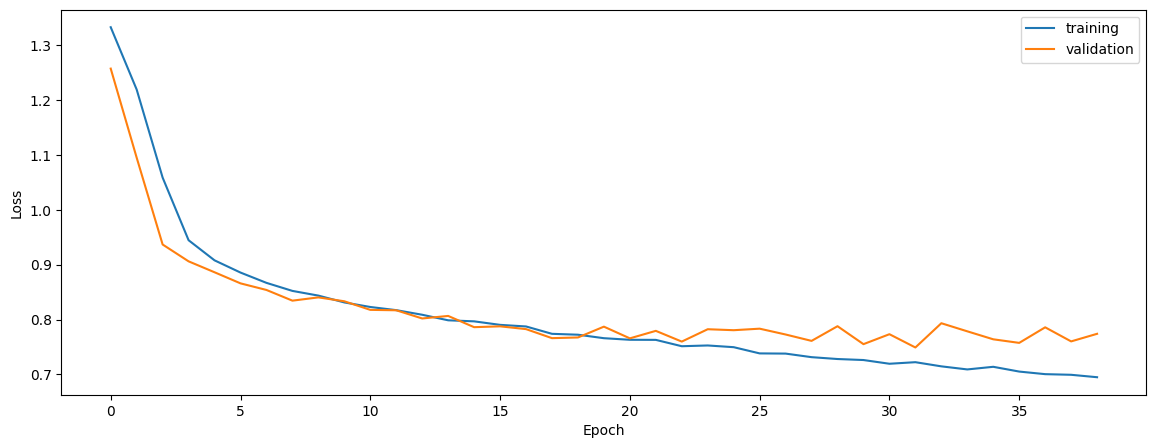

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


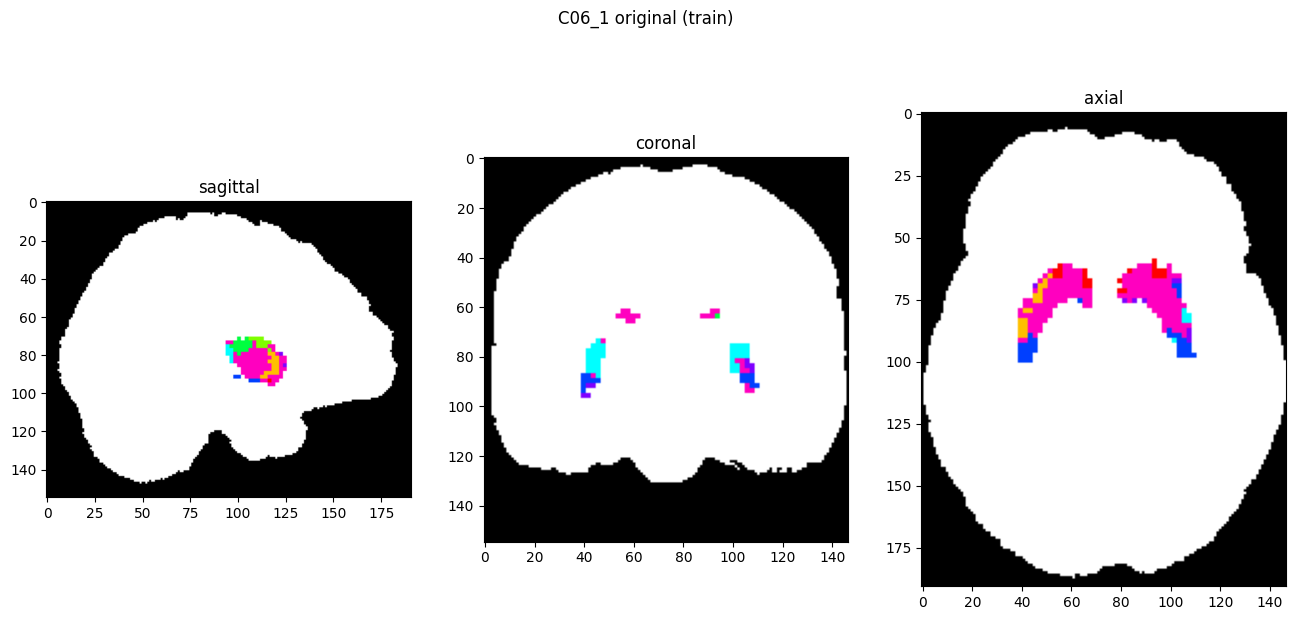

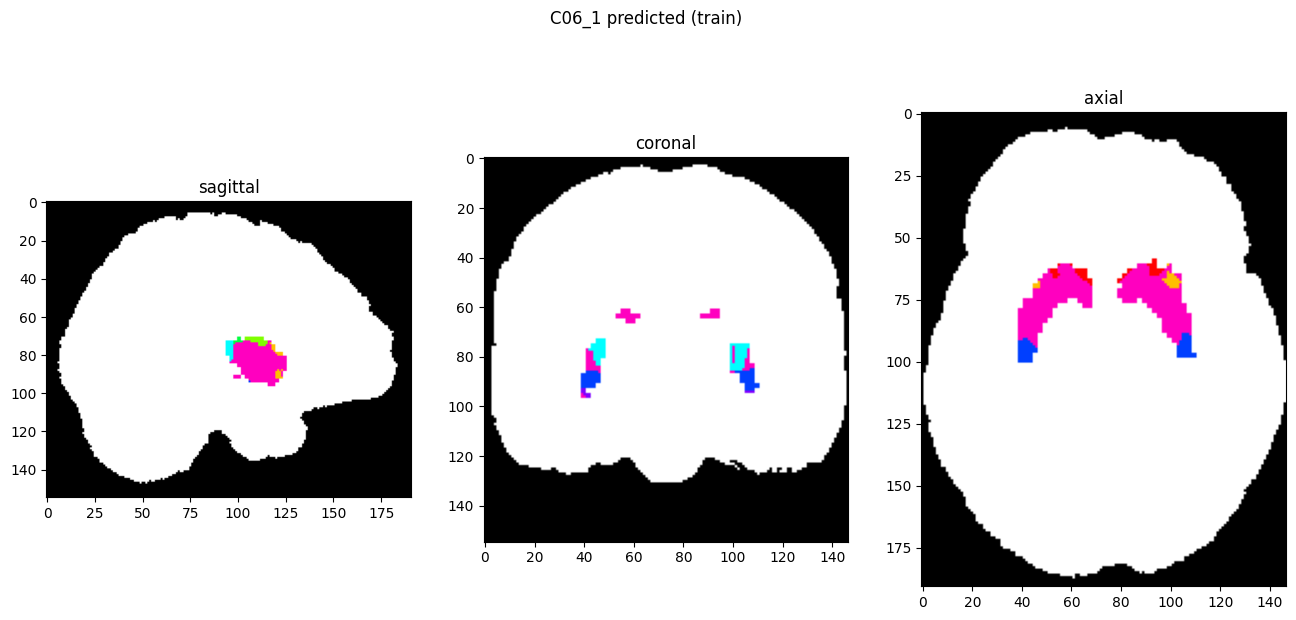

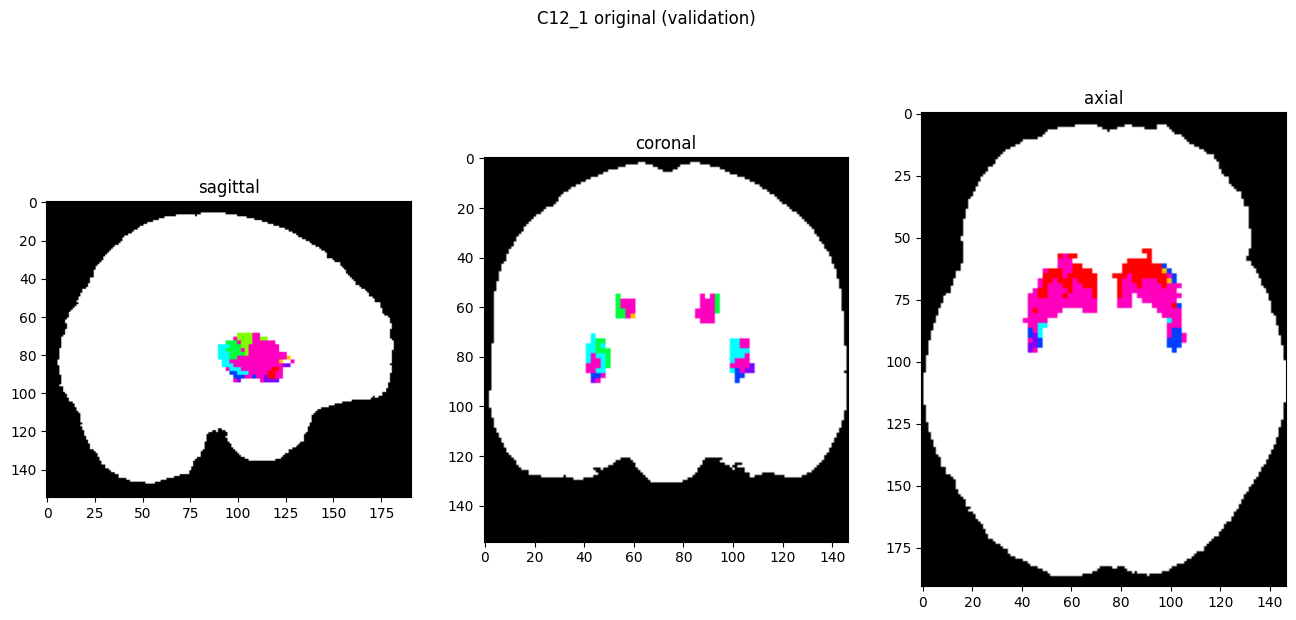

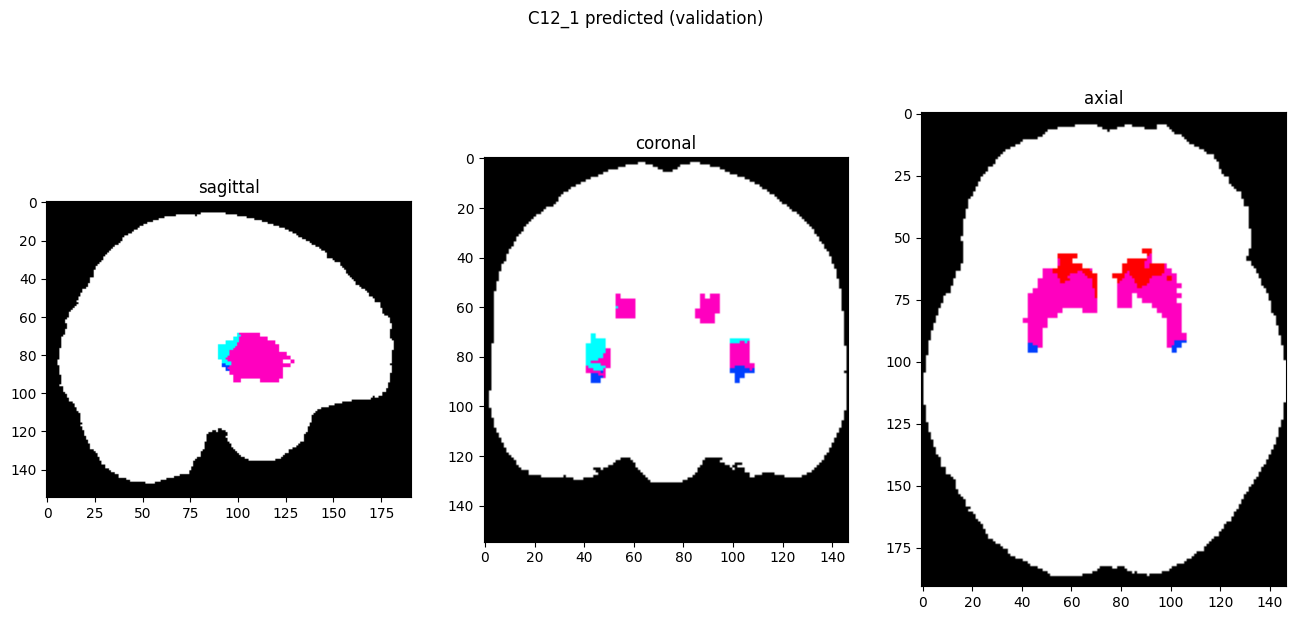

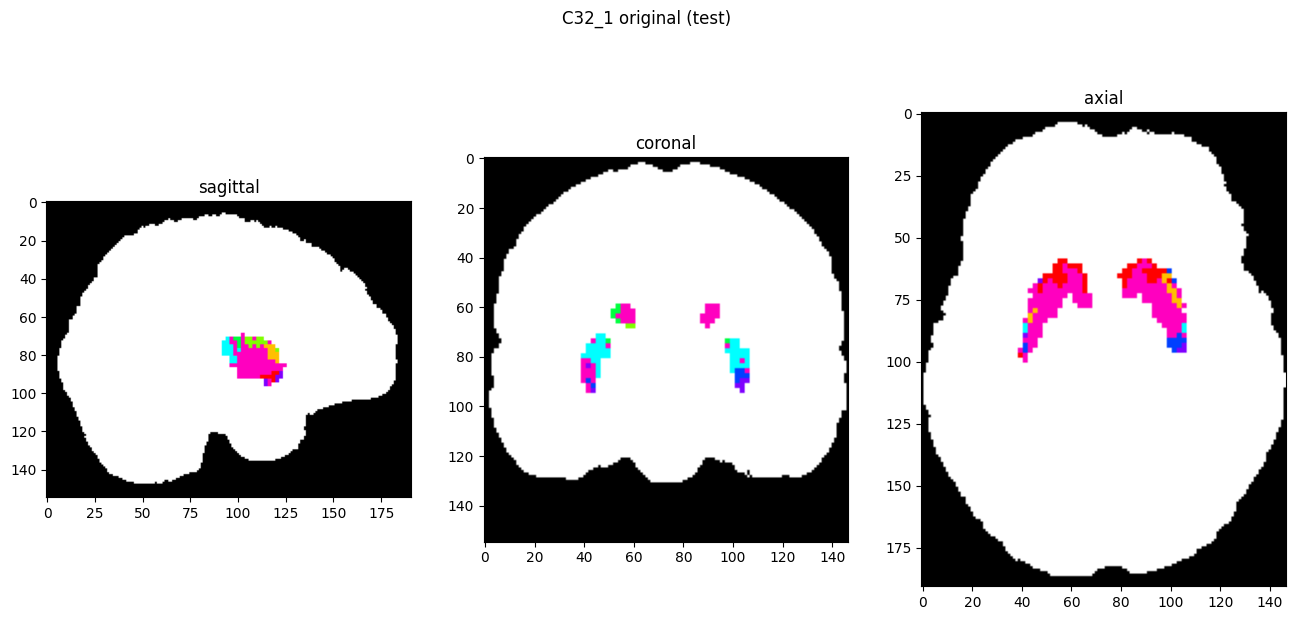

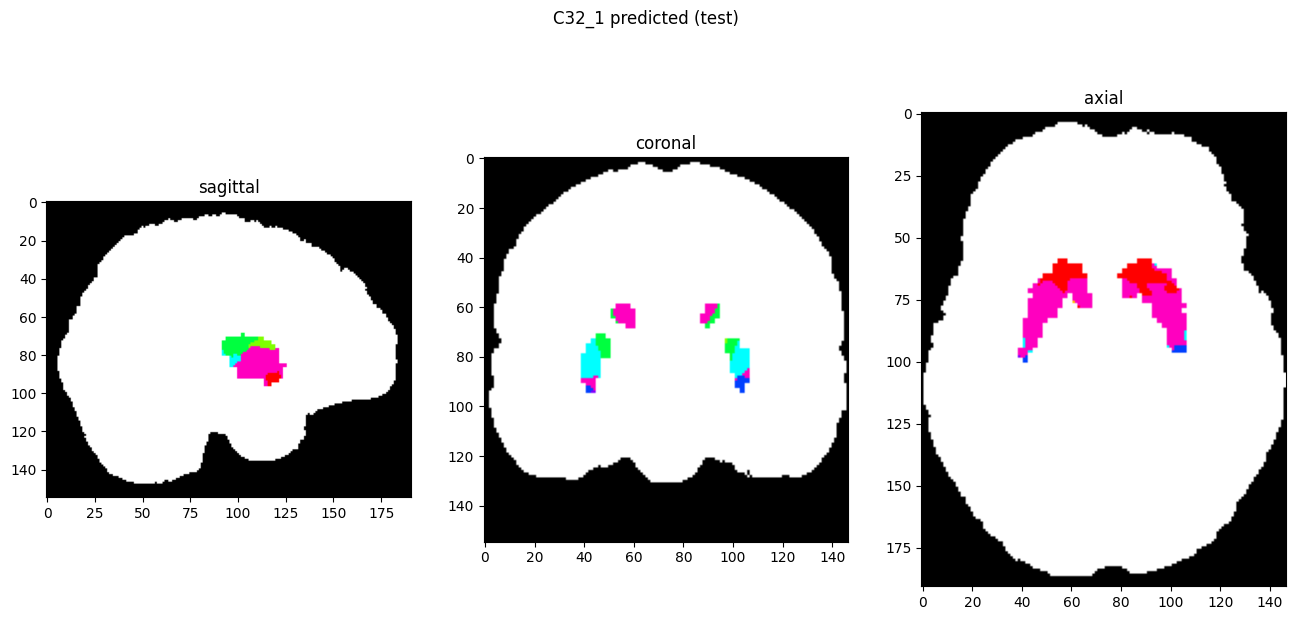

In [10]:
showResults(model, gen, threshold=0)